Our implementation (no moldicts):

In [45]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("..")

ModuleNotFoundError: No module named 'matplotlib'

In [46]:
%load_ext autoreload

In [48]:
%autoreload 2
import sys
sys.path.append("..")
from analyses.metrics import *

ModuleNotFoundError: No module named 'chex'

In [49]:
models = ["Symphony", "Symphony (UFF relaxed)", "EDM", "EDM (UFF relaxed)", "GSchNet", "GSchNet (UFF relaxed)", "GSphereNet", "GSphereNet (UFF relaxed)"]
colors = sns.color_palette("Paired", n_colors=len(models))
model_palette = {model: color for model, color in zip(models, colors)}
model_palette["QM9"] = "black"
model_palette

NameError: name 'sns' is not defined

Paths:

In [50]:
generated_paths = {
    "QM9": "/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz",
    "Symphony": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/molecules",
    "EDM": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm/samples_edm_xyz",
    "GSchNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet/molecules",
    "GSphereNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/molecules",
}

bonded_paths = {
    "Symphony": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/bonded_molecules",
    "EDM": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm/samples_edm_bonded",
    "GSchNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet/bonded_molecules",
    "GSphereNet": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/bonded_molecules",
}

generated_and_relaxed_paths = {
    **generated_paths,
    "Symphony (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/relaxed_molecules",
    "EDM (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/edm/samples_edm_relaxed",
    "GSchNet (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/gschnet/relaxed_molecules",
    "GSphereNet (UFF relaxed)": "/Users/ameyad/Documents/spherical-harmonic-net/others/gspherenet/relaxed_molecules",
}


Number of Atoms Per Molecule

In [59]:
molecule_sizes = {
    model: count_molecule_sizes(path) for model, path in generated_paths.items()
}

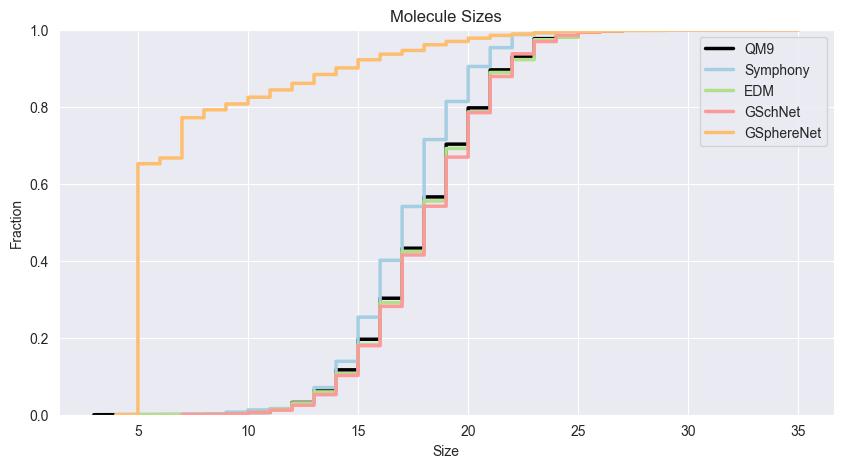

In [70]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
for model in molecule_sizes:
    sns.ecdfplot(data=molecule_sizes[model], label=model, color=model_palette[model], linewidth=2.5, ax=ax)
plt.title(f"Molecule Sizes")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Fraction")
plt.show()

Atom type counts!

In [39]:
atom_type_counts = {
    model: count_atom_types(path, normalize=True) for model, path in generated_paths.items()
}

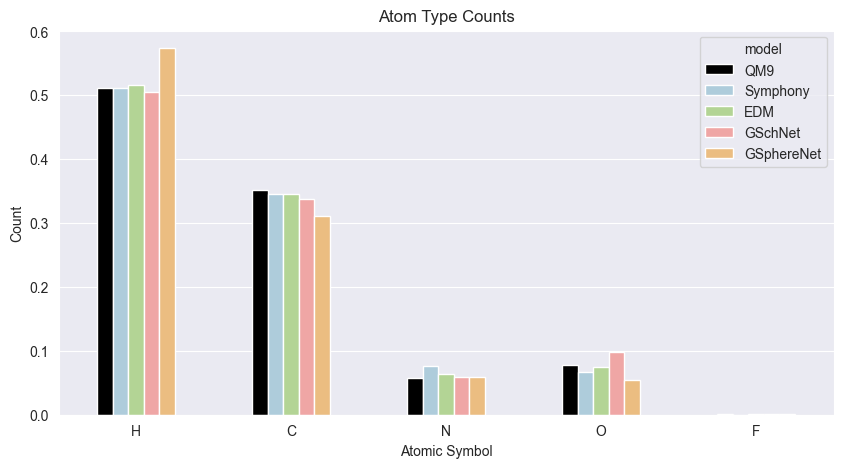

In [43]:
# Make a dataframe of all molecule sizes.
def make_atom_type_counts_df() -> pd.DataFrame:
    atom_types = ['H', 'C', 'N', 'O', 'F']
    df = pd.DataFrame(columns=["model", "atom_type", "count"])
    for model in atom_type_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "atom_type": atom_type,
                        "count": atom_type_counts[model].get(atom_type, 0),
                    }
                    for atom_type in atom_types
                ),
            ],
            ignore_index=True,
        )
    return df

atom_type_counts_df = make_atom_type_counts_df()
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=atom_type_counts_df, x="atom_type", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title(f"Atom Type Counts")
plt.xlabel("Atomic Symbol")
plt.ylabel("Fraction")
plt.show()

Local environments:

In [9]:
local_environments = {
    model: compute_local_environments(molecules_dir, max_num_molecules=1000)
    for model, molecules_dir in generated_paths.items()
}

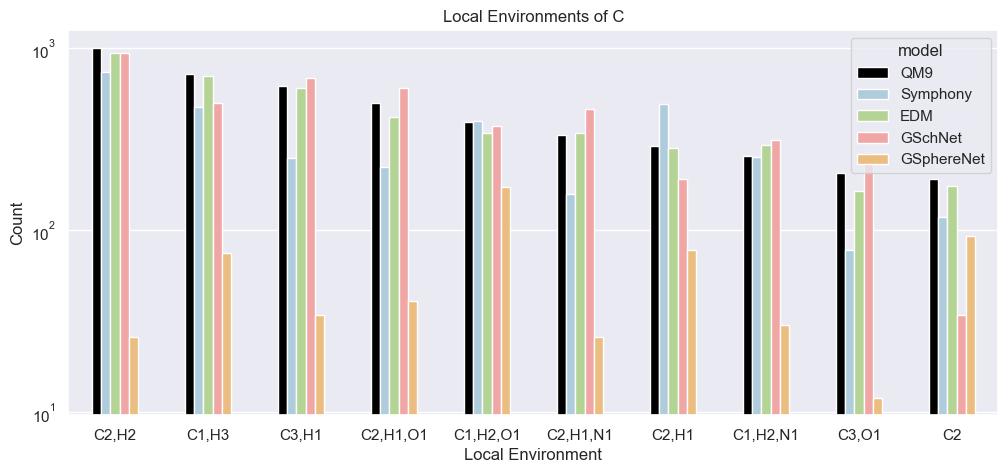

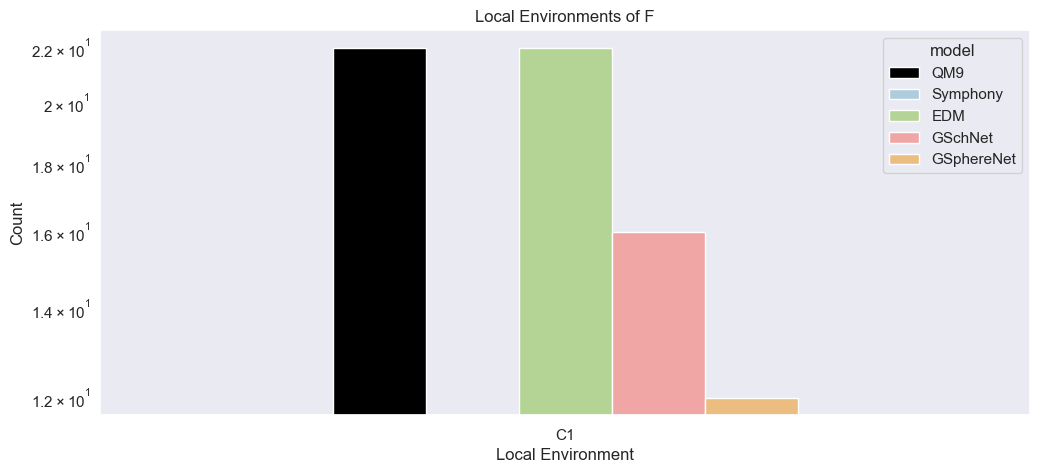

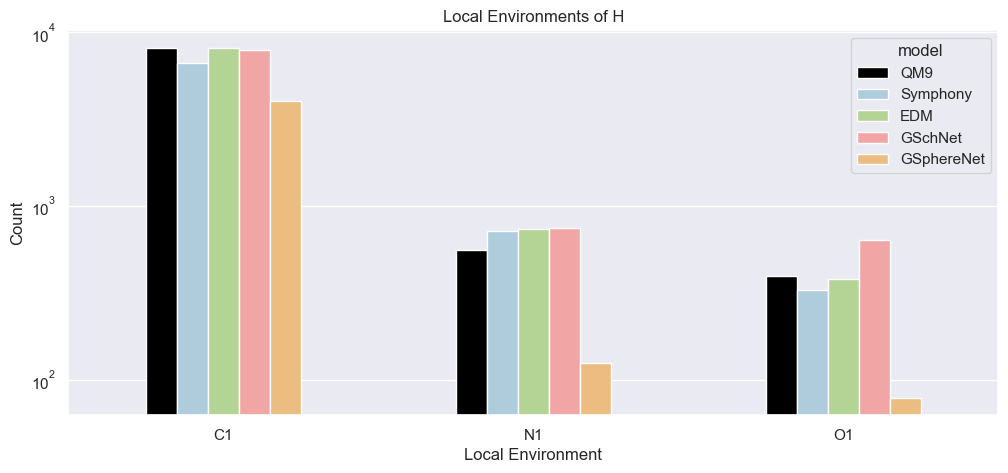

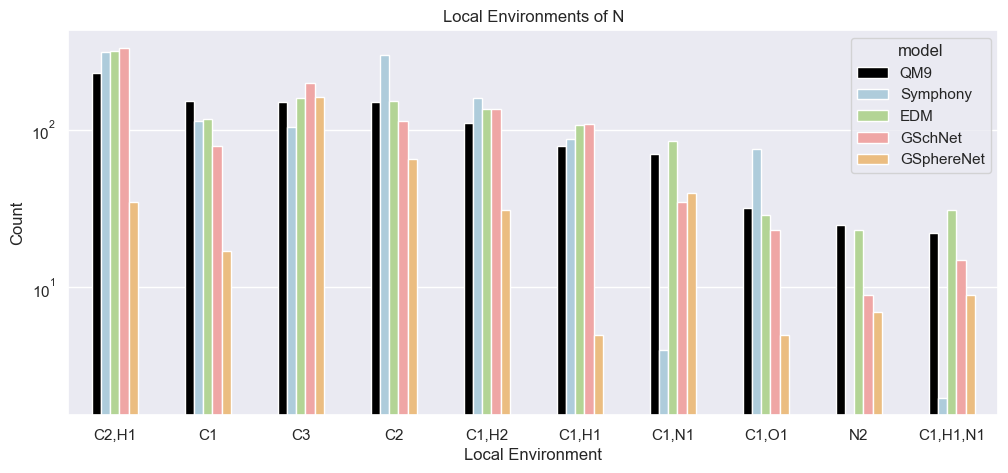

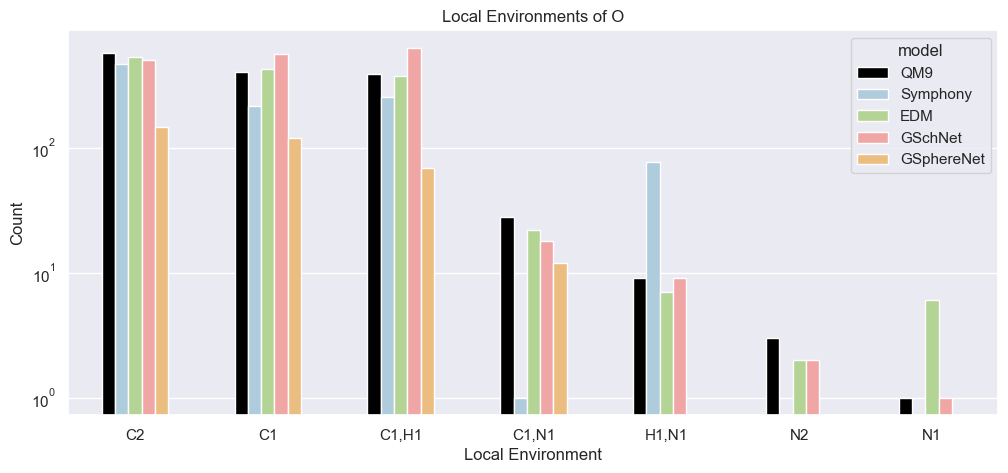

In [50]:
def make_local_environments_dataframe(central_atom_type: str, max_unique_environments: int) -> pd.DataFrame:
    """Make a dataframe of counts for each of QM9, Symphony and EDM."""
    neighbors = dict(sorted(local_environments["QM9"][central_atom_type].items(), key=lambda x: x[1], reverse=True)[:max_unique_environments])
    df = pd.DataFrame(columns=["model", "neighbors", "count"])
    for model in generated_paths:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "neighbors": neighbor,
                        "count": local_environments[model].get(central_atom_type, {}).get(neighbor, 0),
                    }
                    for neighbor in neighbors
                ),
            ],
            ignore_index=True,
        )
    return df


for central_atom_type in sorted(local_environments["QM9"]):
    local_environments_df = make_local_environments_dataframe(central_atom_type, max_unique_environments=10)

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(data=local_environments_df, x="neighbors", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
    plt.title(f"Local Environments of {central_atom_type}")
    plt.xlabel("Local Environment")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()

Bispectra of local environments:

In [14]:
lmax = 4
max_num_molecules = 1000

bispectra = {
    model: compute_bispectra_of_local_environments(molecules_dir, lmax, max_num_molecules)
    for model, molecules_dir in generated_paths.items()
}

 37%|███▋      | 3654/10000 [00:41<01:12, 87.69it/s] 


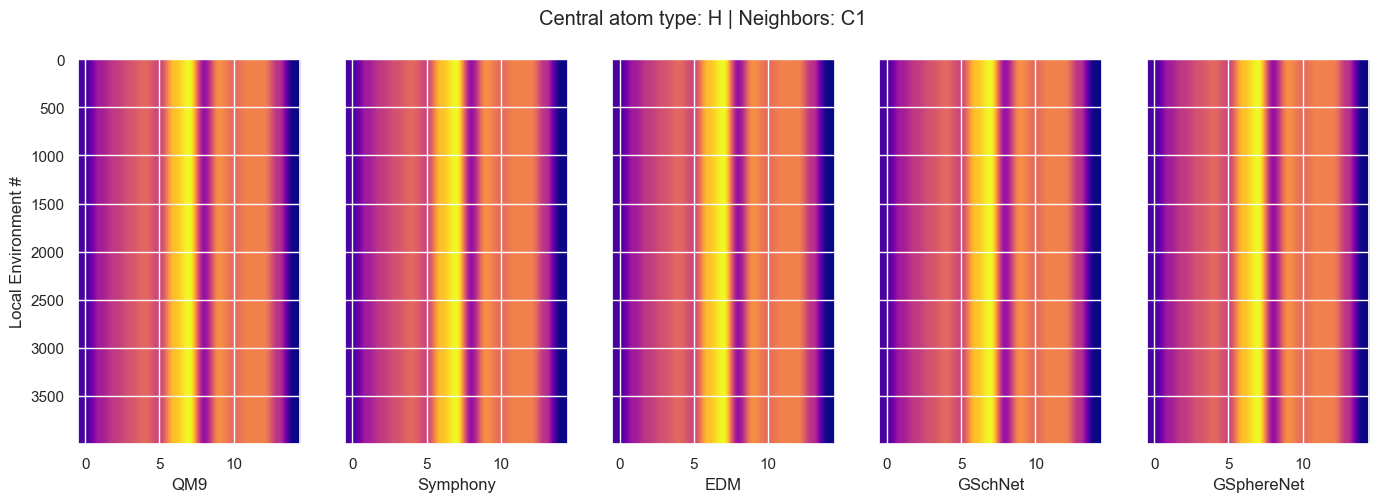

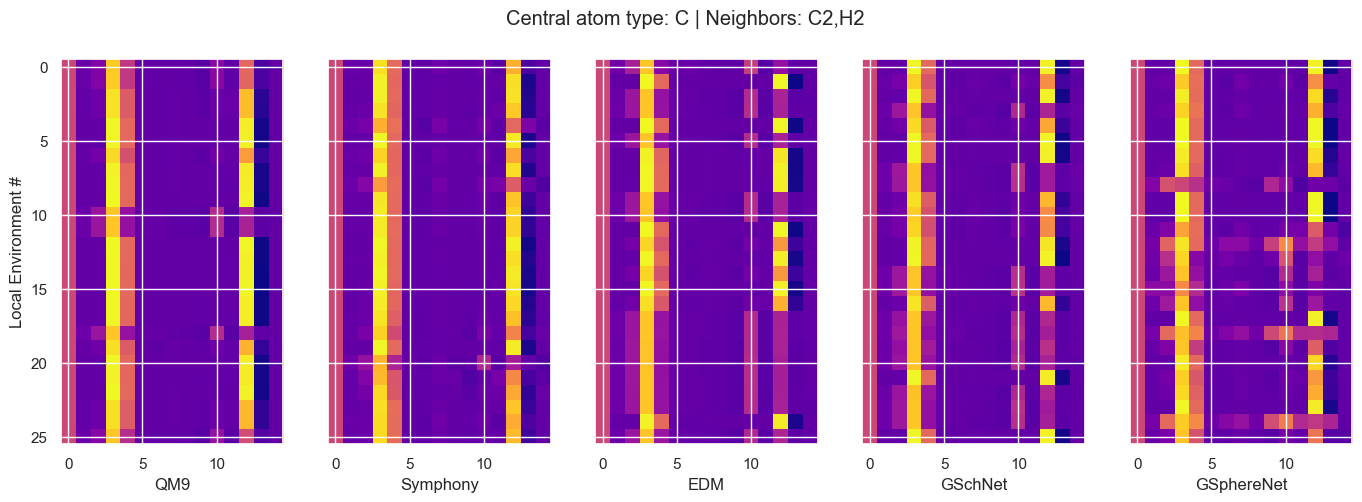

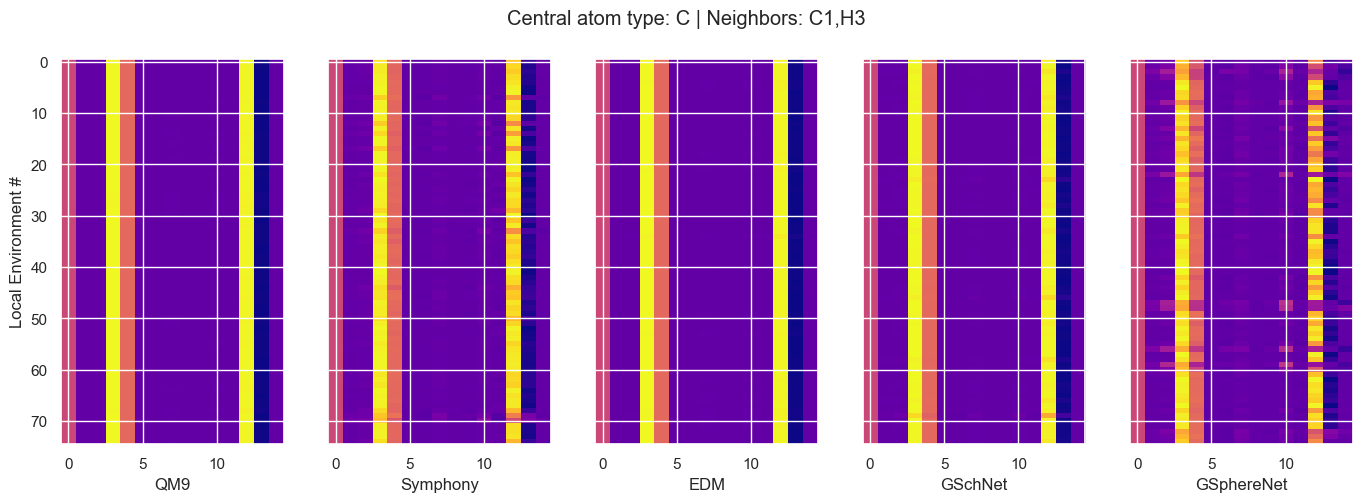

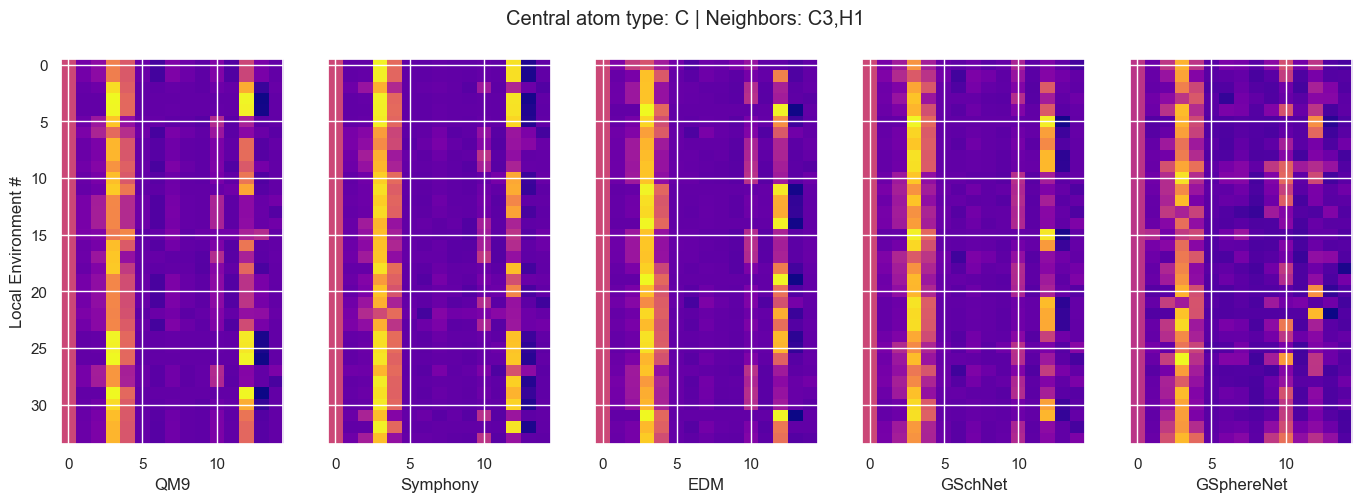

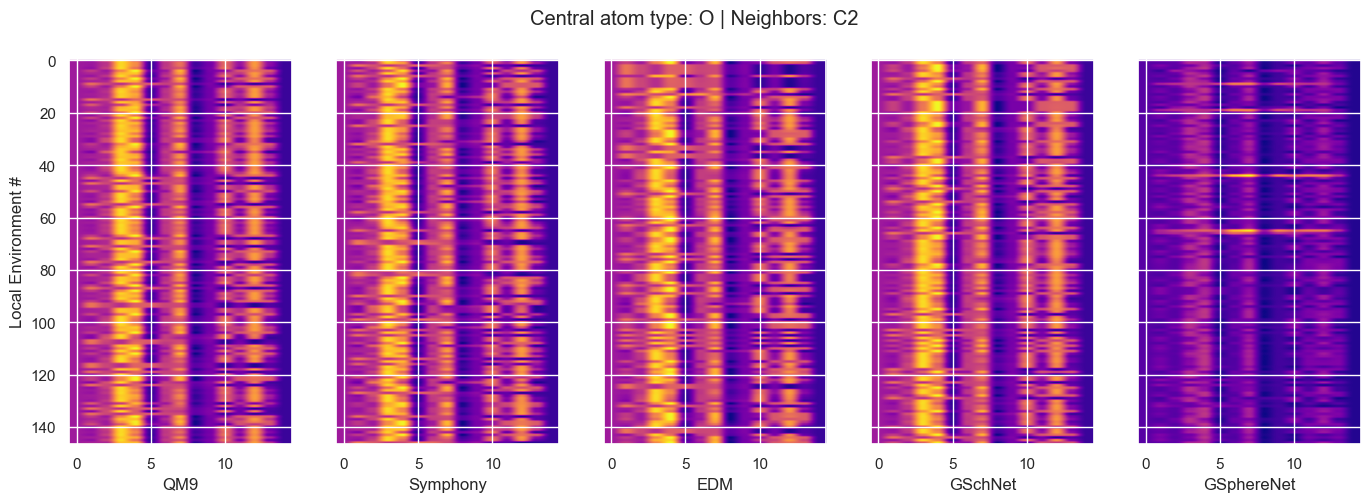

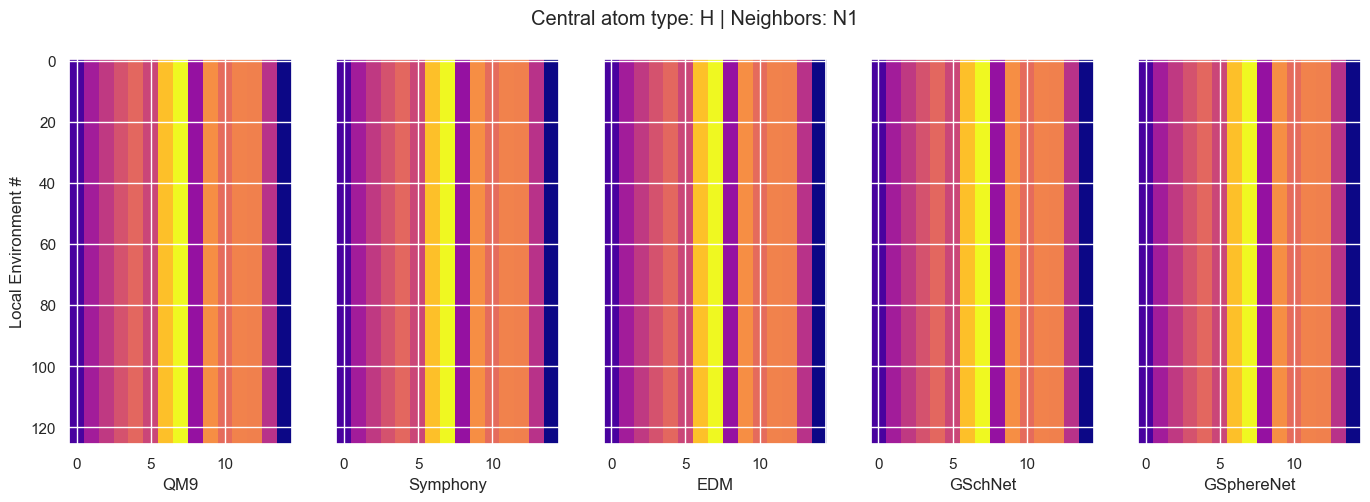

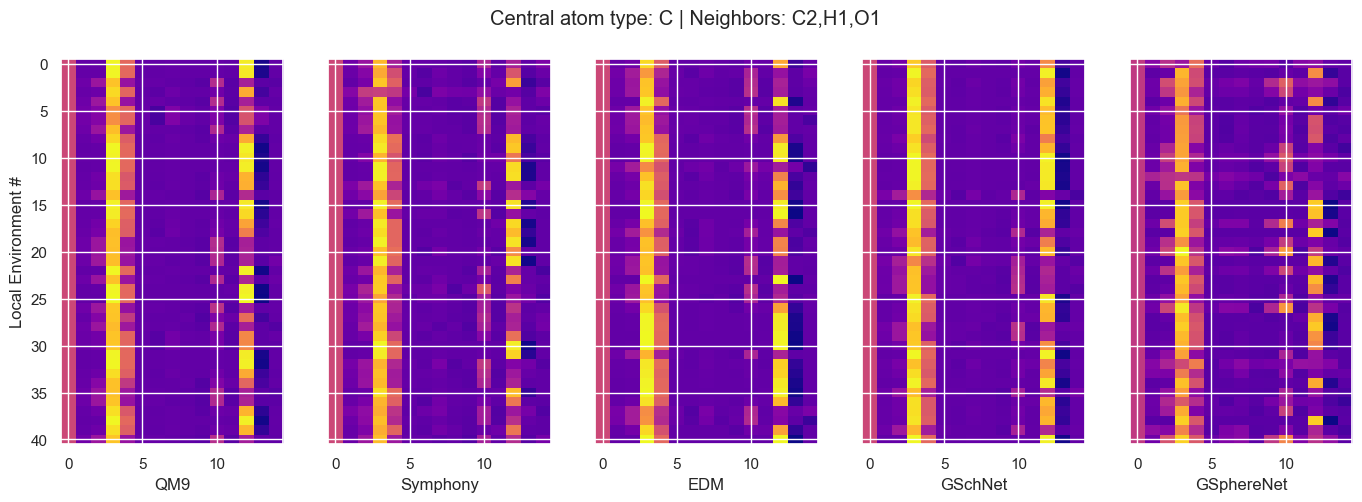

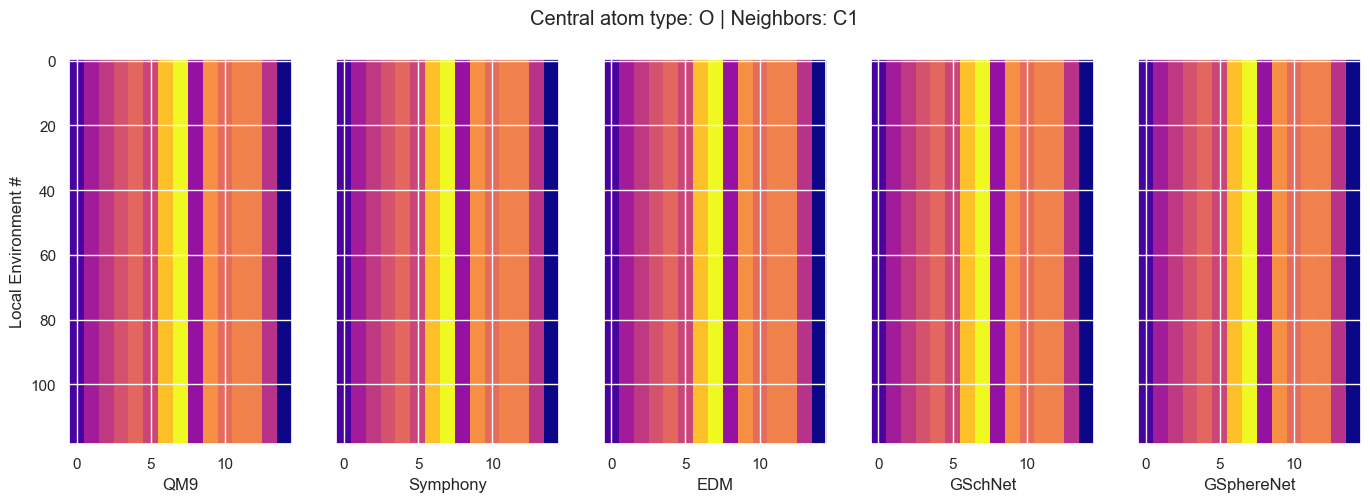

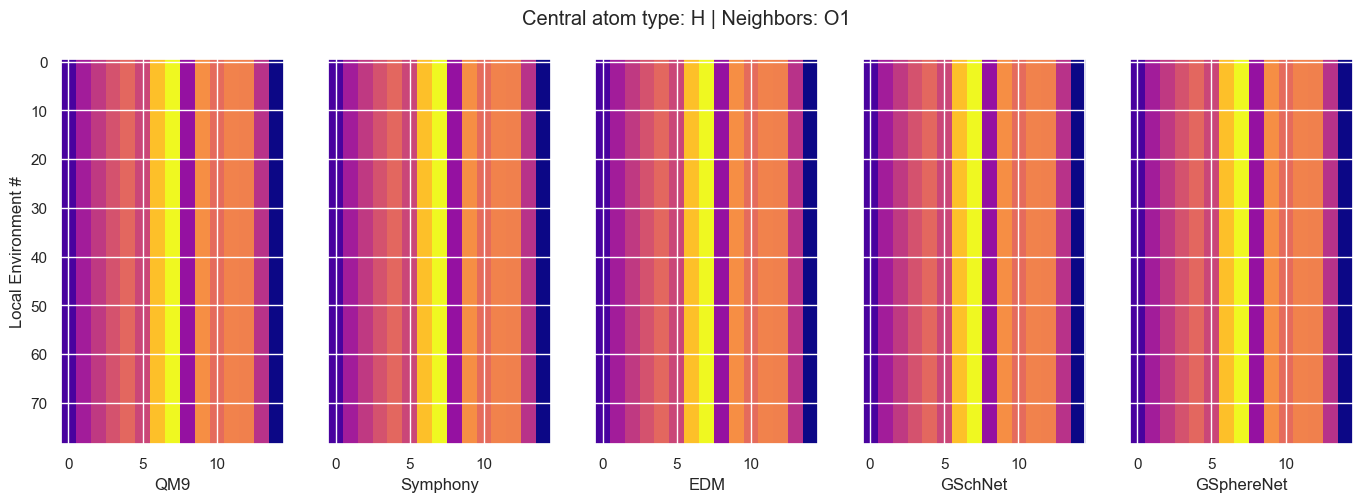

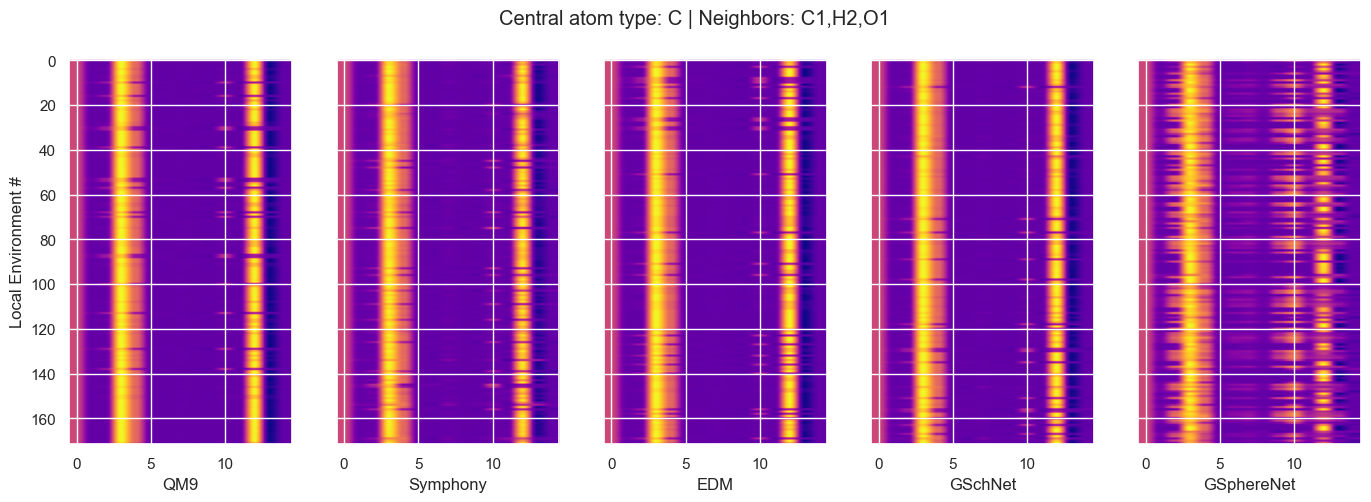

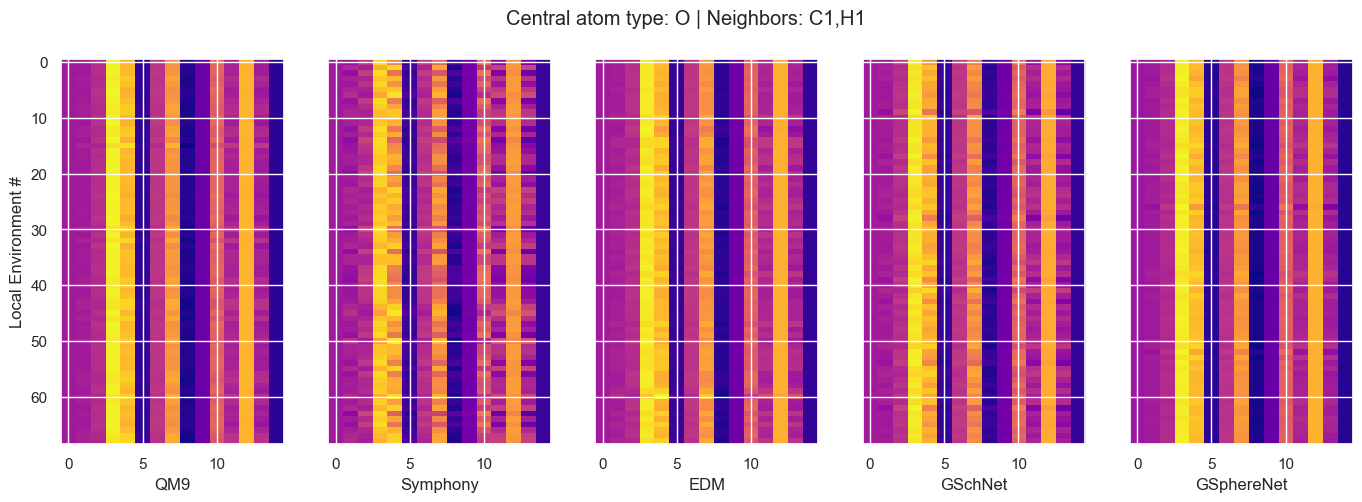

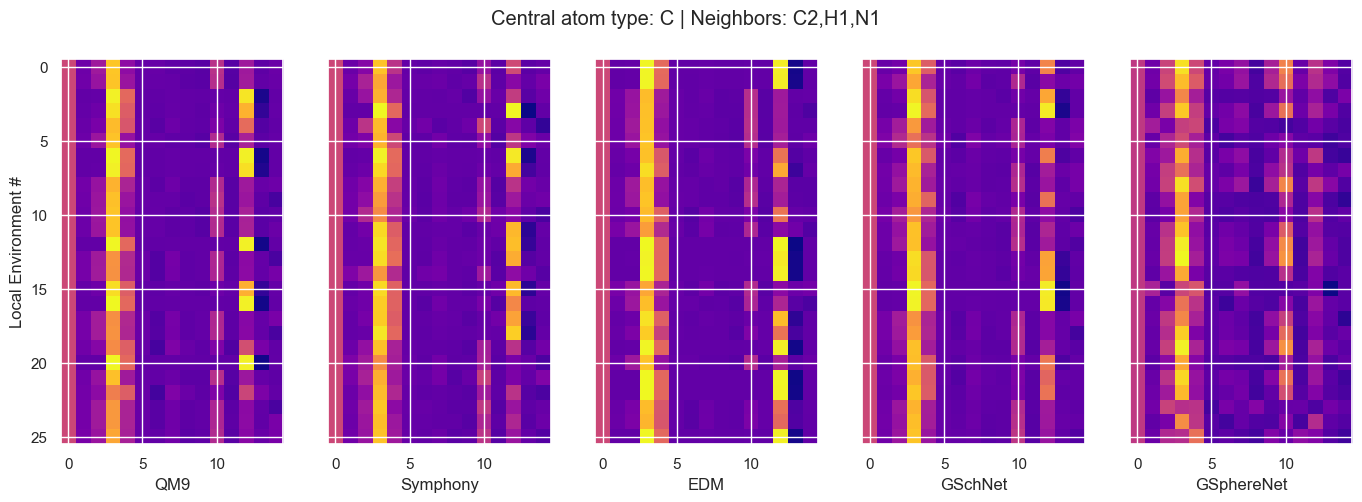

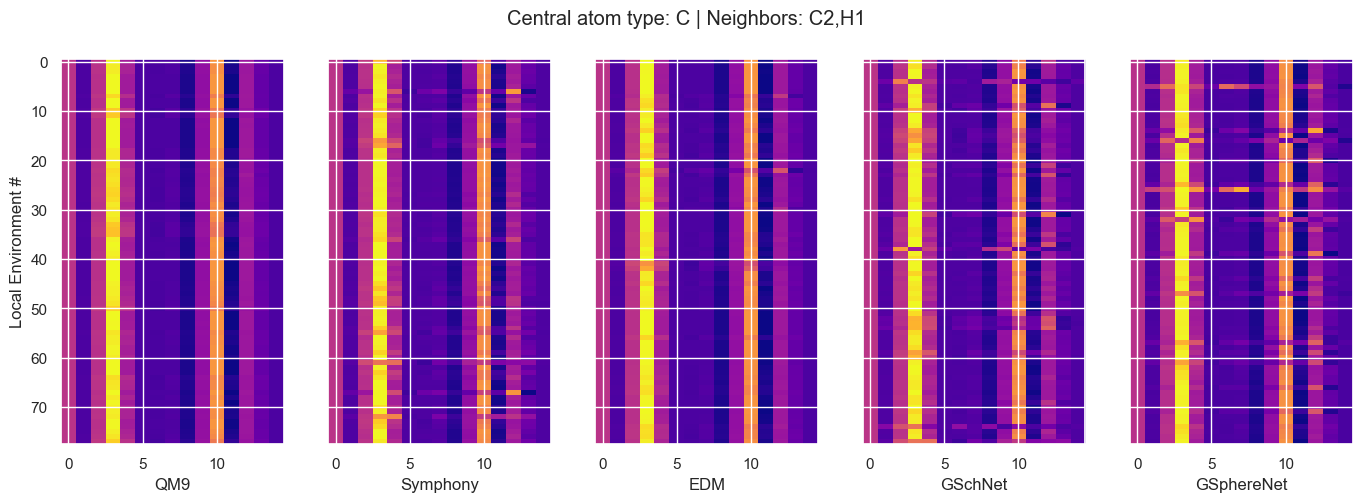

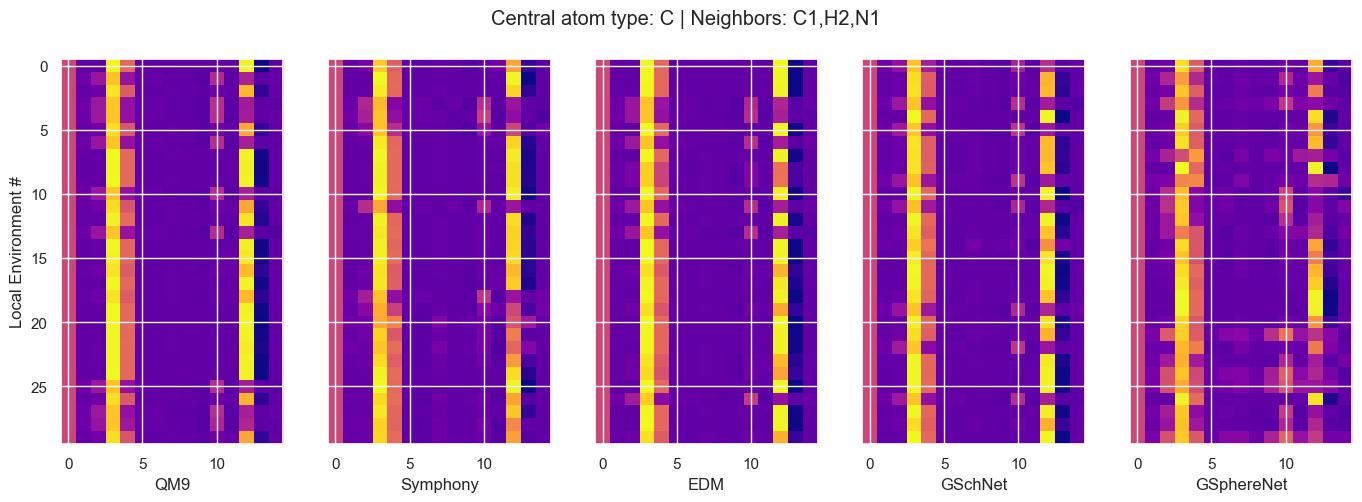

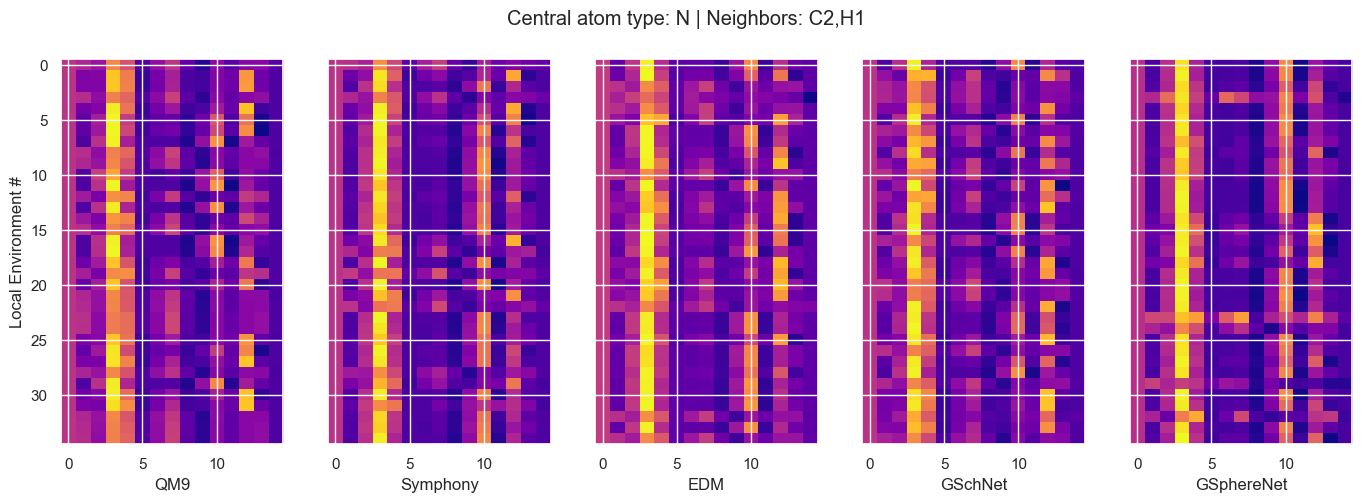

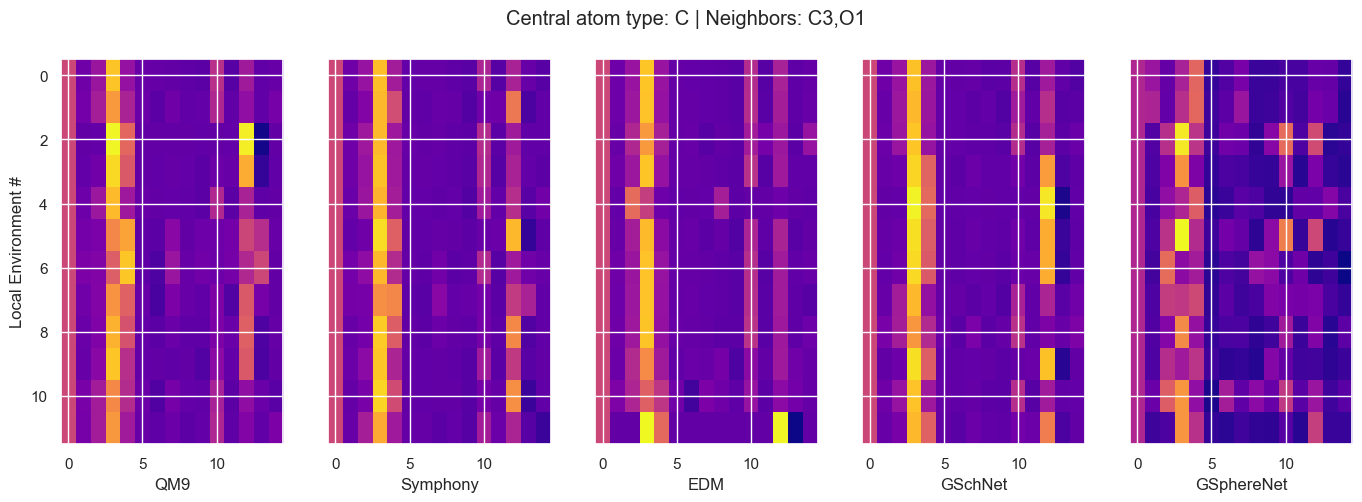

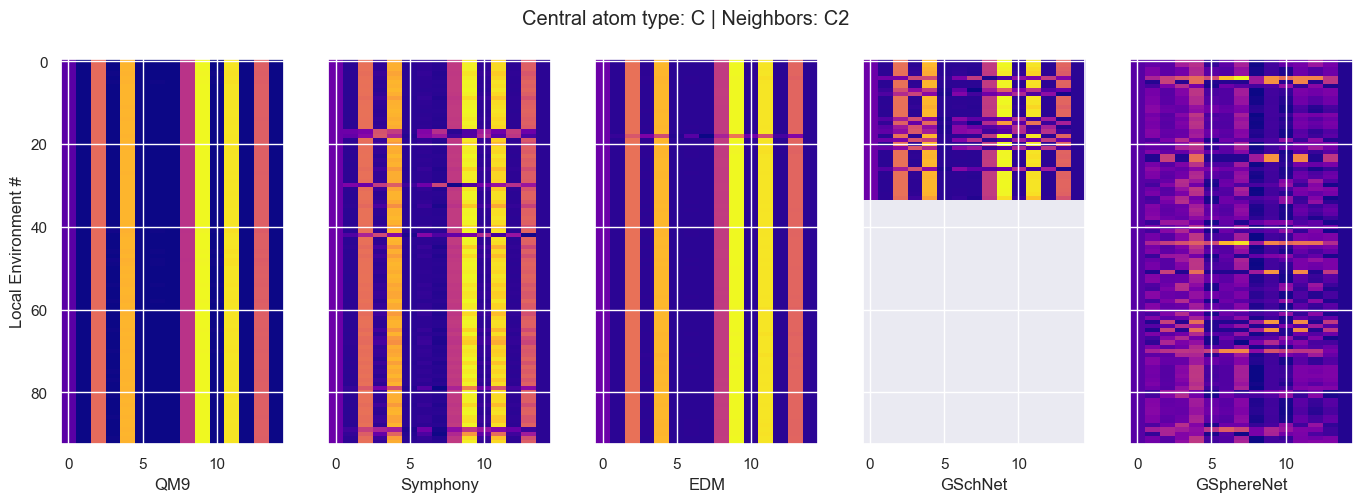

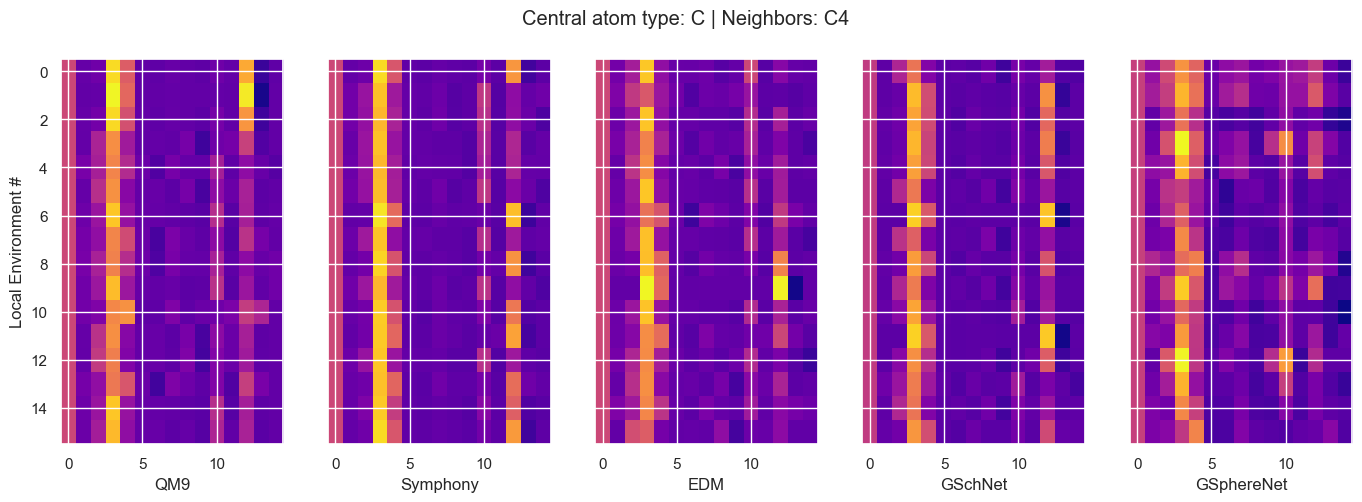

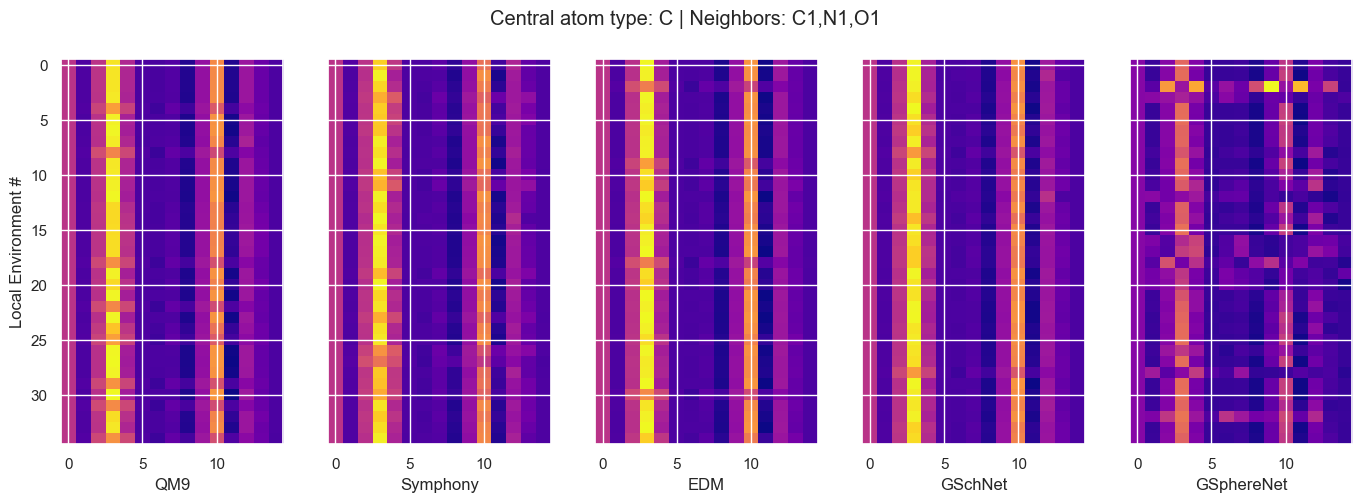

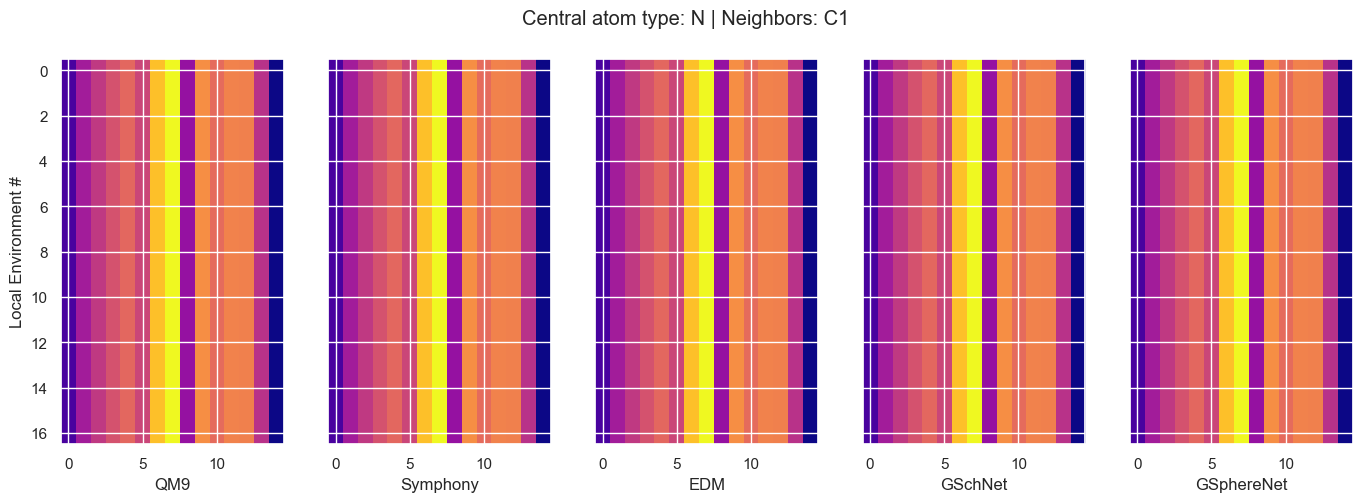

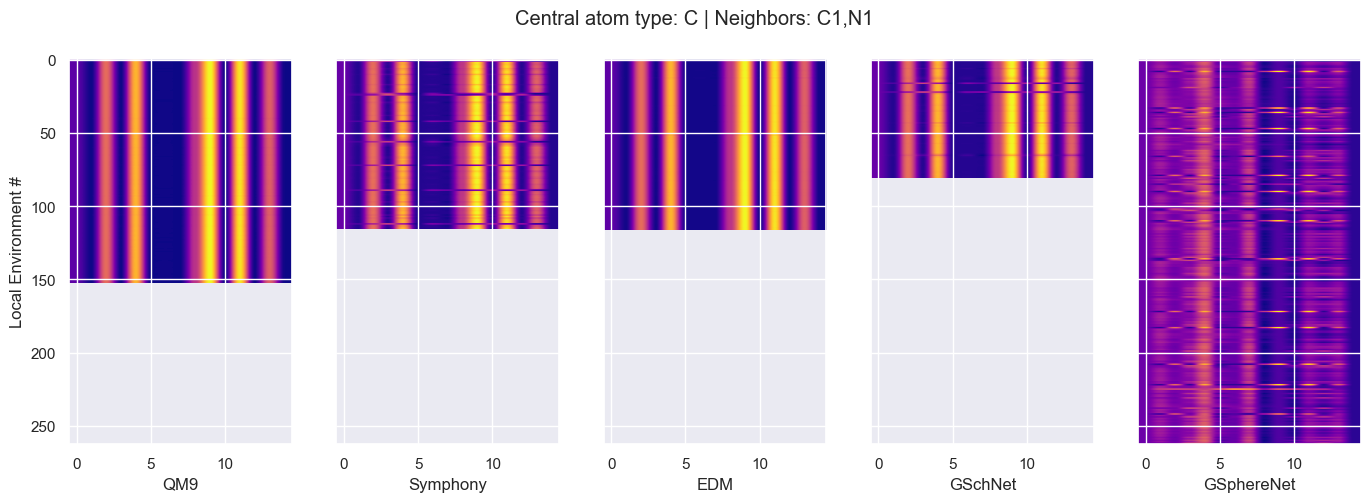

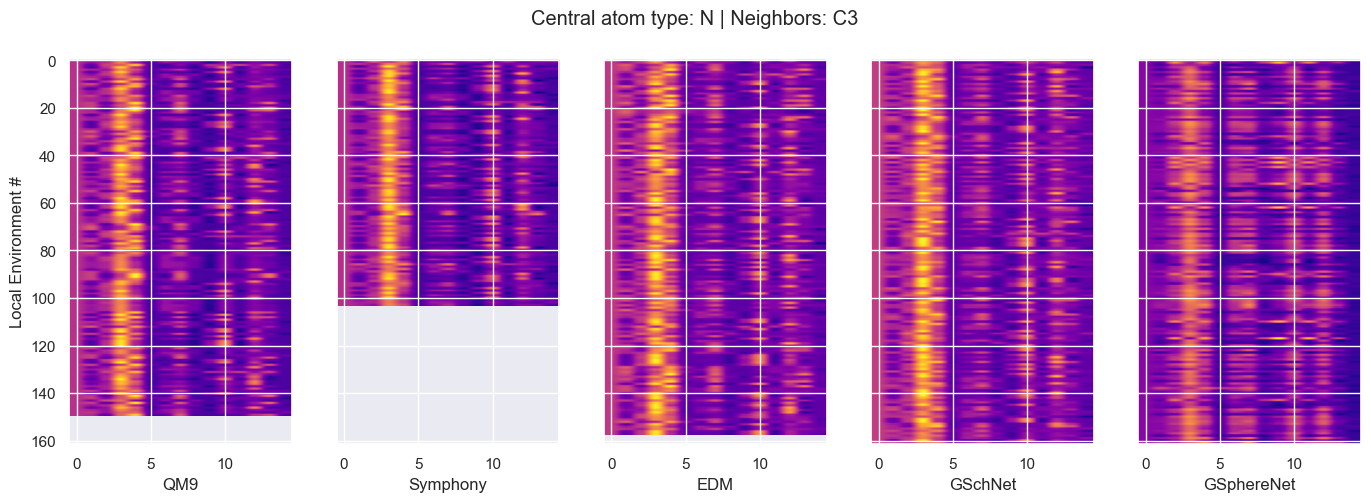

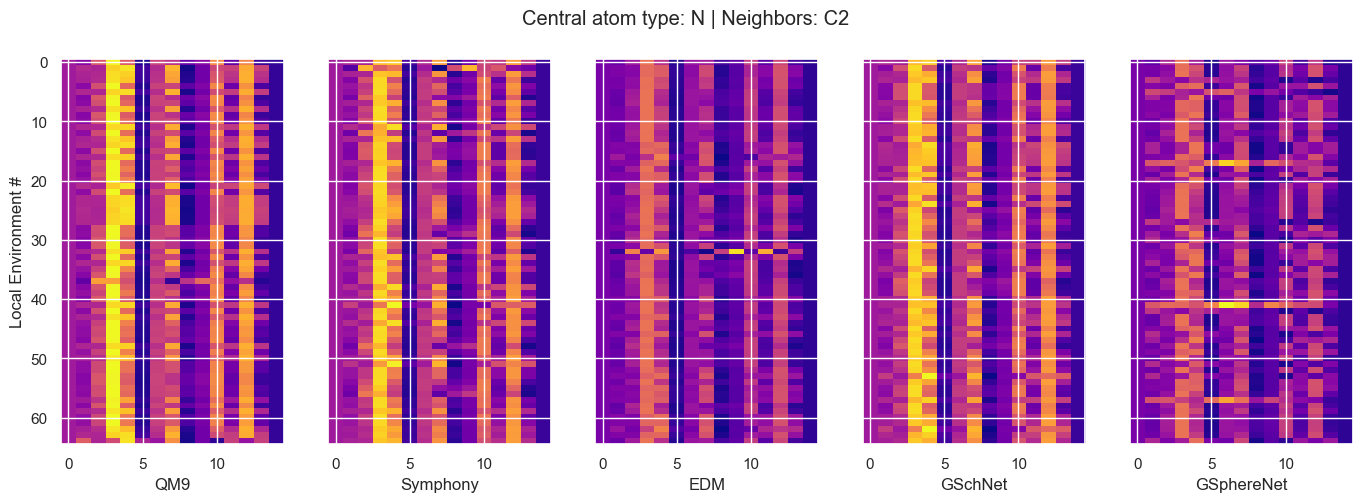

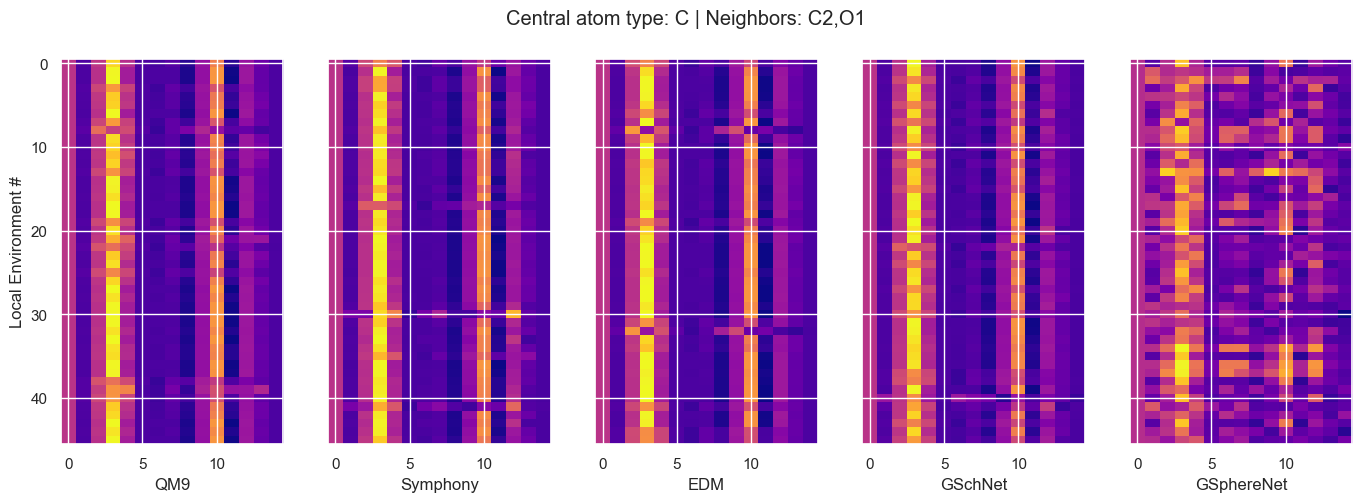

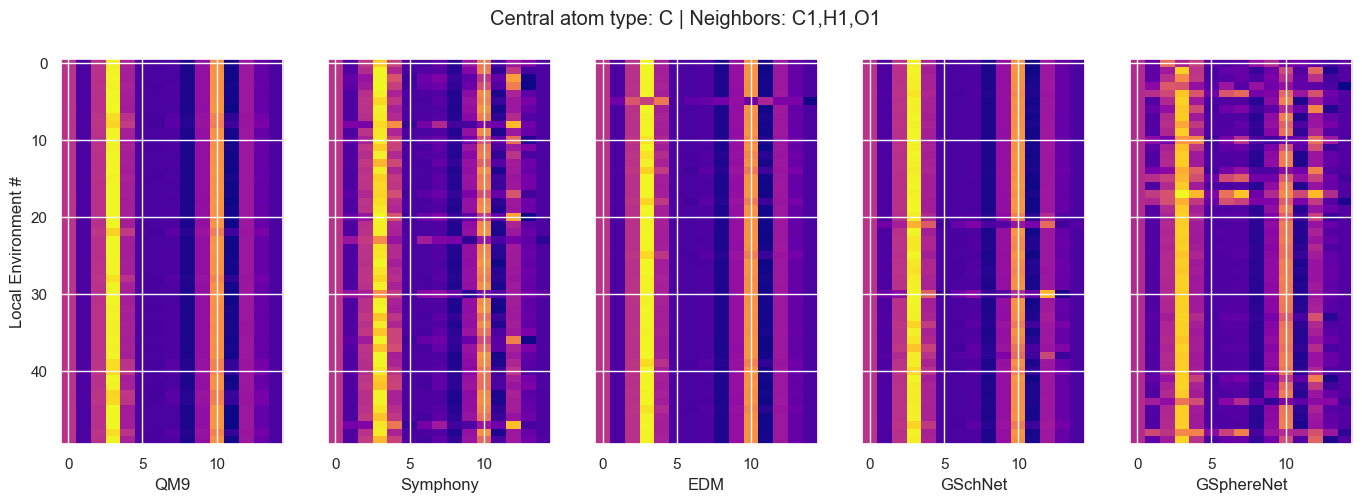

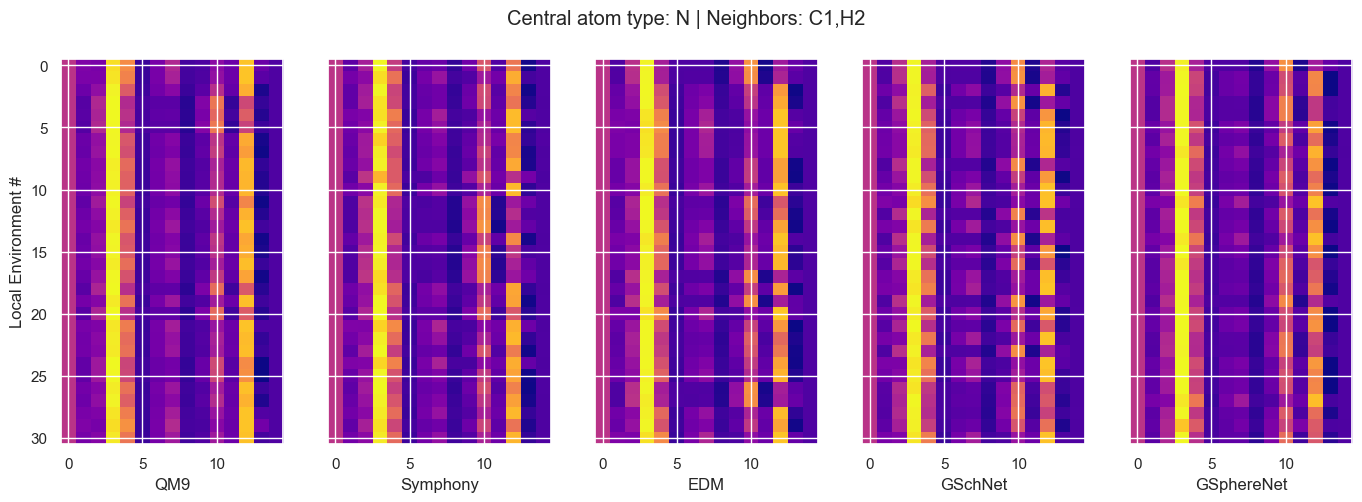

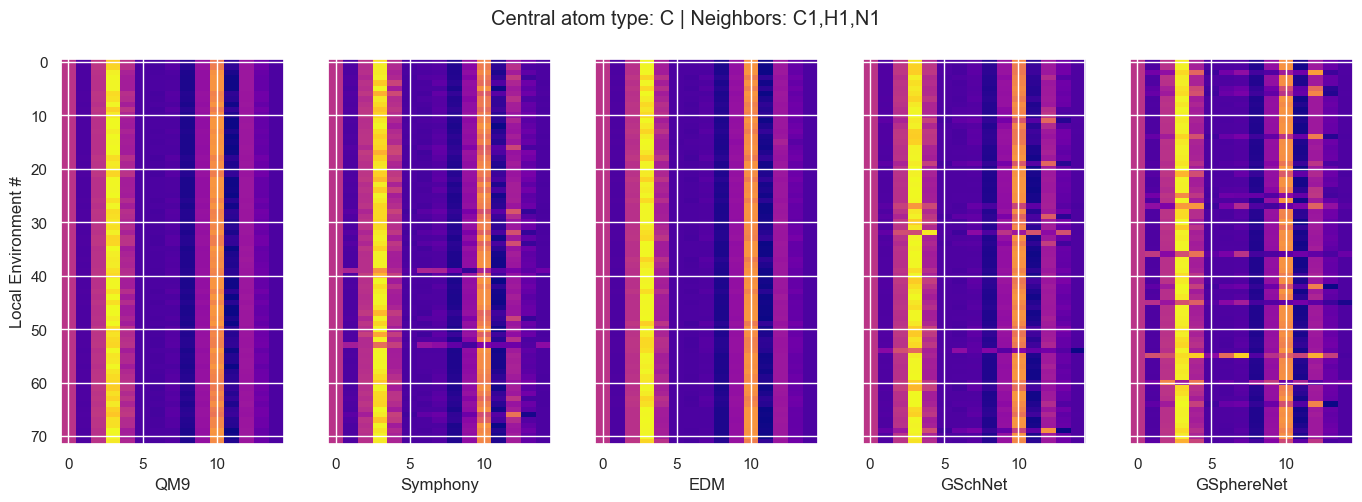

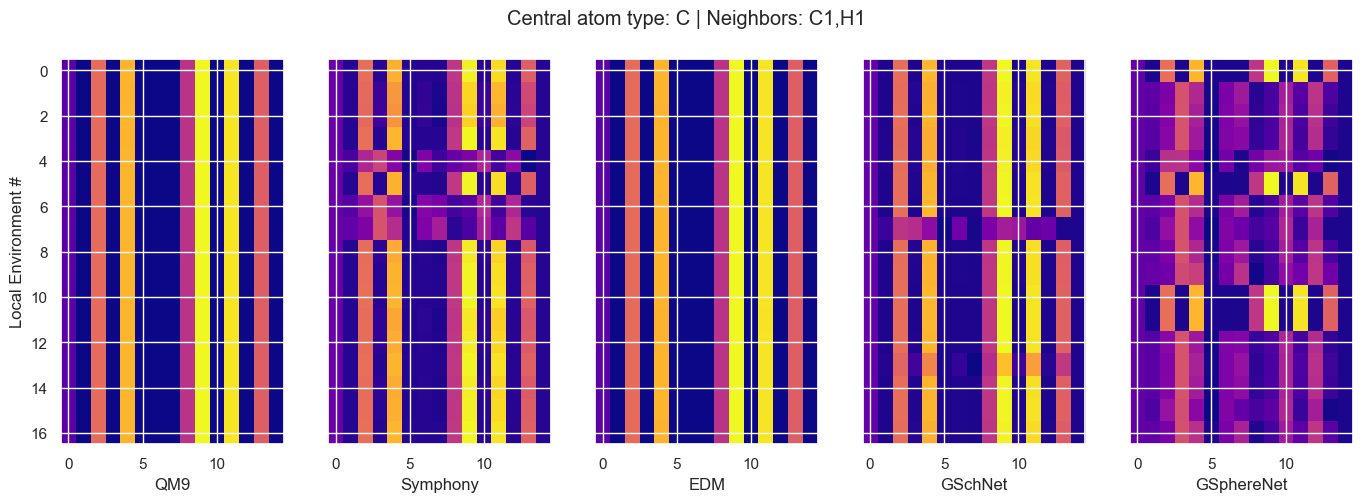

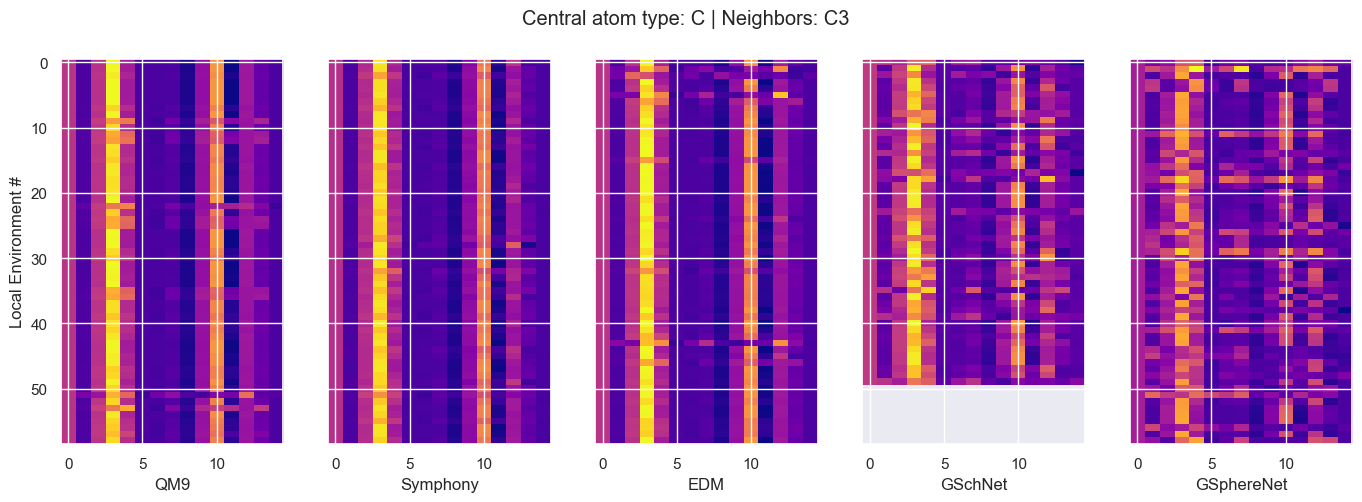

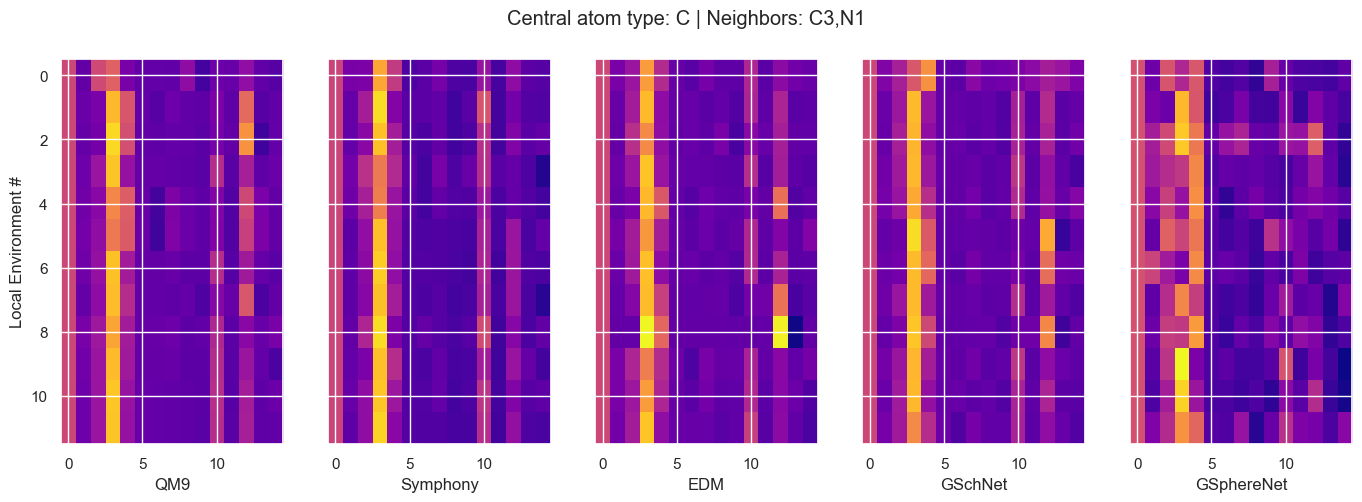

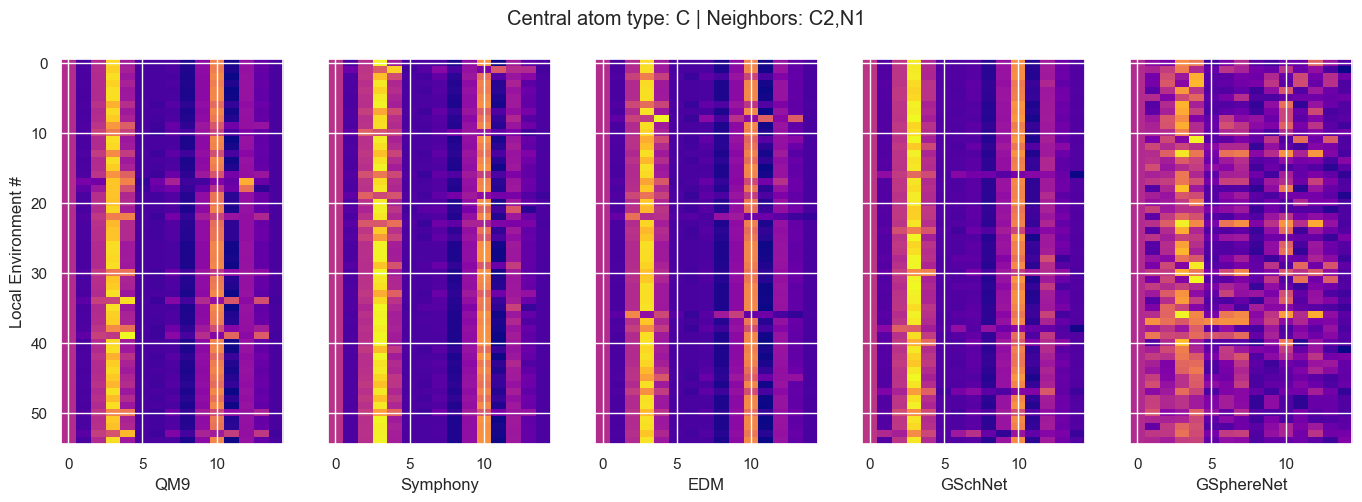

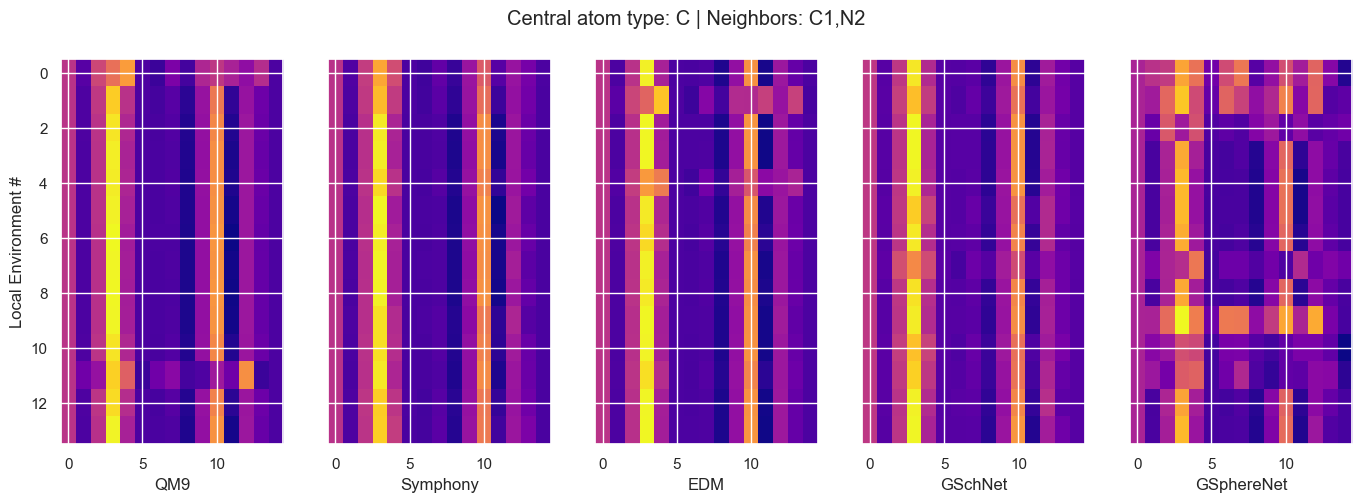

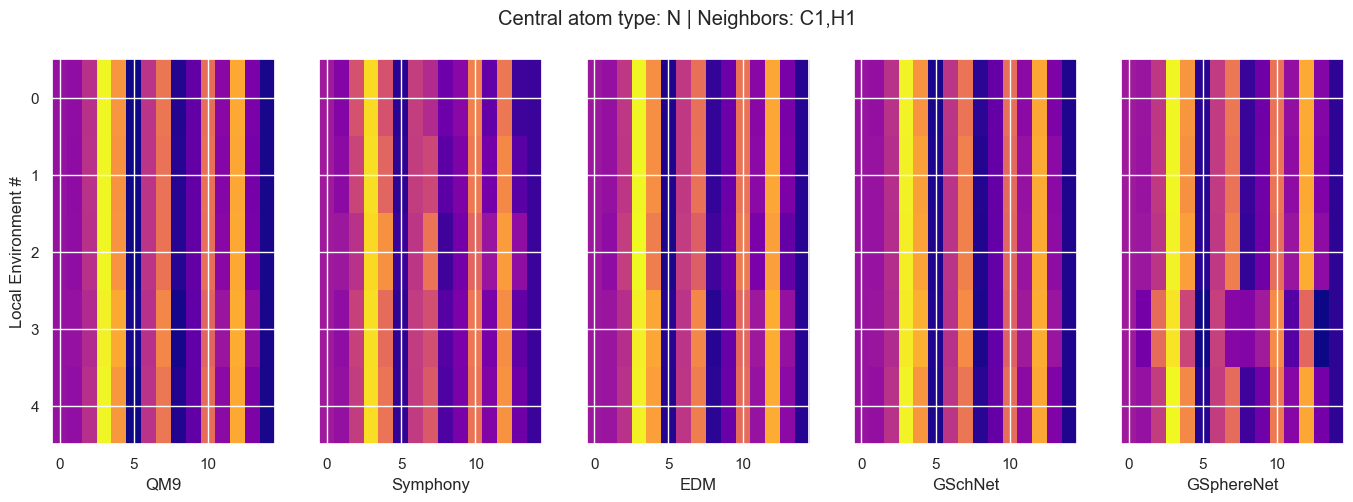

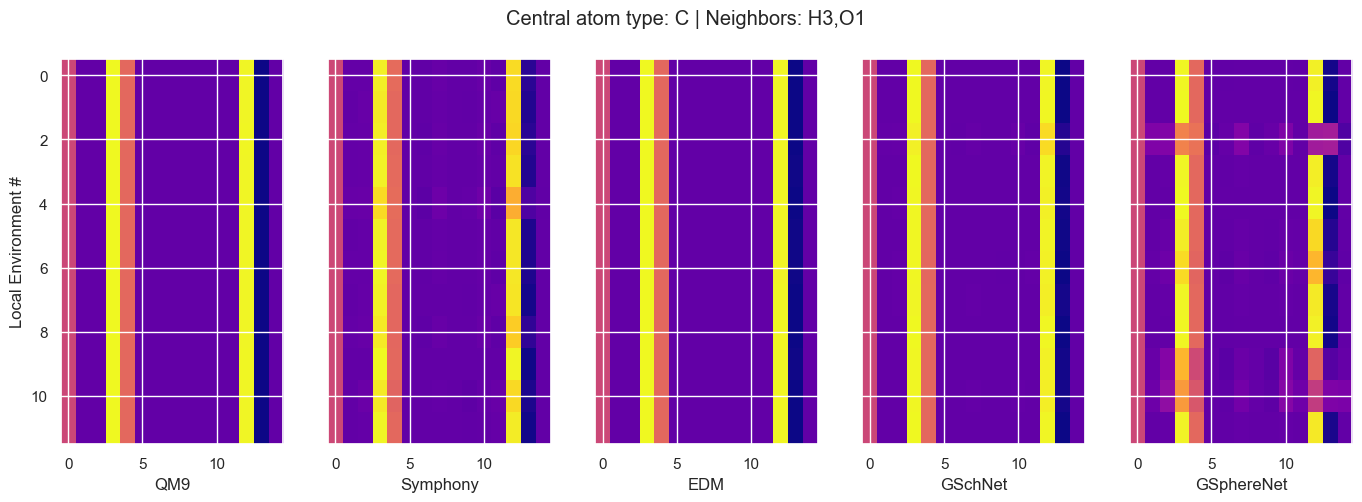

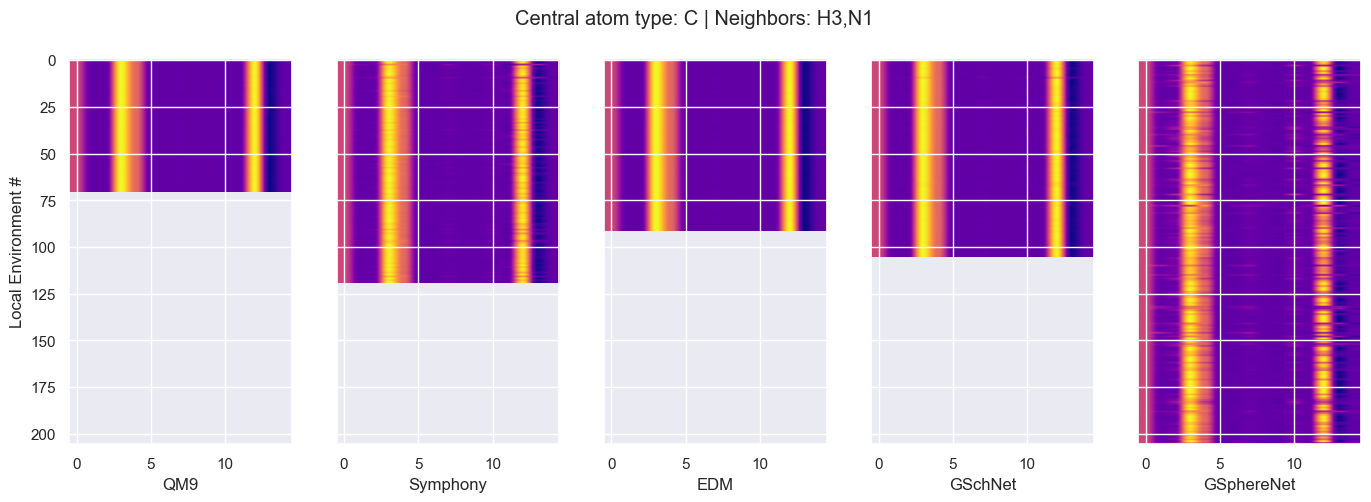

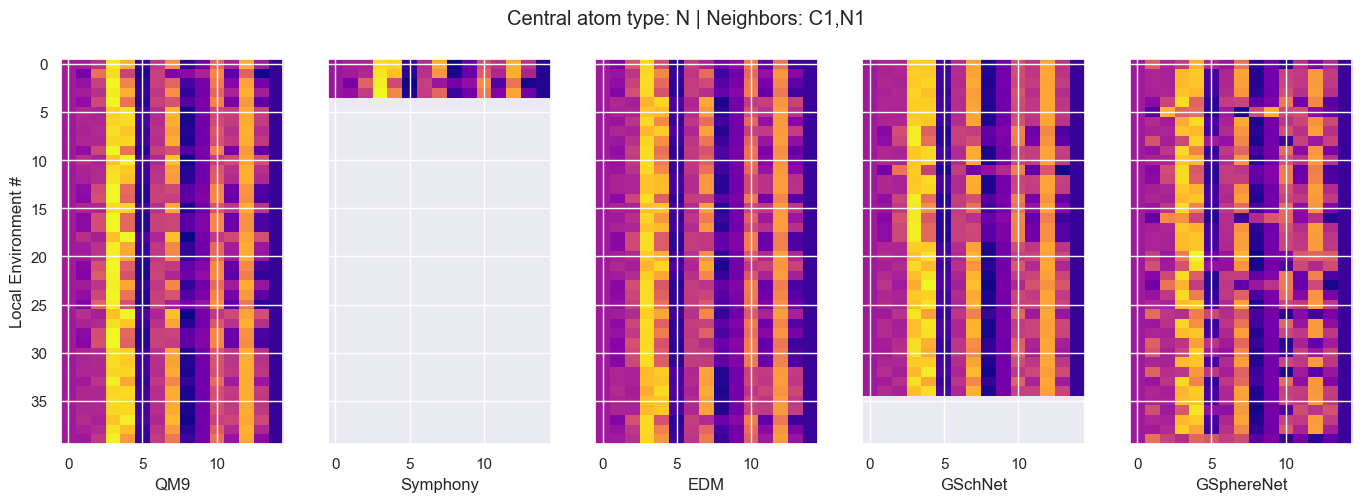

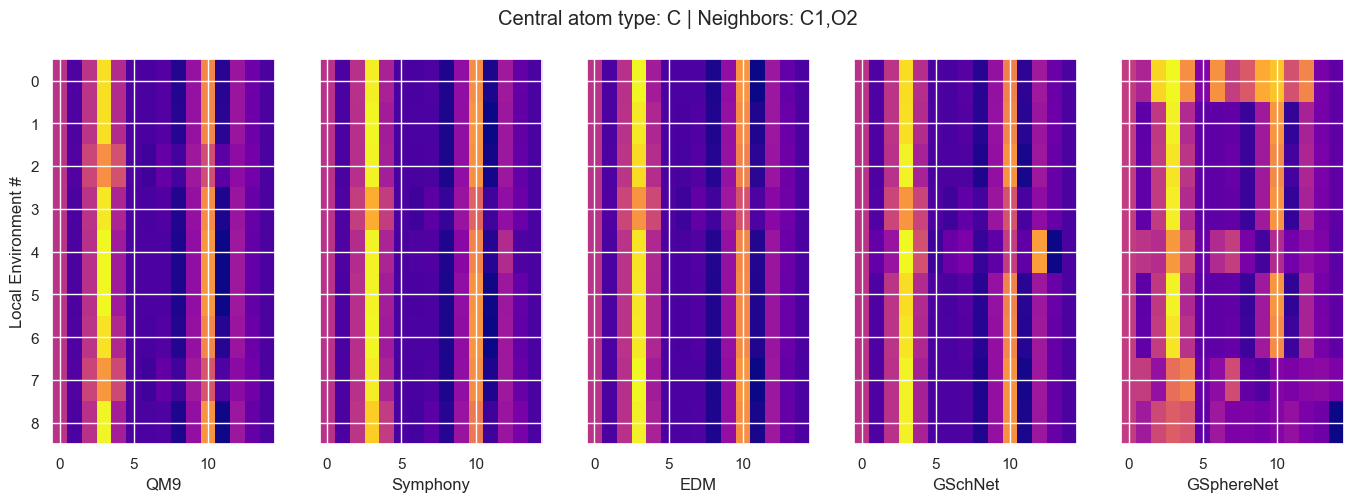

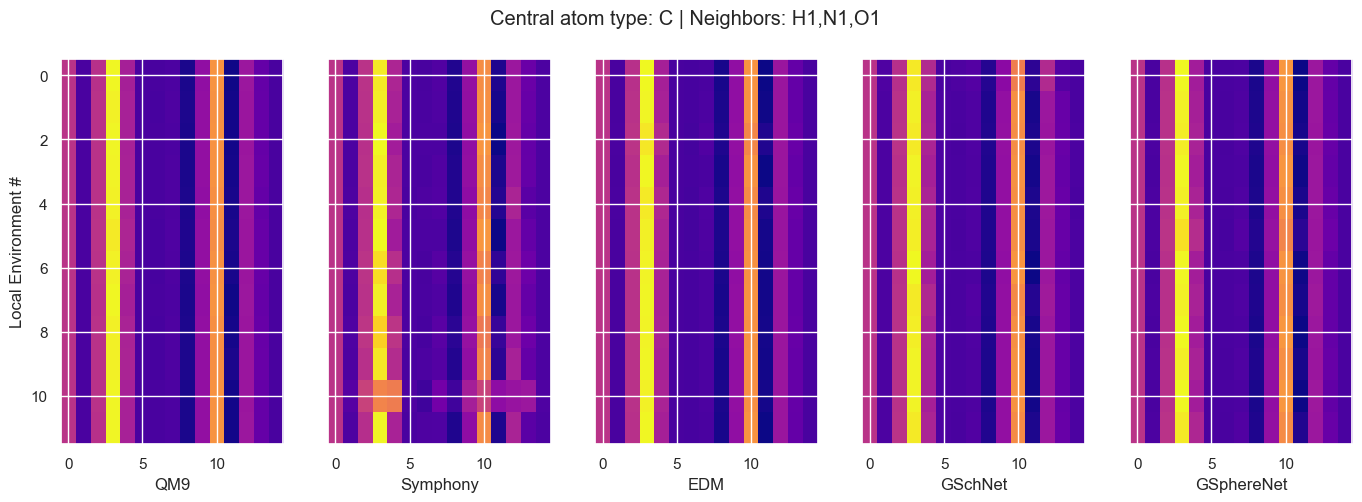

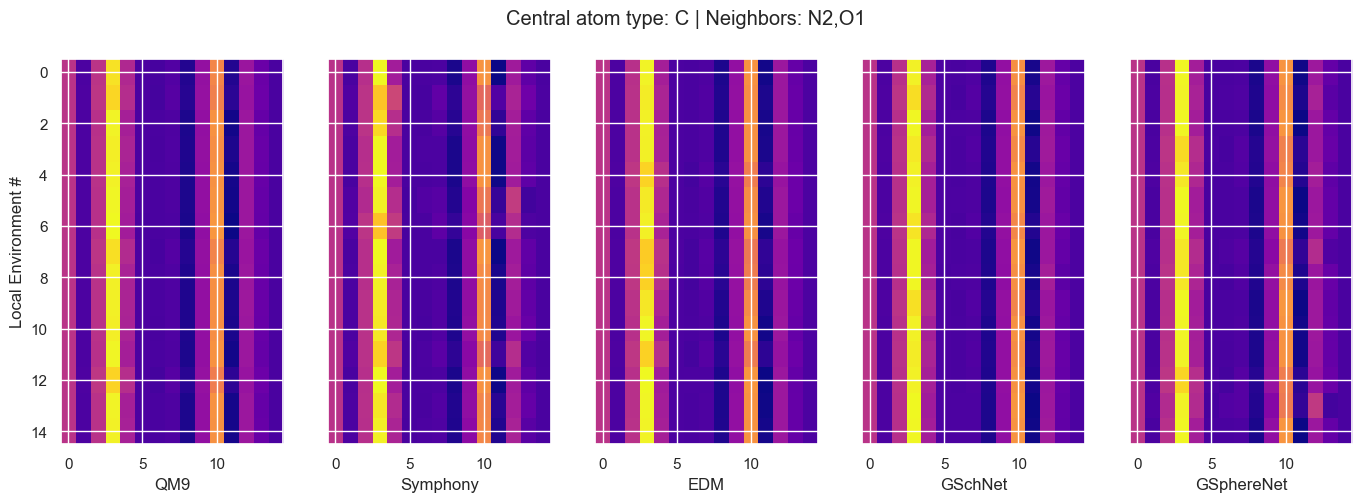

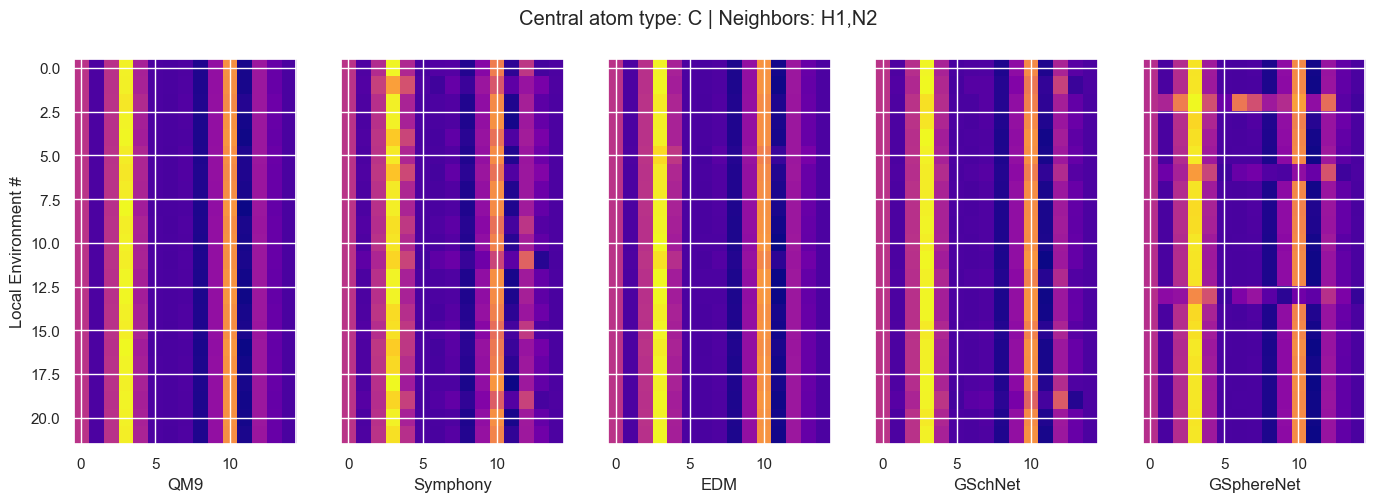

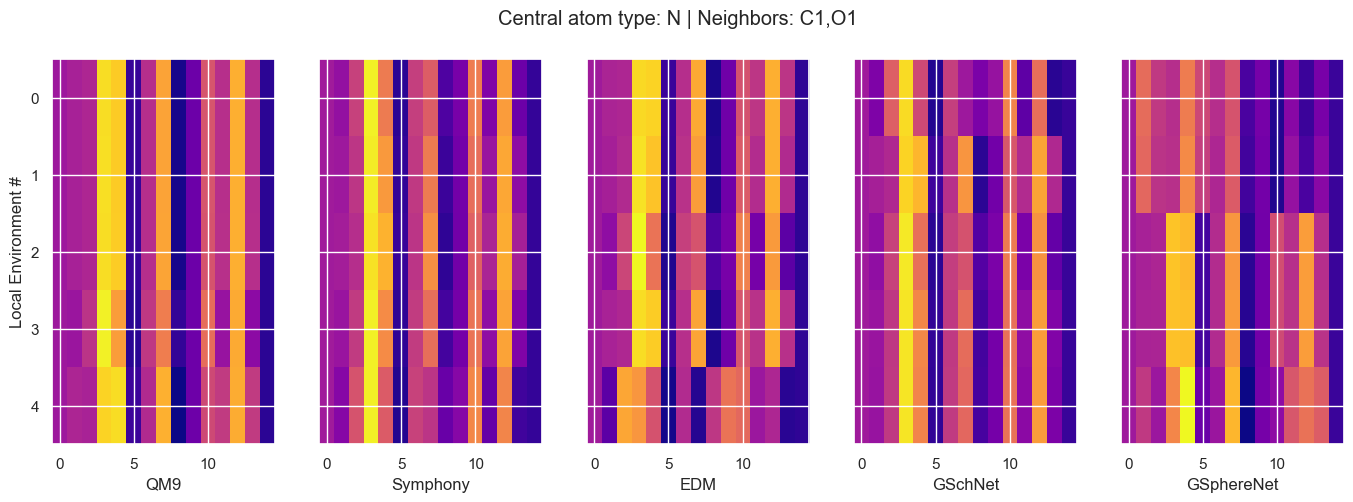

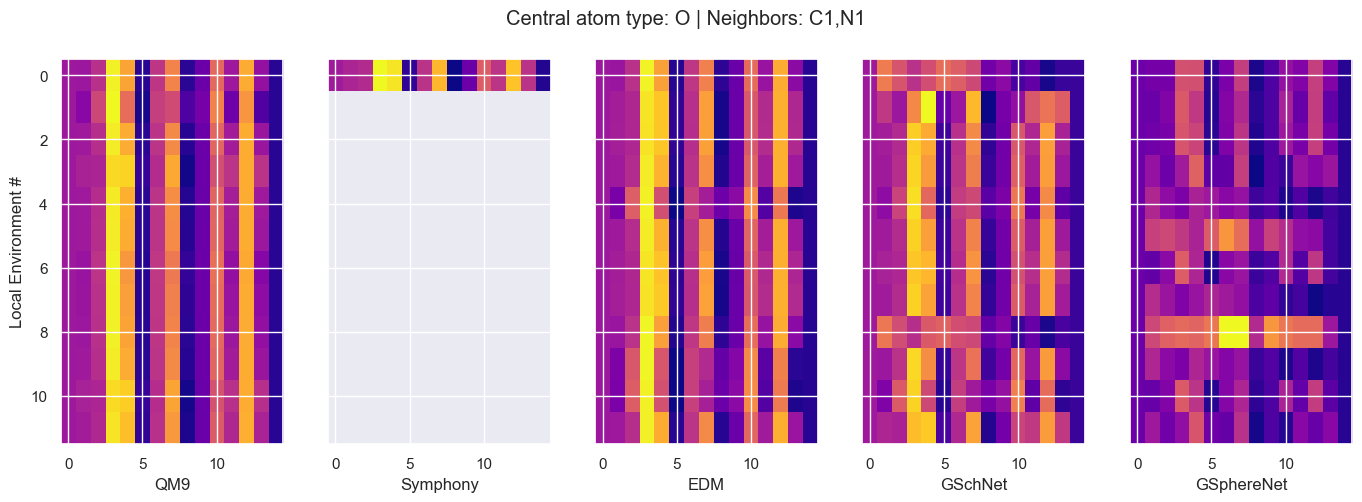

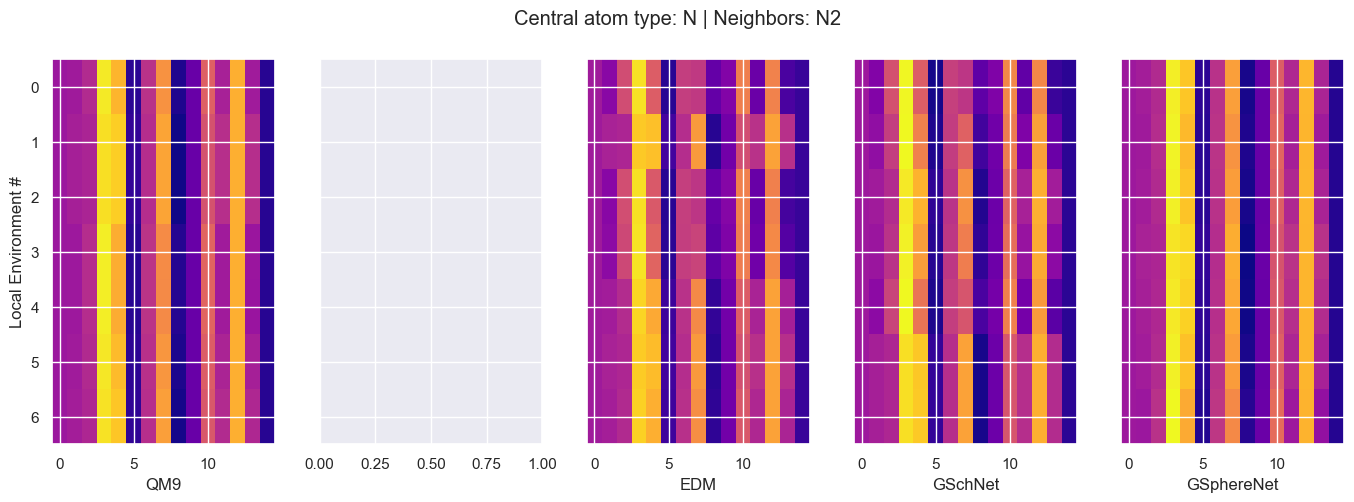

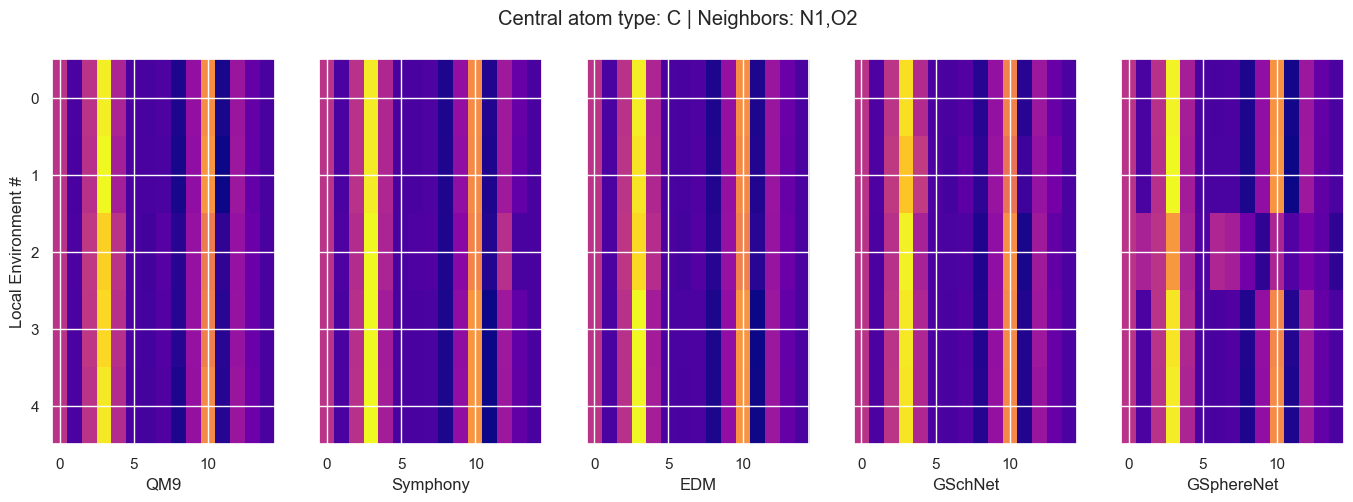

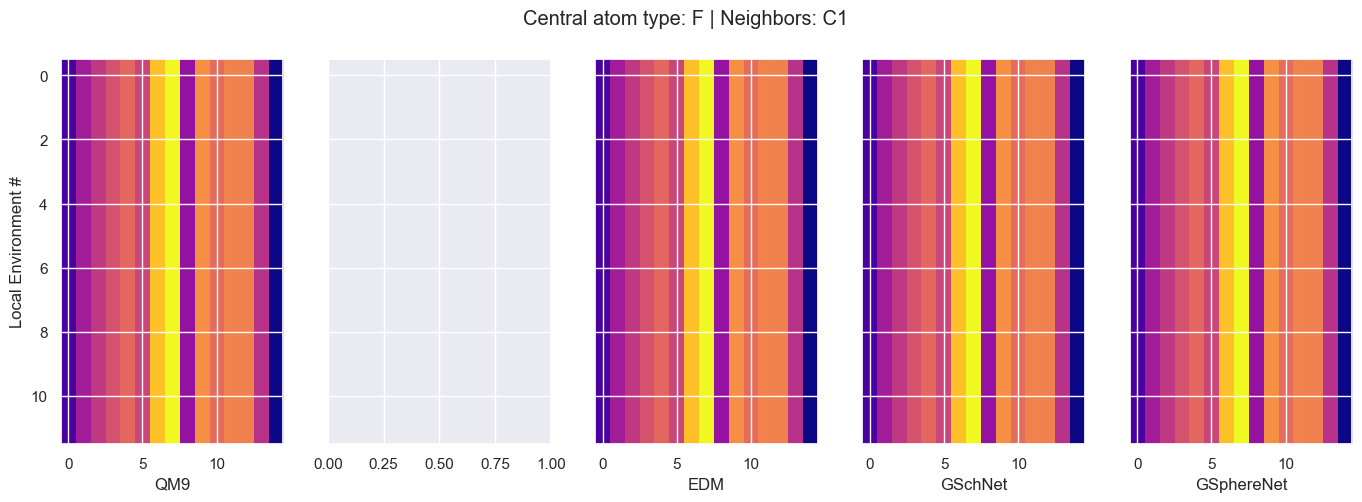

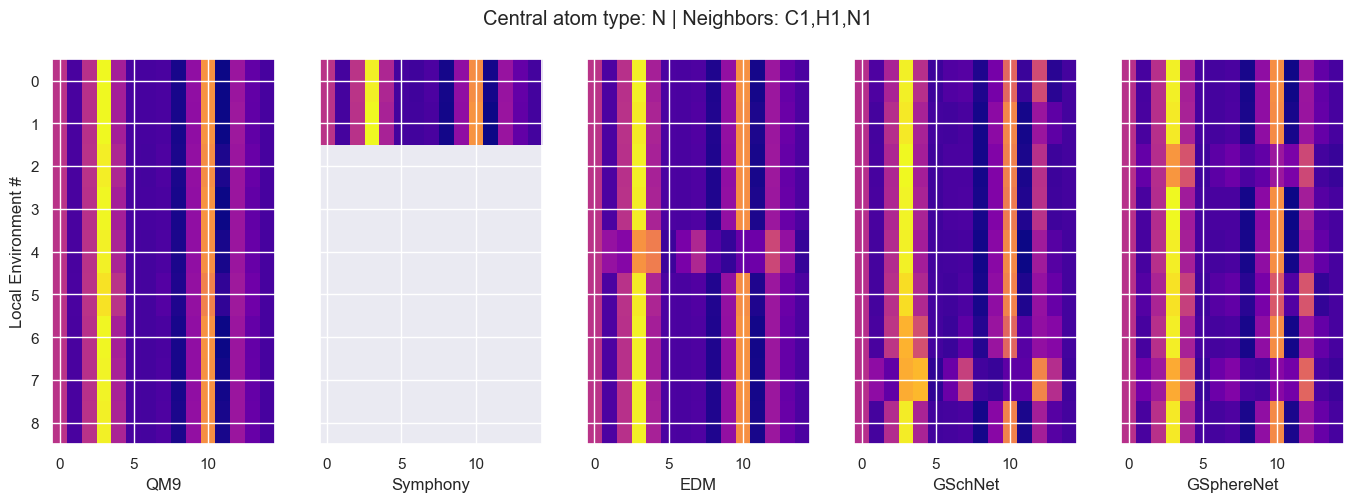

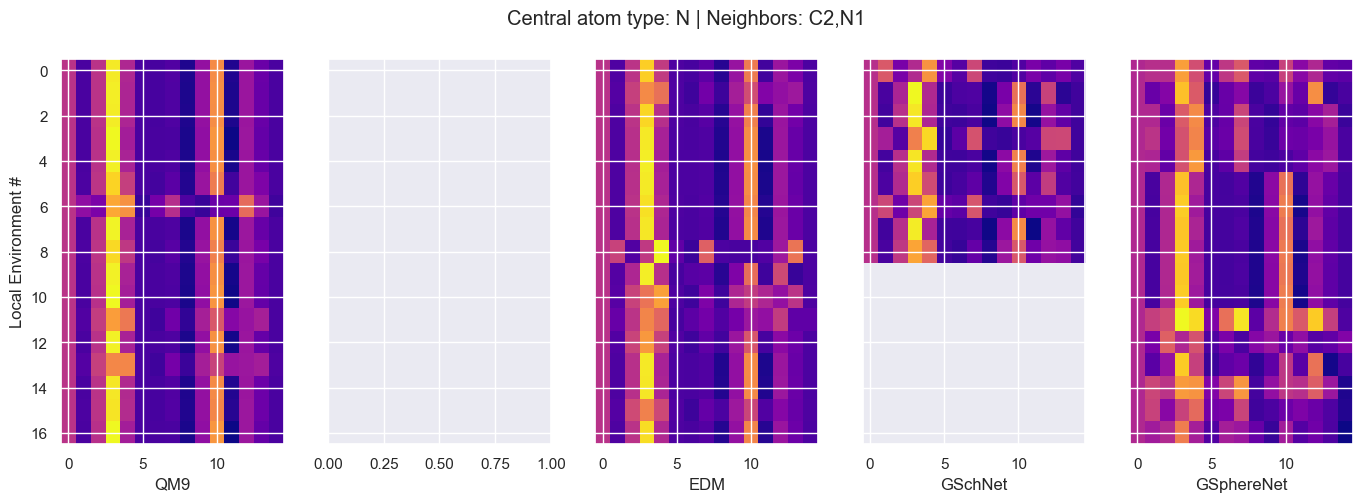

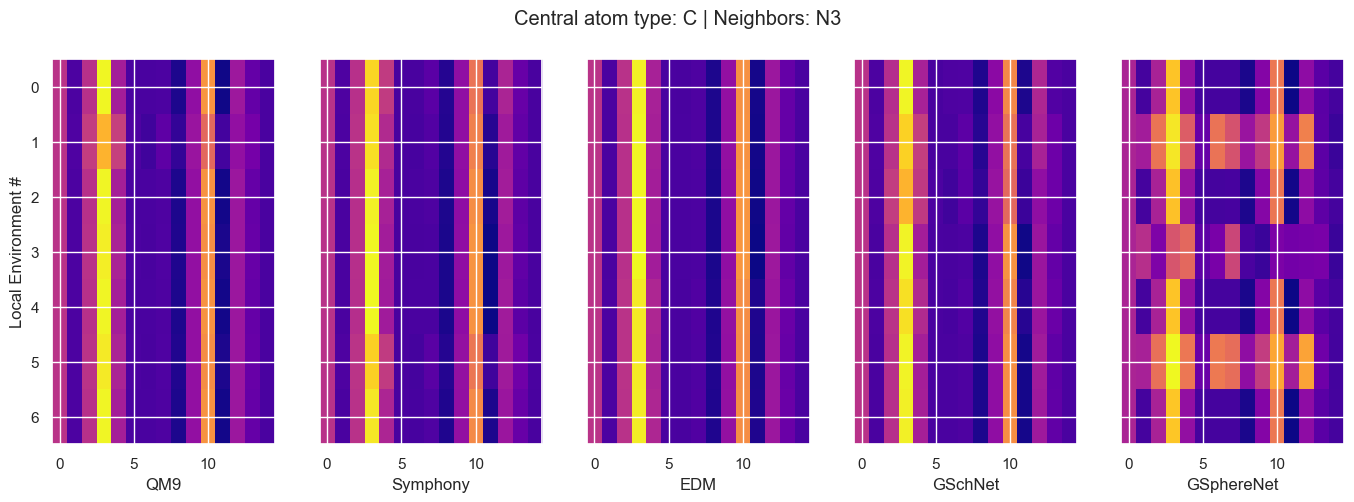

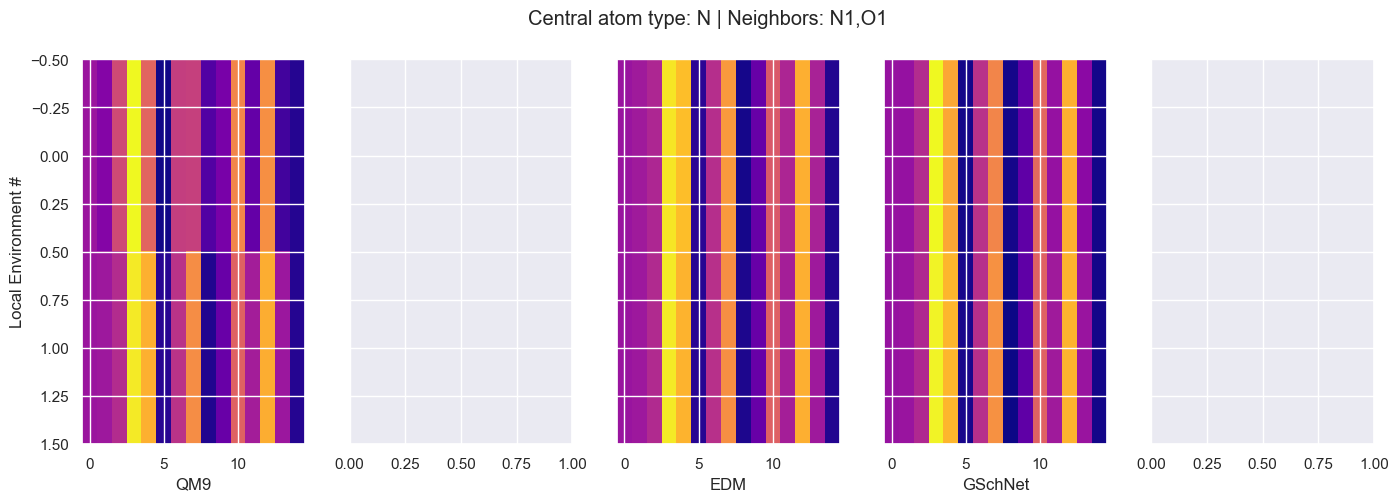

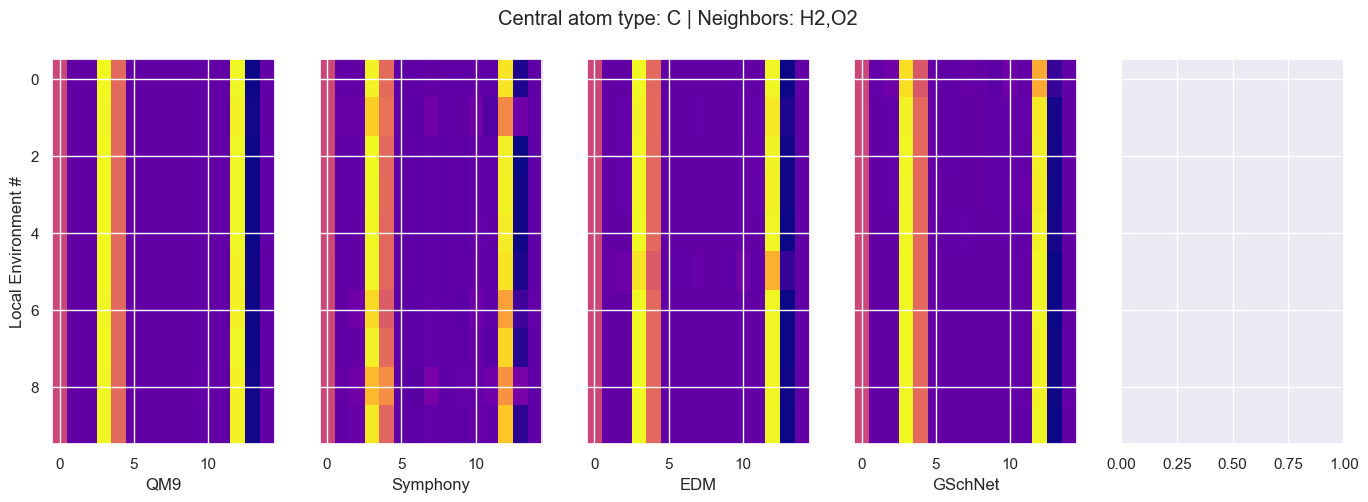

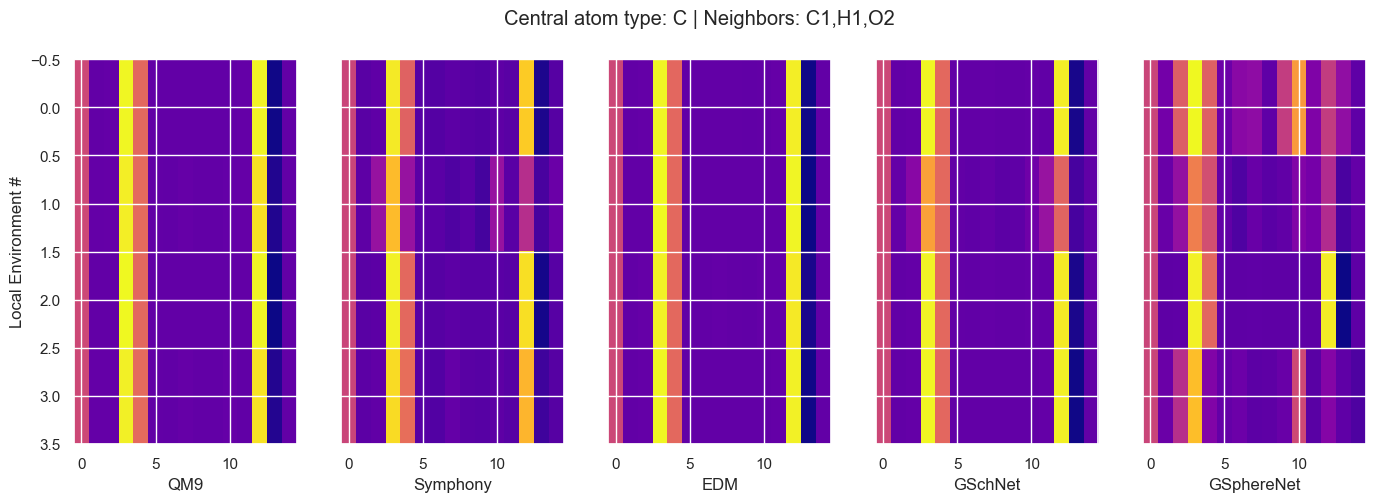

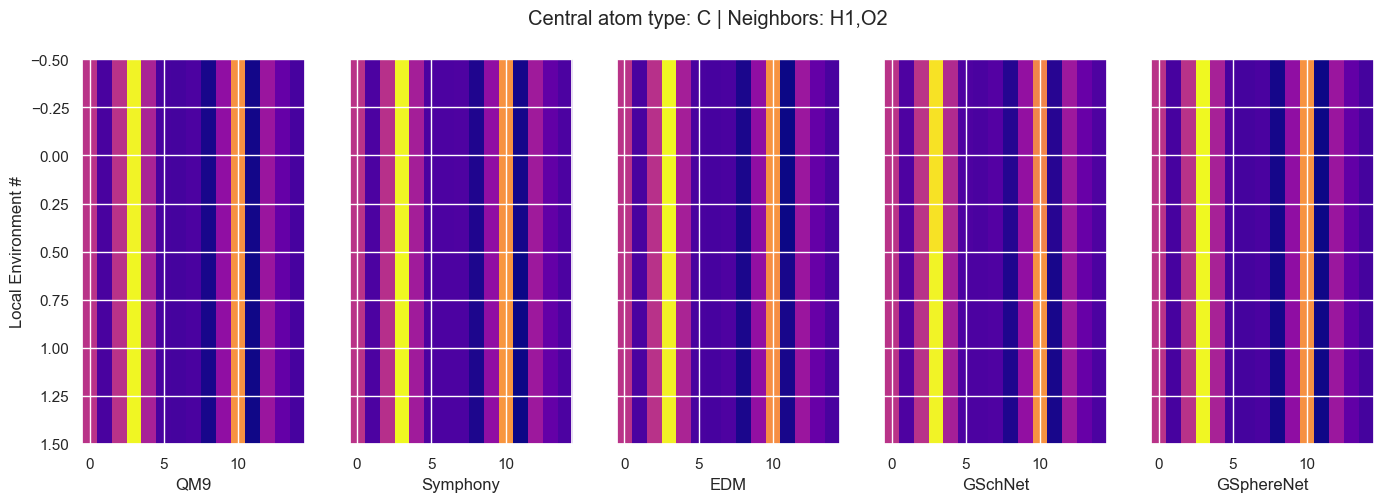

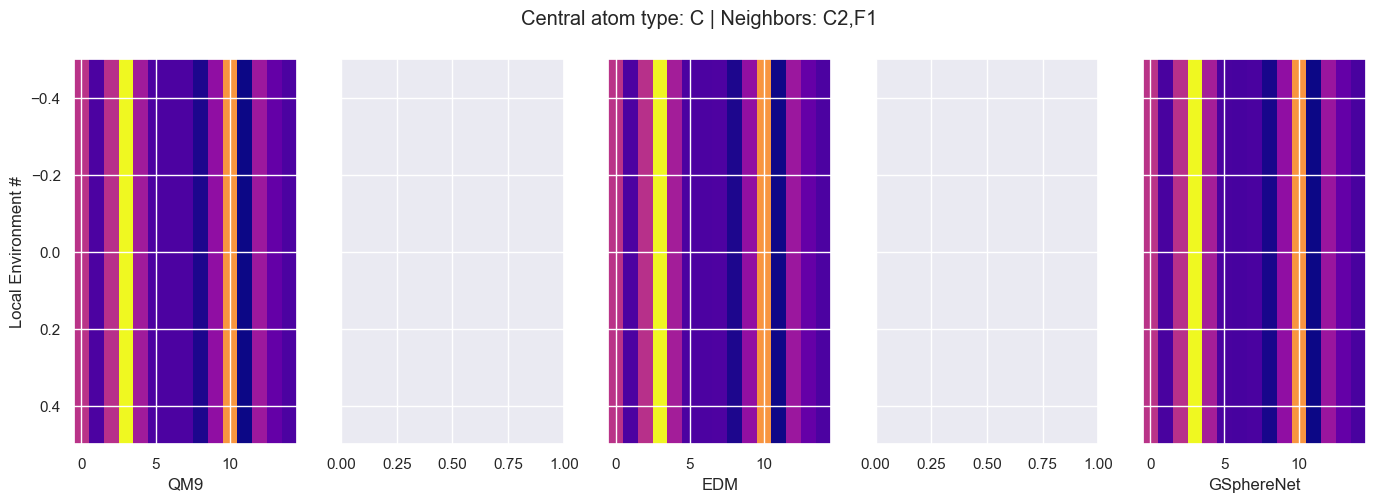

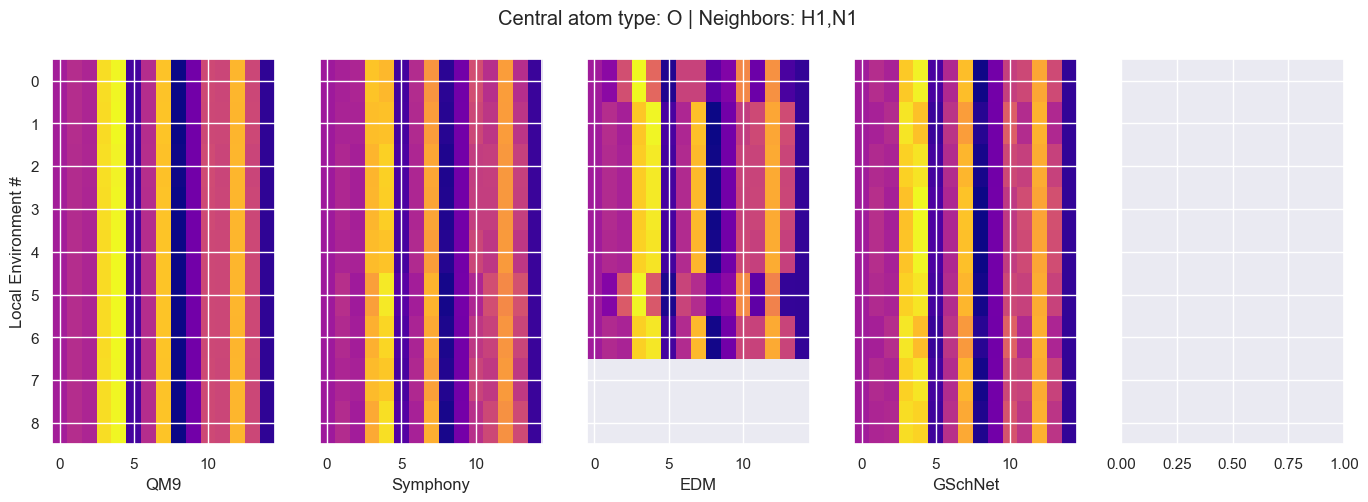

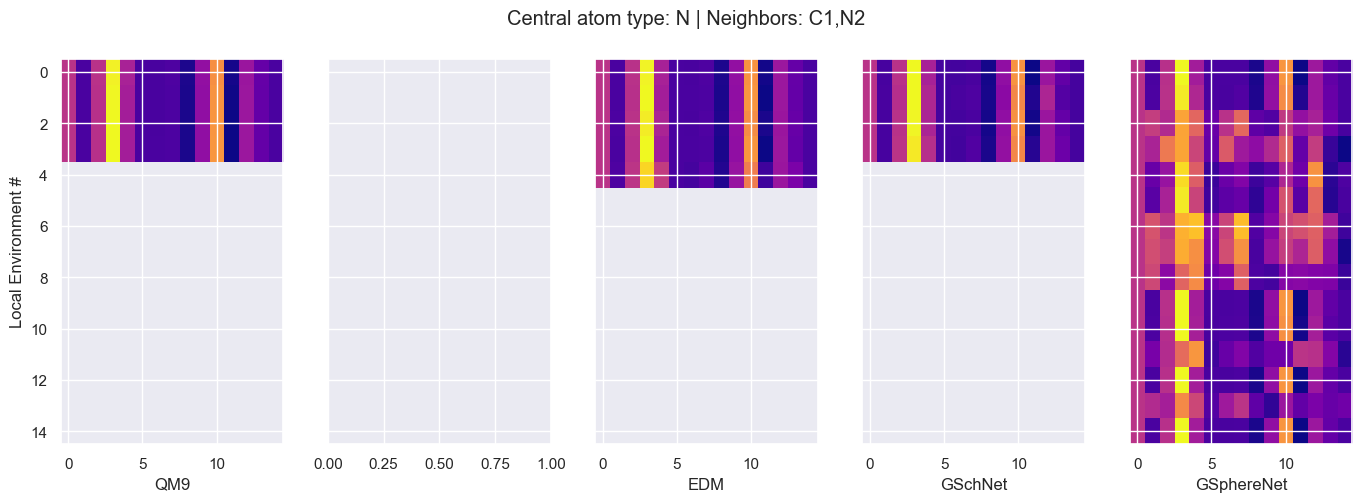

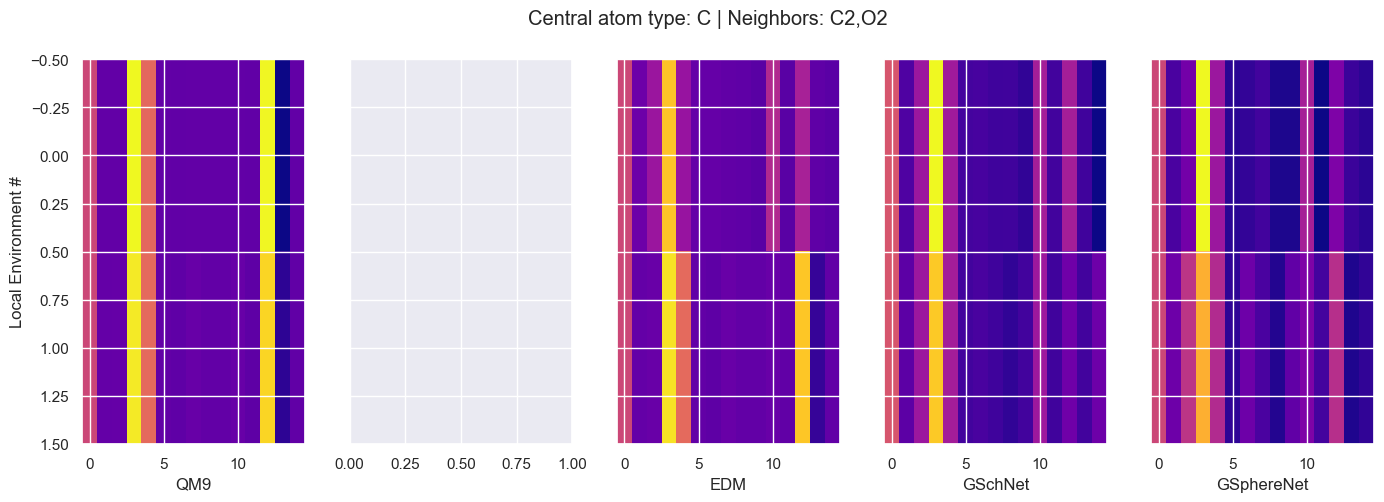

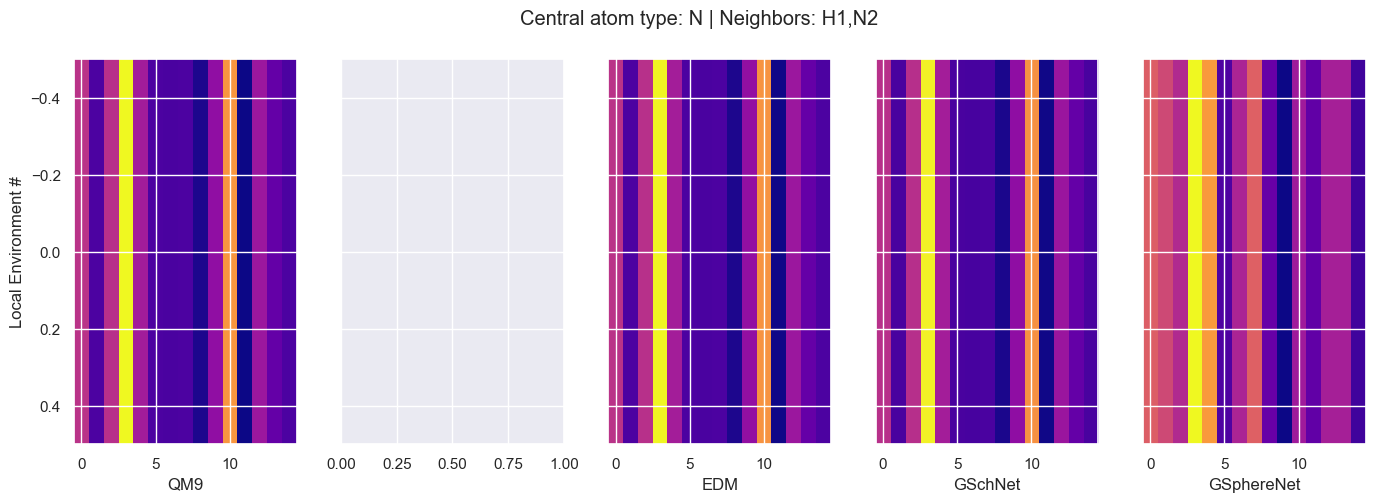

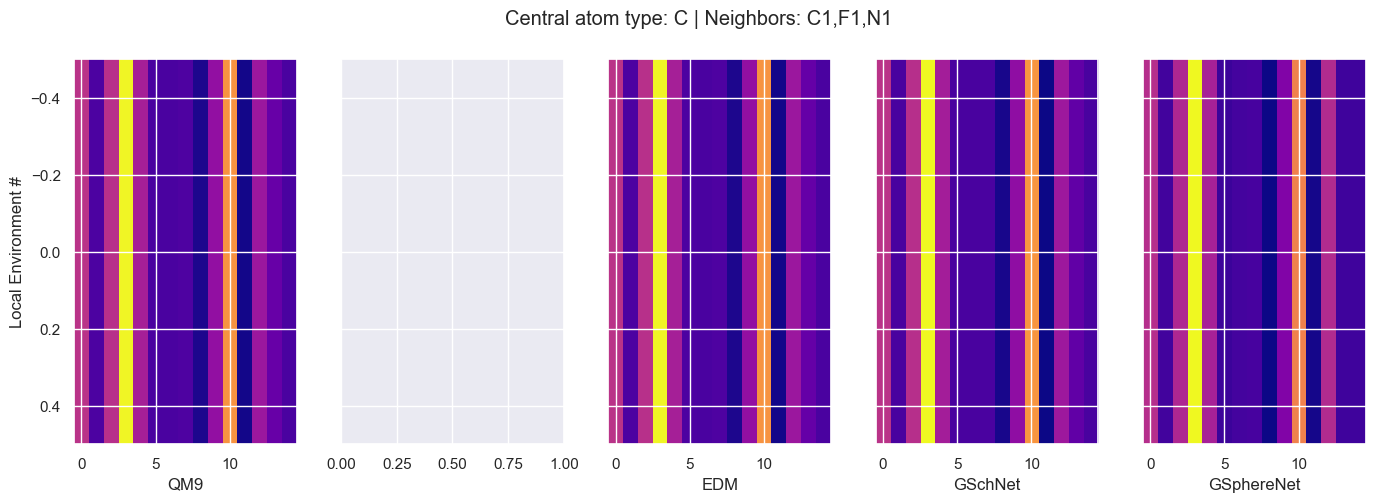

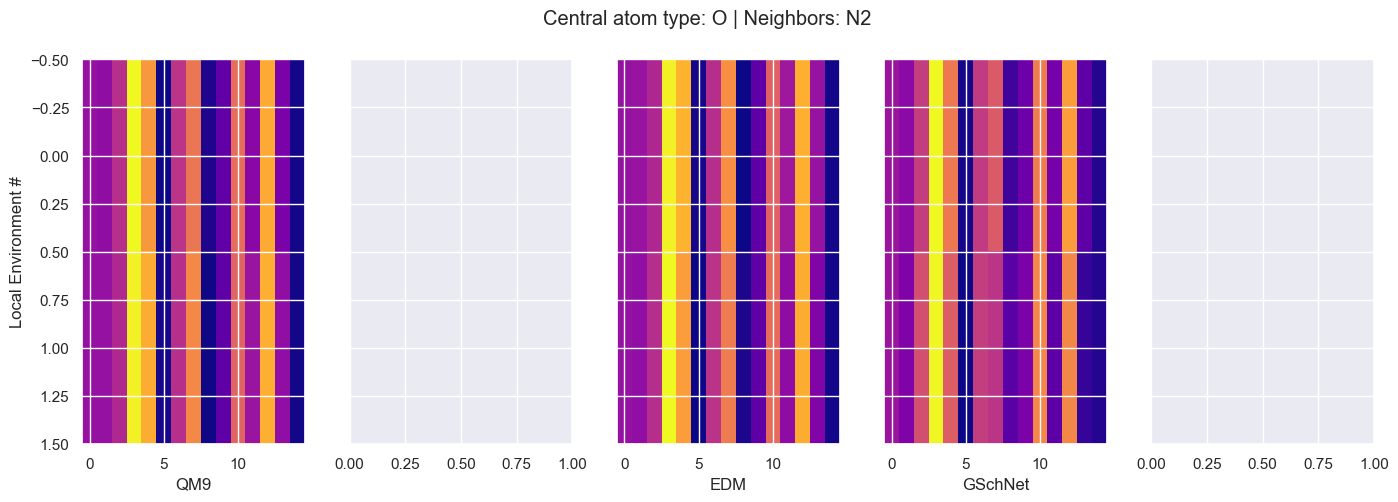

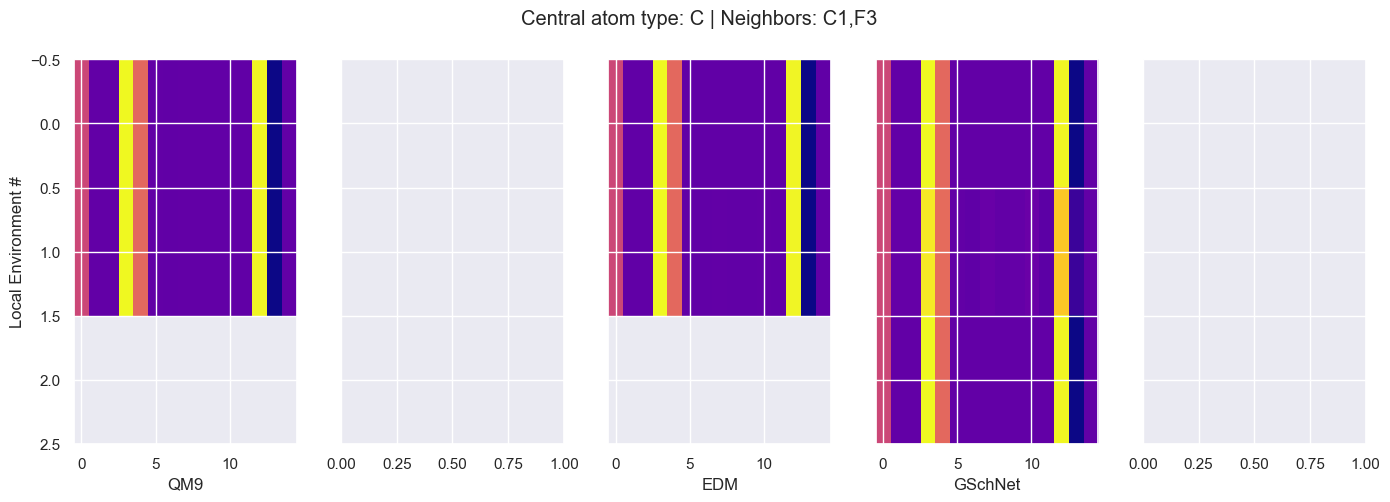

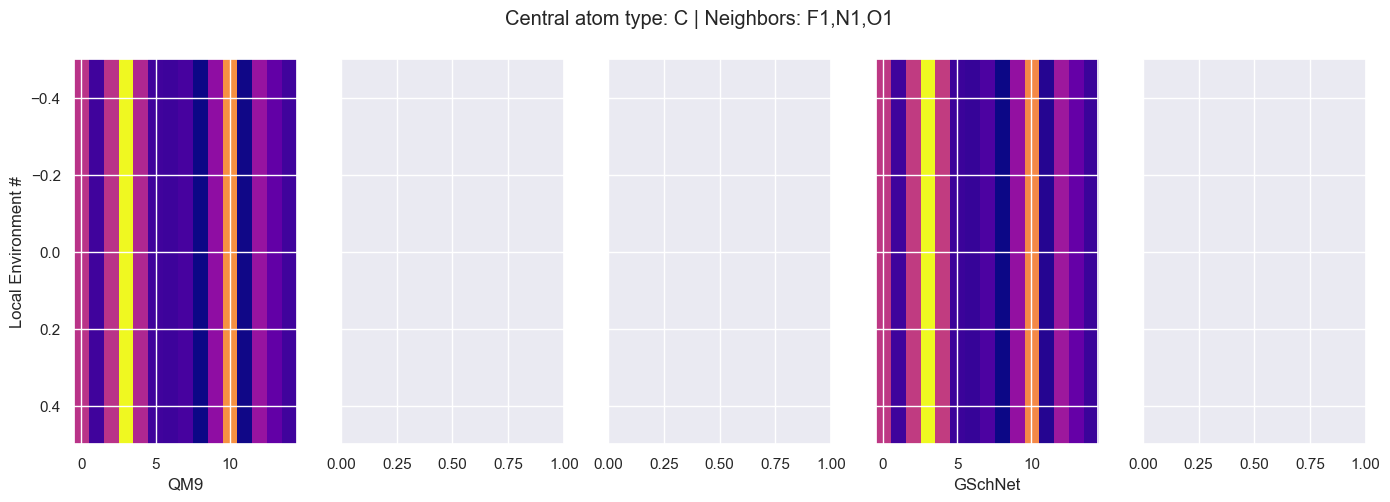

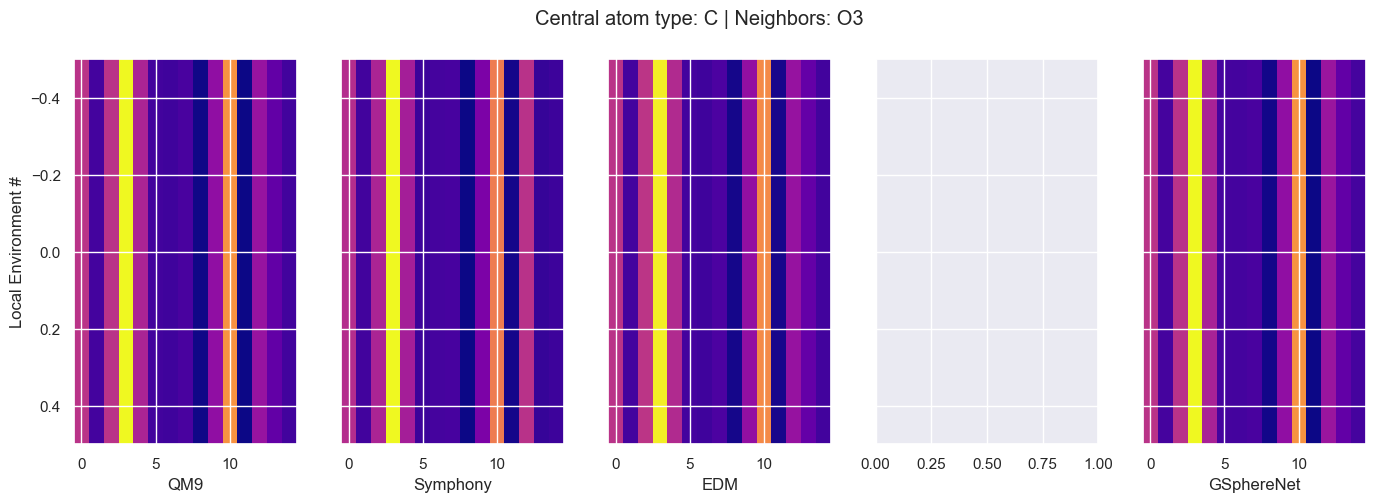

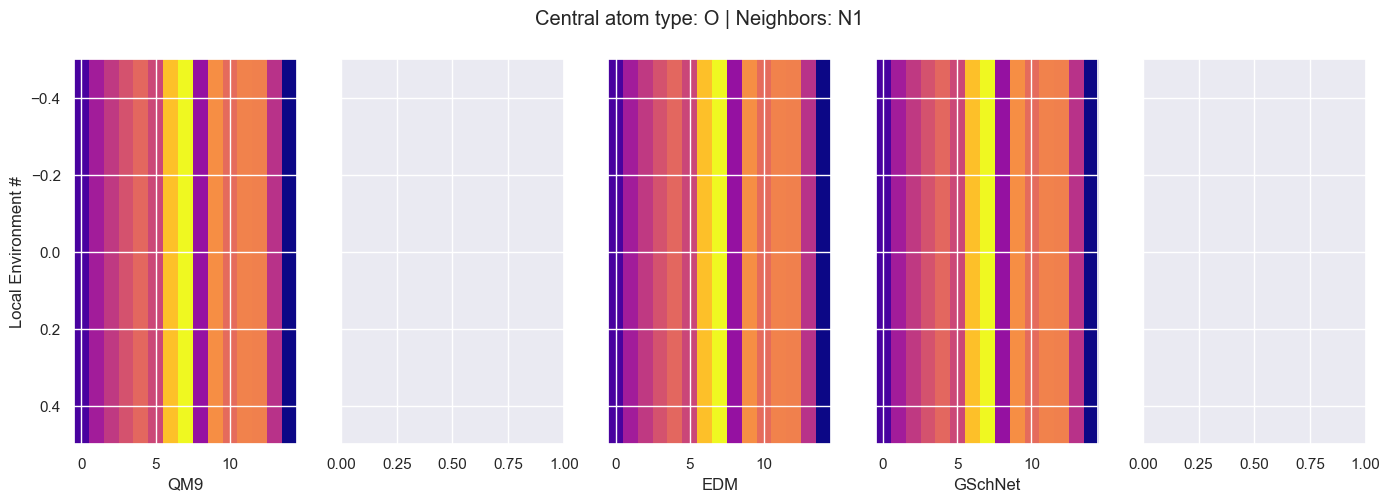

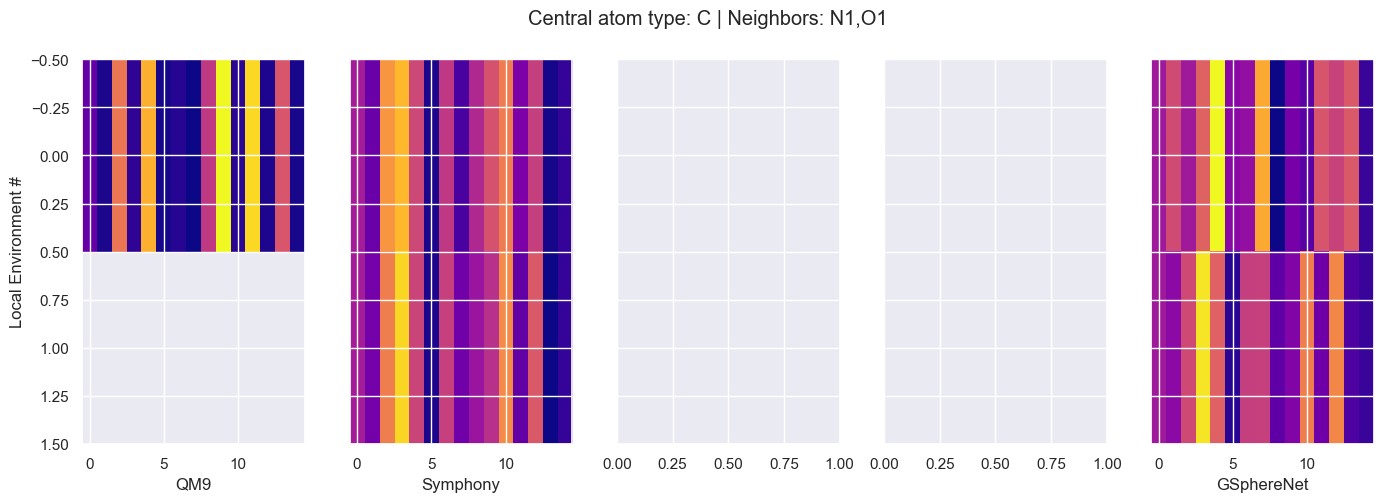

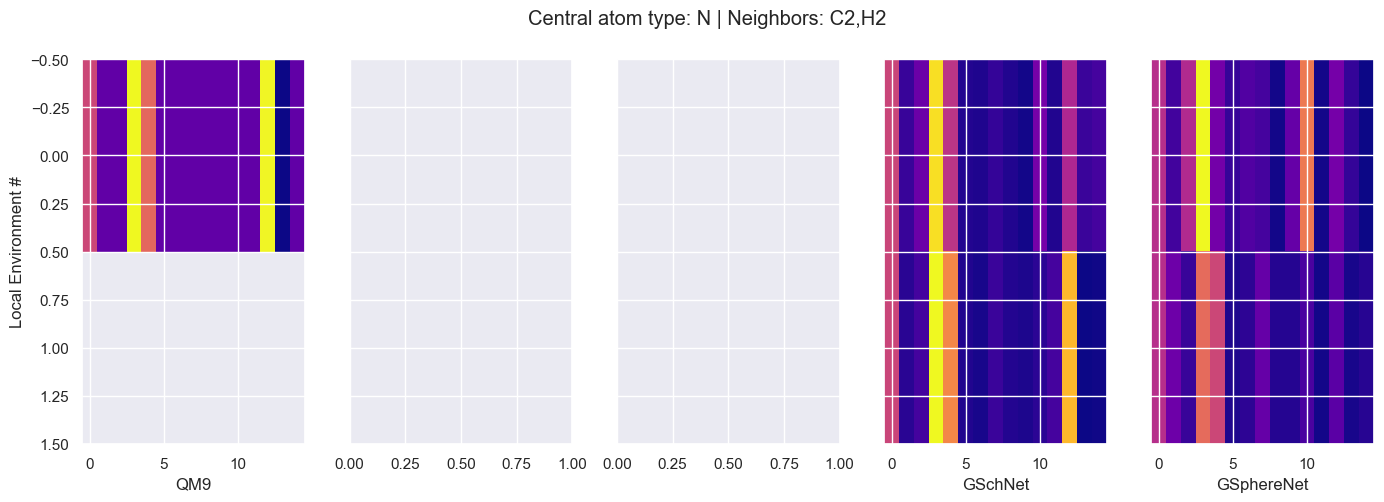

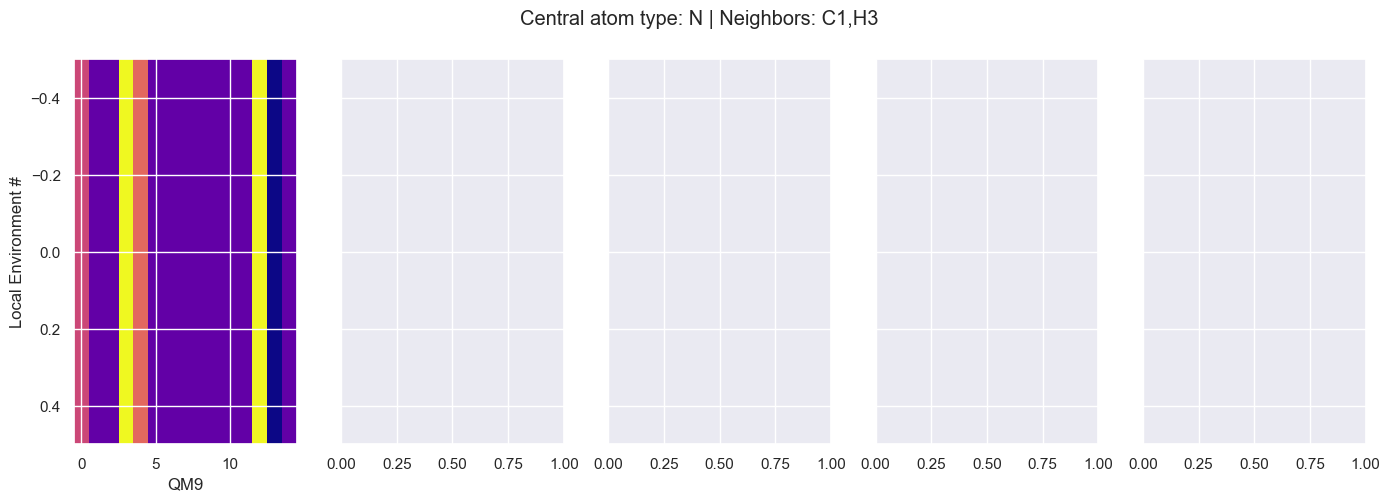

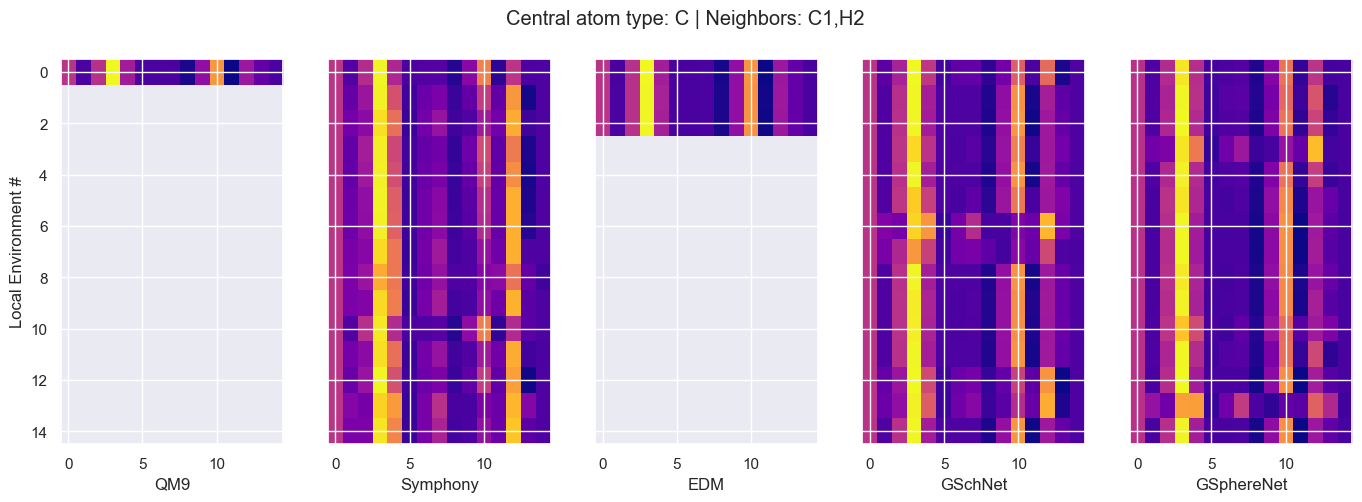

In [51]:
for environment, _ in sorted(bispectra["QM9"].items(), key=lambda x: len(x[1]), reverse=True):
    num_models = len(bispectra)
    # Set color scheme as plasma
    plt.rcParams['image.cmap'] = 'plasma'
    fig, axs = plt.subplots(ncols=num_models, figsize=(10 * num_models / 3, 5), sharey=True)
    
    for index, (model, model_bispectra) in enumerate(bispectra.items()):
        try:
            axs[index].imshow(model_bispectra[environment], aspect='auto')
            axs[index].set_xlabel(model)
        except KeyError:
            pass

    central_atom_type, neighbors = environment
    fig.suptitle(f"Central atom type: {central_atom_type} | Neighbors: {neighbors}")
    axs[0].set_ylabel("Local Environment #")
    plt.show()

MMD (Maximum Mean Discrepancy) of Bispectra:

In [17]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bispectra = {
    model: compute_maximum_mean_discrepancies_for_bispectra(bispectra["QM9"], model_bispectra, rng, batch_size, num_batches)
    for model, model_bispectra in bispectra.items()
    if model != "QM9"
}

The MMD distance of bispectra for central atom N and neighbors C1 is 0.00000
The MMD distance of bispectra for central atom C and neighbors C1,N1 is 0.01415
The MMD distance of bispectra for central atom C and neighbors C2,H1,N1 is 0.00683
The MMD distance of bispectra for central atom N and neighbors C2,H1 is 0.01266
The MMD distance of bispectra for central atom C and neighbors C3,N1 is 0.12043
The MMD distance of bispectra for central atom H and neighbors C1 is 0.00000
The MMD distance of bispectra for central atom H and neighbors N1 is 0.00000
The MMD distance of bispectra for central atom C and neighbors C3,H1 is 0.00548
The MMD distance of bispectra for central atom C and neighbors C2,H2 is 0.02117
The MMD distance of bispectra for central atom O and neighbors C1,H1 is -0.00048
The MMD distance of bispectra for central atom C and neighbors C1,N1,O1 is 0.00177
The MMD distance of bispectra for central atom H and neighbors O1 is 0.00000
The MMD distance of bispectra for central ato

KeyboardInterrupt: 

In [227]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def environment_to_str(environment: Tuple[str, str]) -> str:
    """Converts an environment to a string."""
    return [f"{environment[0]}: {environment[1]}"]

mmd_bispectra_df = pd.DataFrame(columns=["model", "environment", "mmd"])
for environment, _ in sorted(bispectra["QM9"].items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    for model in mmd_bispectra:
        mmd_bispectra_df = pd.concat(
            [
                mmd_bispectra_df,
                pd.DataFrame.from_records(
                    {"model": model, "environment": environment_to_str(environment), "mmd": mmd_bispectra[model][environment]}
                ),
            ],
            ignore_index=True,
        )
        
mmd_bispectra_df["mmd"] = mmd_bispectra_df["mmd"].astype(float)
mmd_bispectra_df

model  environment           mmd
0                 Symphony        H: C1  1.514854e-07
1   Symphony (UFF relaxed)        H: C1  1.514854e-07
2                      EDM        H: C1  1.514854e-07
3        EDM (UFF relaxed)        H: C1  1.514854e-07
4                 Symphony     C: C2,H2  2.117443e-02
5   Symphony (UFF relaxed)     C: C2,H2  2.542730e-02
6                      EDM     C: C2,H2  8.062521e-04
7        EDM (UFF relaxed)     C: C2,H2  3.328541e-03
8                 Symphony     C: C1,H3  5.012622e-02
9   Symphony (UFF relaxed)     C: C1,H3  1.514854e-07
10                     EDM     C: C1,H3  1.514854e-07
11       EDM (UFF relaxed)     C: C1,H3  1.514854e-07
12                Symphony     C: C3,H1  5.480669e-03
13  Symphony (UFF relaxed)     C: C3,H1  3.928416e-02
14                     EDM     C: C3,H1  5.029087e-03
15       EDM (UFF relaxed)     C: C3,H1  1.119698e-02
16                Symphony        O: C2  1.759784e-03
17  Symphony (UFF relaxed)        O: C2  1.950173e-03
18                     EDM        O: C2  8.615983e-04
19       EDM (UFF relaxed)        O: C2  7.748705e-04
20                Symphony        H: N1  1.514854e-07
21  Symphony (UFF relaxed)        H: N1  1.514854e-07
22                     EDM        H: N1  1.514854e-07
23       EDM (UFF relaxed)        H: N1  1.514854e-07
24                Symphony  C: C2,H1,O1  2.700905e-02
25  Symphony (UFF relaxed)  C: C2,H1,O1  1.055832e-02
26                     EDM  C: C2,H1,O1  3.732116e-03
27       EDM (UFF relaxed)  C: C2,H1,O1  8.057744e-03
28                Symphony        O: C1  1.514854e-07
29  Symphony (UFF relaxed)        O: C1  1.514854e-07
30                     EDM        O: C1  1.514854e-07
31       EDM (UFF relaxed)        O: C1  1.514854e-07
32                Symphony        H: O1  1.514854e-07
33  Symphony (UFF relaxed)        H: O1  1.514854e-07
34                     EDM        H: O1  1.514854e-07
35       EDM (UFF relaxed)        H: O1  1.514854e-07
36                Symphony  C: C1,H2,O1  8.353572e-02
37  Symphony (UFF relaxed)  C: C1,H2,O1  3.842298e-03
38                     EDM  C: C1,H2,O1  7.713831e-03
39       EDM (UFF relaxed)  C: C1,H2,O1  6.384213e-03

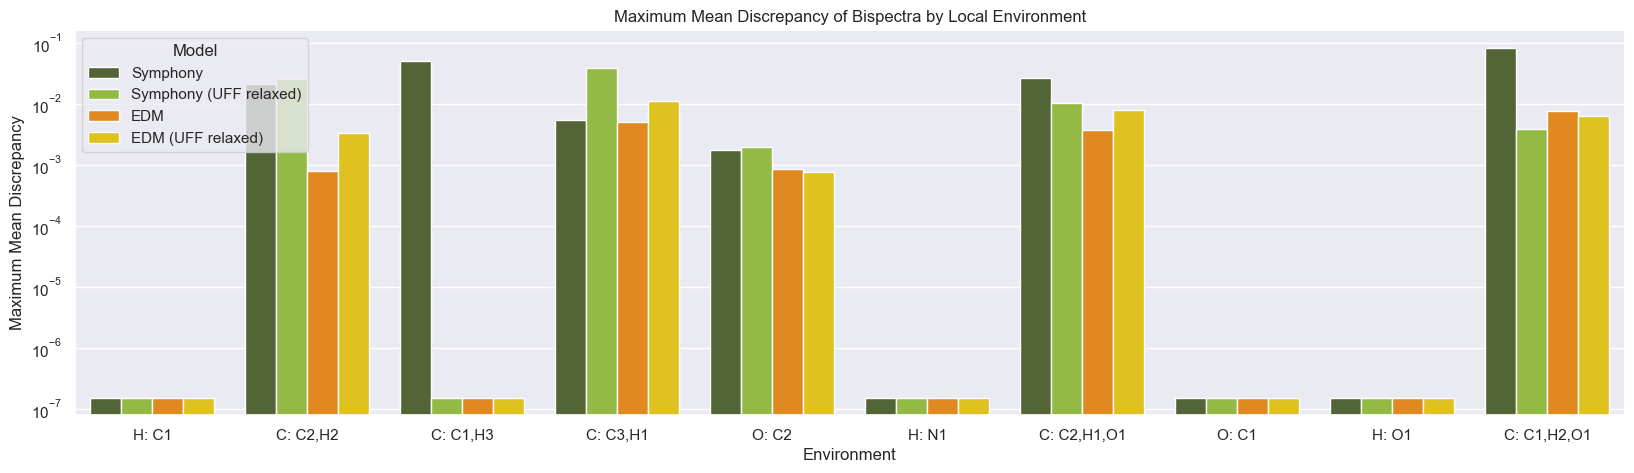

In [240]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="environment", y="mmd", hue="model", data=mmd_bispectra_df, ax=ax, palette=model_palette)
plt.xlabel("Environment")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bispectra by Local Environment")
plt.show()

Compute all bond lengths:

In [18]:
bond_dists = {
    model: compute_bond_lengths(molecules_dir)
    for model, molecules_dir in generated_and_relaxed_paths.items()
}

Distribution of Bond Lengths:

In [22]:
bond_length_counts = jax.tree_map(np.size, bond_dists["QM9"])
sorted_bond_length_counts = sorted(
    bond_length_counts.items(), key=lambda x: x[1], reverse=True
)

print("Bond counts:")
total_counts = sum(bond_length_counts.values())
sum_counts_so_far = 0
for bond_key, count in sorted_bond_length_counts:
    sum_counts_so_far += count
    print(f"{bond_key }: {count} (cdf: {sum_counts_so_far / total_counts:.3f})")

Bond counts:
('C', 'H', 1.0): 1103196 (cdf: 0.444)
('C', 'C', 1.0): 662158 (cdf: 0.710)
('C', 'O', 1.0): 188304 (cdf: 0.786)
('C', 'N', 1.0): 139383 (cdf: 0.842)
('H', 'N', 1.0): 73049 (cdf: 0.872)
('C', 'O', 2.0): 55898 (cdf: 0.894)
('C', 'N', 1.5): 55247 (cdf: 0.917)
('H', 'O', 1.0): 52204 (cdf: 0.938)
('C', 'C', 1.5): 43463 (cdf: 0.955)
('C', 'N', 2.0): 20618 (cdf: 0.963)
('C', 'C', 3.0): 19497 (cdf: 0.971)
('C', 'C', 2.0): 17987 (cdf: 0.978)
('C', 'N', 3.0): 17475 (cdf: 0.985)
('C', 'O', 1.5): 14893 (cdf: 0.991)
('N', 'N', 1.5): 10793 (cdf: 0.996)
('N', 'O', 1.5): 4825 (cdf: 0.998)
('C', 'F', 1.0): 3296 (cdf: 0.999)
('N', 'O', 1.0): 2038 (cdf: 1.000)
('N', 'O', 2.0): 177 (cdf: 1.000)
('N', 'N', 3.0): 112 (cdf: 1.000)
('N', 'N', 2.0): 53 (cdf: 1.000)
('N', 'N', 1.0): 16 (cdf: 1.000)


Maximum Mean Discrepancy of Bond Lengths:

In [6]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bond_lengths = {
    model: compute_maximum_mean_discrepancies_for_bond_lengths(bond_dists["QM9"], model_bond_dists, rng, batch_size, num_batches)
    for model, model_bond_dists in bond_dists.items()
    if model != "QM9"
}

The MMD distance of C-C (bond type 1.0) bond length distributions is 0.05178
The MMD distance of C-C (bond type 1.5) bond length distributions is 0.04979
The MMD distance of C-C (bond type 2.0) bond length distributions is 0.20536
The MMD distance of C-C (bond type 3.0) bond length distributions is 0.02390
The MMD distance of C-H (bond type 1.0) bond length distributions is 0.02918
The MMD distance of C-N (bond type 1.0) bond length distributions is 0.09199
The MMD distance of C-N (bond type 1.5) bond length distributions is 0.03933
The MMD distance of C-N (bond type 2.0) bond length distributions is 0.13364
The MMD distance of C-N (bond type 3.0) bond length distributions is 0.02949
The MMD distance of C-O (bond type 1.0) bond length distributions is 0.02839
The MMD distance of C-O (bond type 1.5) bond length distributions is 0.06809
The MMD distance of C-O (bond type 2.0) bond length distributions is 0.10553
The MMD distance of H-N (bond type 1.0) bond length distributions is 0.01718

In [57]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def bond_key_as_string(bond_key: Tuple[int, int, int]) -> str:
    return [f"{bond_key[0]}-{bond_key[1]}: {bond_key[2]}"]


mmd_df = pd.DataFrame(columns=["model", "bond_key", "mmd"])
for bond_key, _ in sorted_bond_length_counts[:10]:
    for model in mmd_bond_lengths:
        mmd_df = pd.concat(
            [
                mmd_df,
                pd.DataFrame.from_records(
                    {"model": model, "bond_key": bond_key_as_string(bond_key), "mmd": mmd_bond_lengths[model][bond_key]}
                ),
            ],
            ignore_index=True,
        )

mmd_df["mmd"] = mmd_df["mmd"].astype(float)
mmd_df

model  bond_key       mmd
0                 Symphony  C-H: 1.0  0.029176
1   Symphony (UFF relaxed)  C-H: 1.0  0.035075
2                      EDM  C-H: 1.0  0.000139
3        EDM (UFF relaxed)  C-H: 1.0  0.047744
4                 Symphony  C-C: 1.0  0.051778
5   Symphony (UFF relaxed)  C-C: 1.0  0.023132
6                      EDM  C-C: 1.0  0.000634
7        EDM (UFF relaxed)  C-C: 1.0  0.009437
8                 Symphony  C-O: 1.0  0.028387
9   Symphony (UFF relaxed)  C-O: 1.0  0.028465
10                     EDM  C-O: 1.0  0.000253
11       EDM (UFF relaxed)  C-O: 1.0  0.026907
12                Symphony  C-N: 1.0  0.091986
13  Symphony (UFF relaxed)  C-N: 1.0  0.036028
14                     EDM  C-N: 1.0  0.002770
15       EDM (UFF relaxed)  C-N: 1.0  0.036335
16                Symphony  H-N: 1.0  0.017175
17  Symphony (UFF relaxed)  H-N: 1.0  0.188978
18                     EDM  H-N: 1.0  0.000420
19       EDM (UFF relaxed)  H-N: 1.0  0.193756
20                Symphony  C-O: 2.0  0.105526
21  Symphony (UFF relaxed)  C-O: 2.0  0.312696
22                     EDM  C-O: 2.0  0.000263
23       EDM (UFF relaxed)  C-O: 2.0  0.243862
24                Symphony  C-N: 1.5  0.039333
25  Symphony (UFF relaxed)  C-N: 1.5  0.032619
26                     EDM  C-N: 1.5  0.001352
27       EDM (UFF relaxed)  C-N: 1.5  0.029155
28                Symphony  H-O: 1.0  0.039992
29  Symphony (UFF relaxed)  H-O: 1.0  0.255961
30                     EDM  H-O: 1.0  0.001042
31       EDM (UFF relaxed)  H-O: 1.0  0.170359
32                Symphony  C-C: 1.5  0.049791
33  Symphony (UFF relaxed)  C-C: 1.5  0.025866
34                     EDM  C-C: 1.5  0.001029
35       EDM (UFF relaxed)  C-C: 1.5  0.027257
36                Symphony  C-N: 2.0  0.133642
37  Symphony (UFF relaxed)  C-N: 2.0  0.119125
38                     EDM  C-N: 2.0  0.004236
39       EDM (UFF relaxed)  C-N: 2.0  0.118979

NameError: name 'mmd_df' is not defined

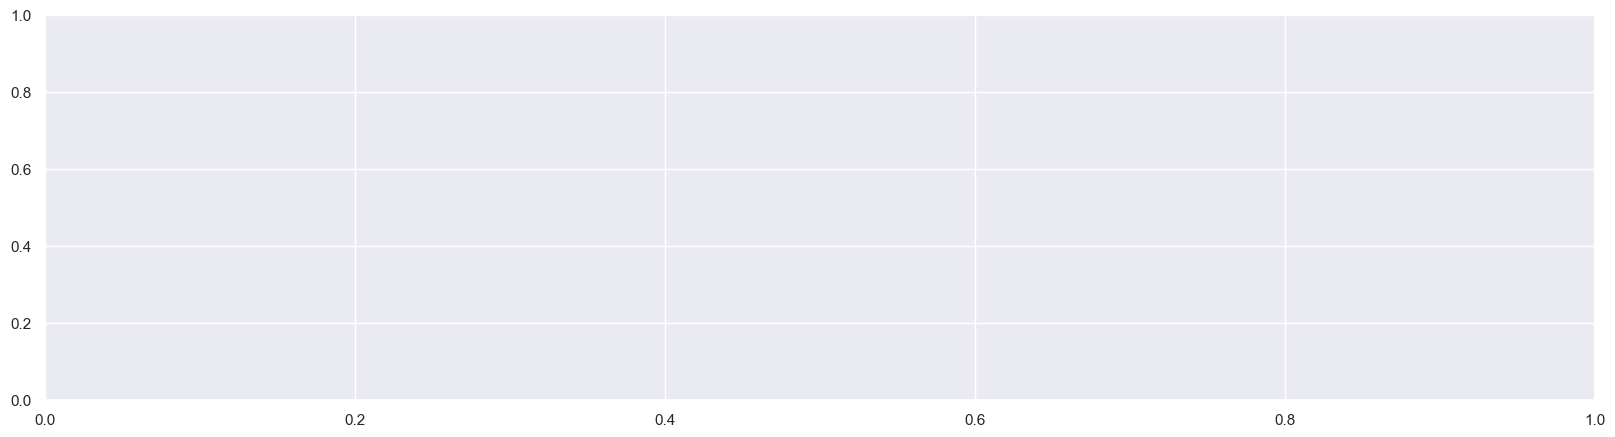

In [52]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="bond_key", y="mmd", hue="model", data=mmd_df, ax=ax,
            palette=model_palette)
plt.xlabel("Bond Type")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bond Lengths")
plt.show()

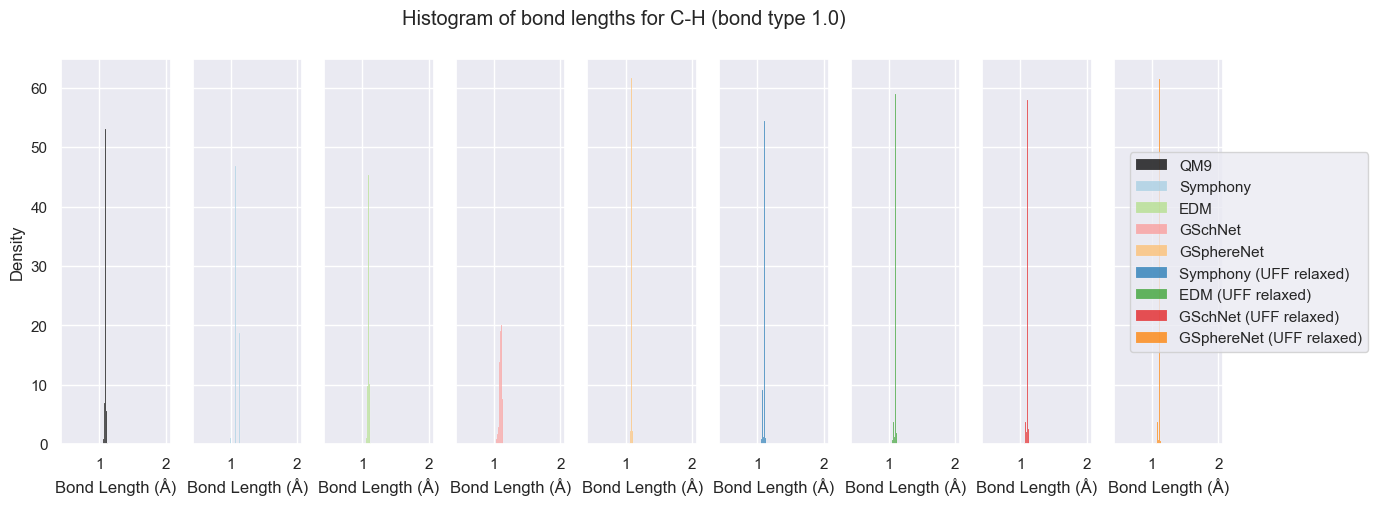

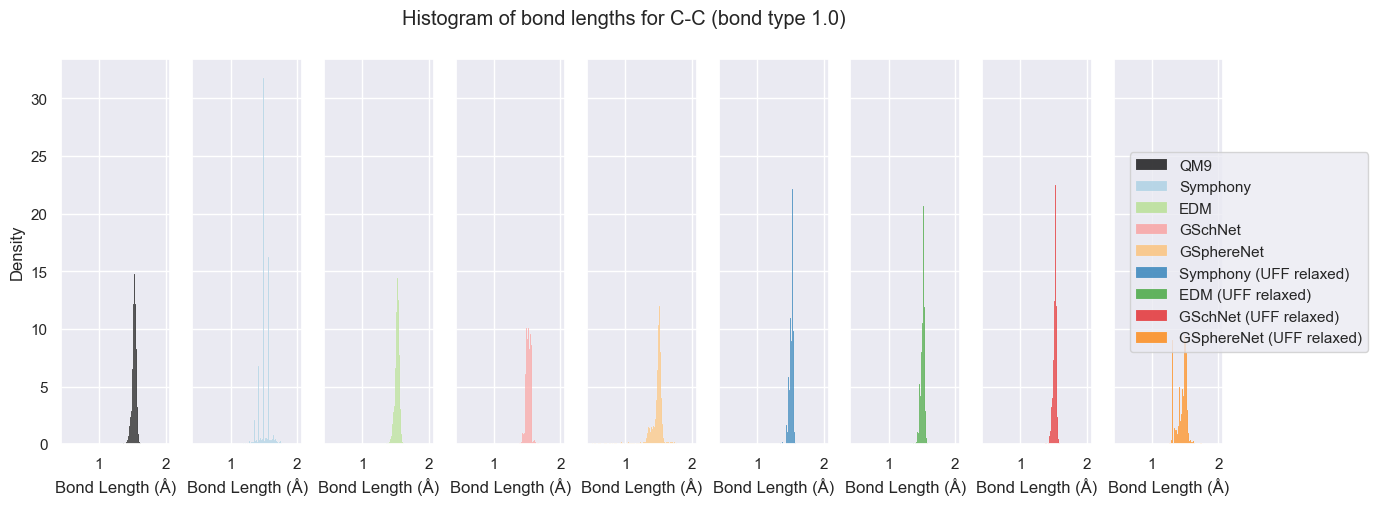

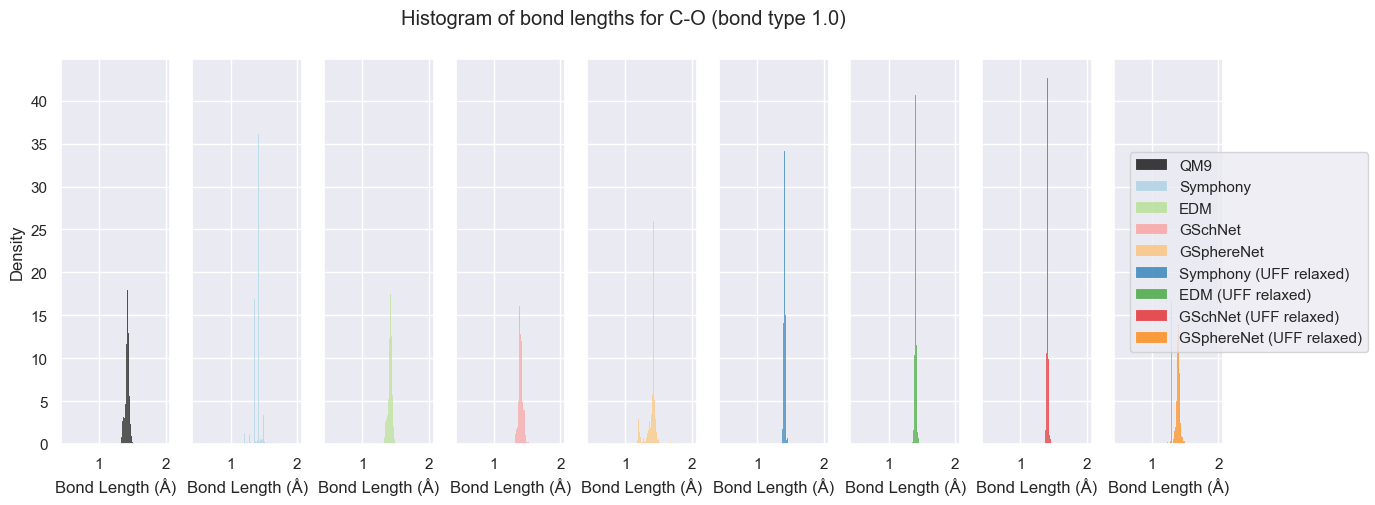

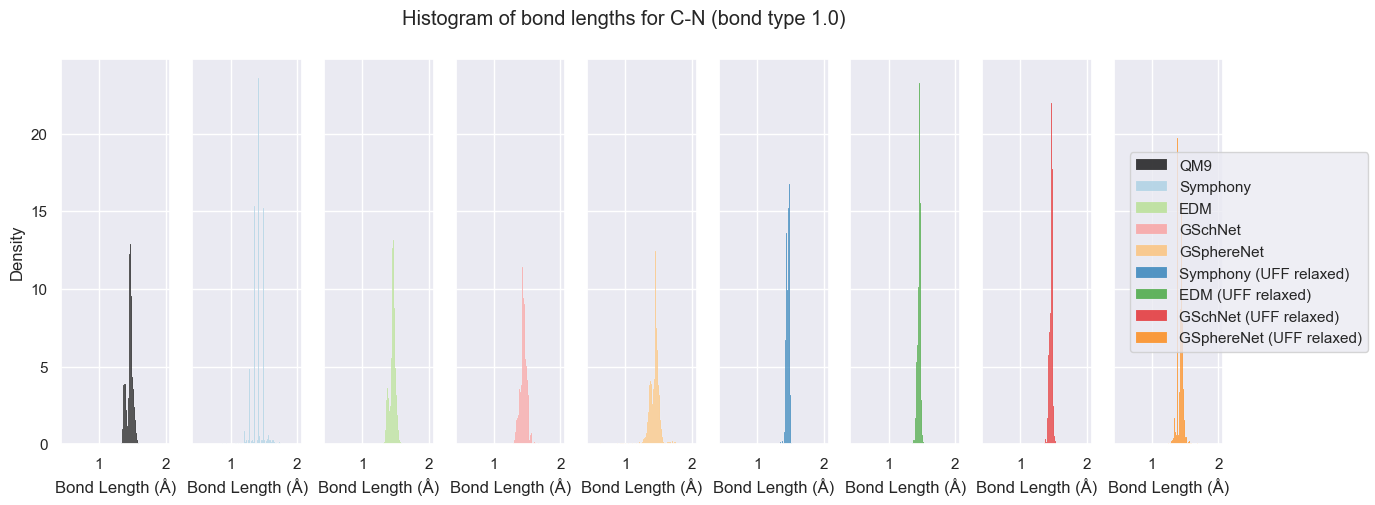

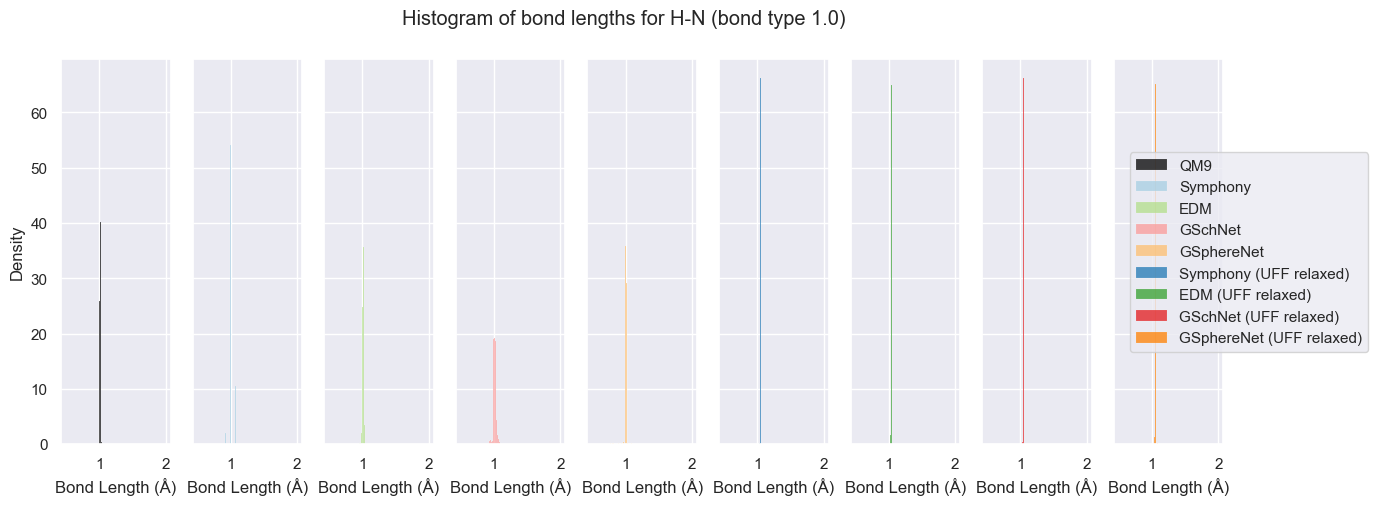

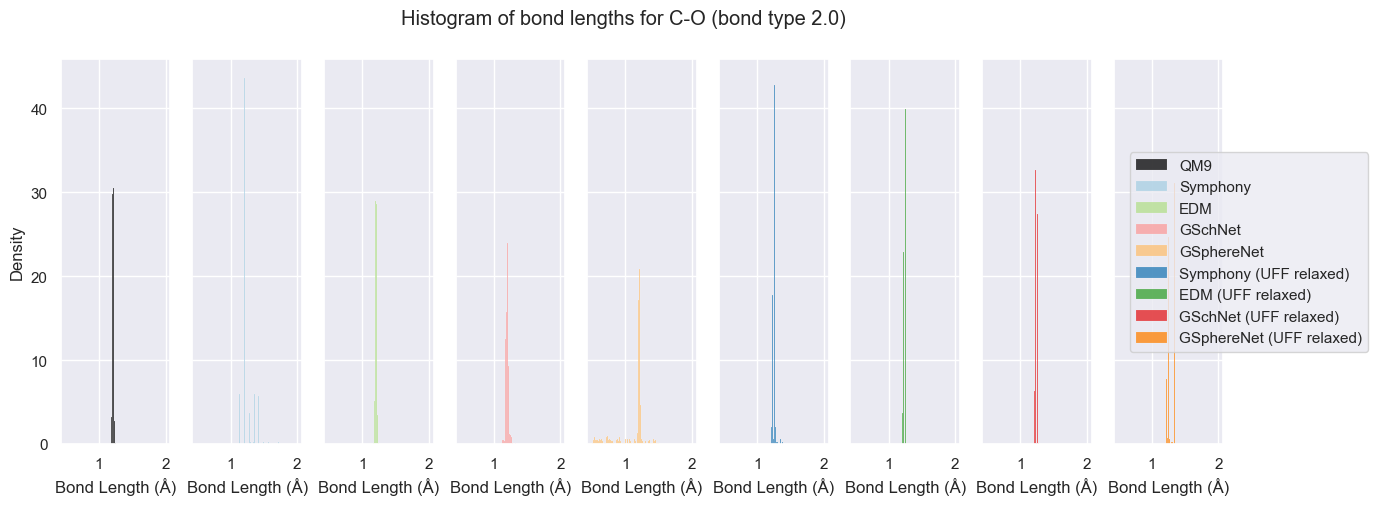

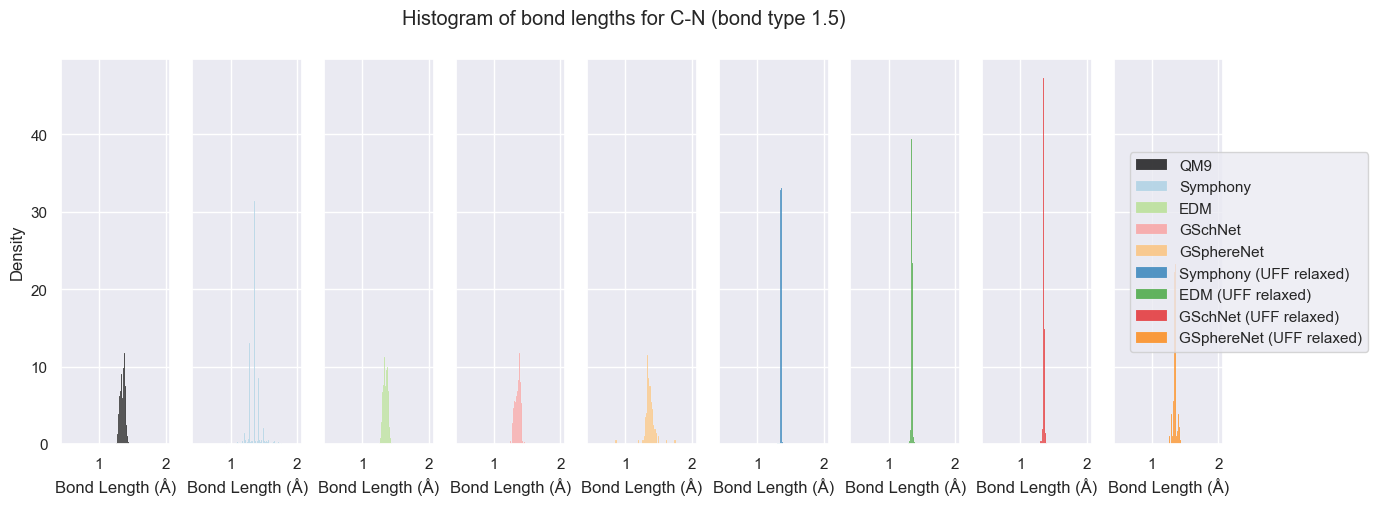

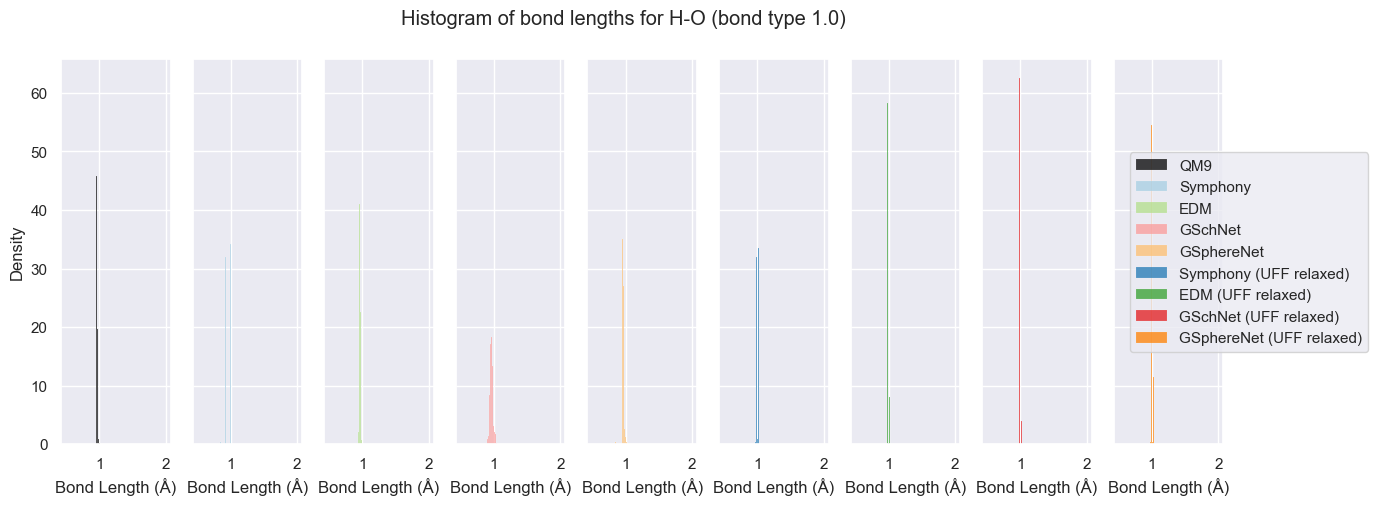

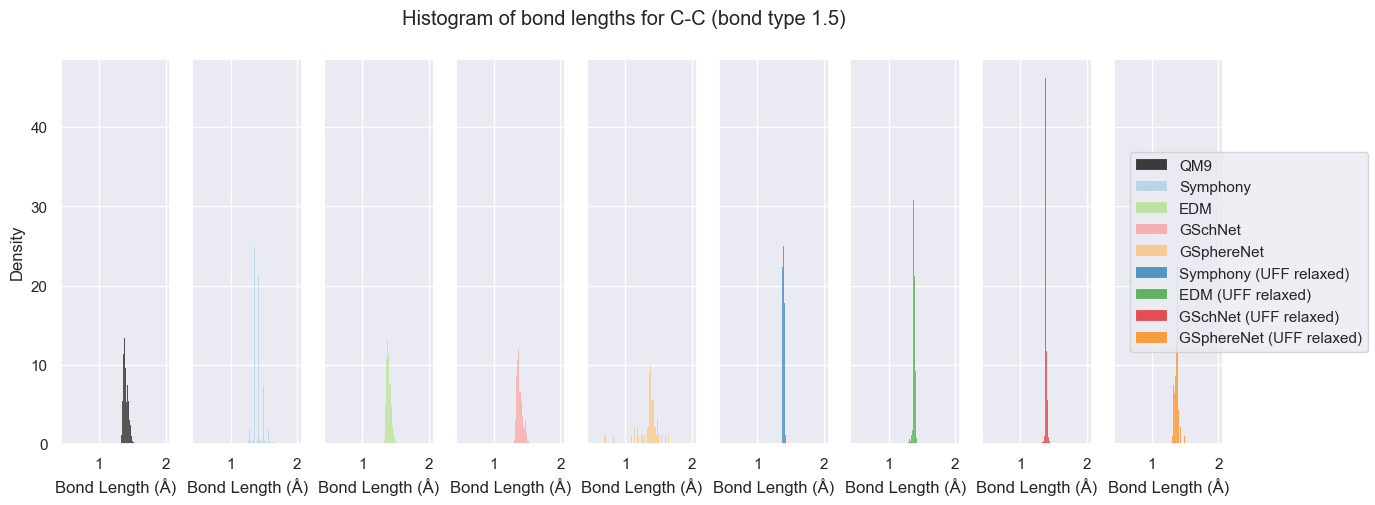

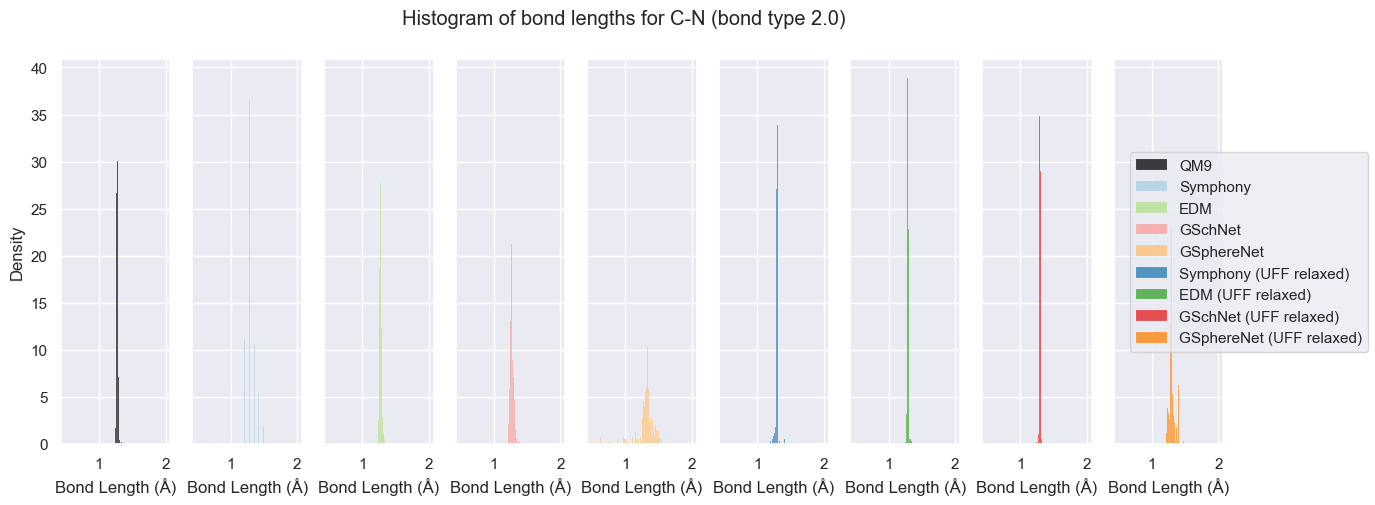

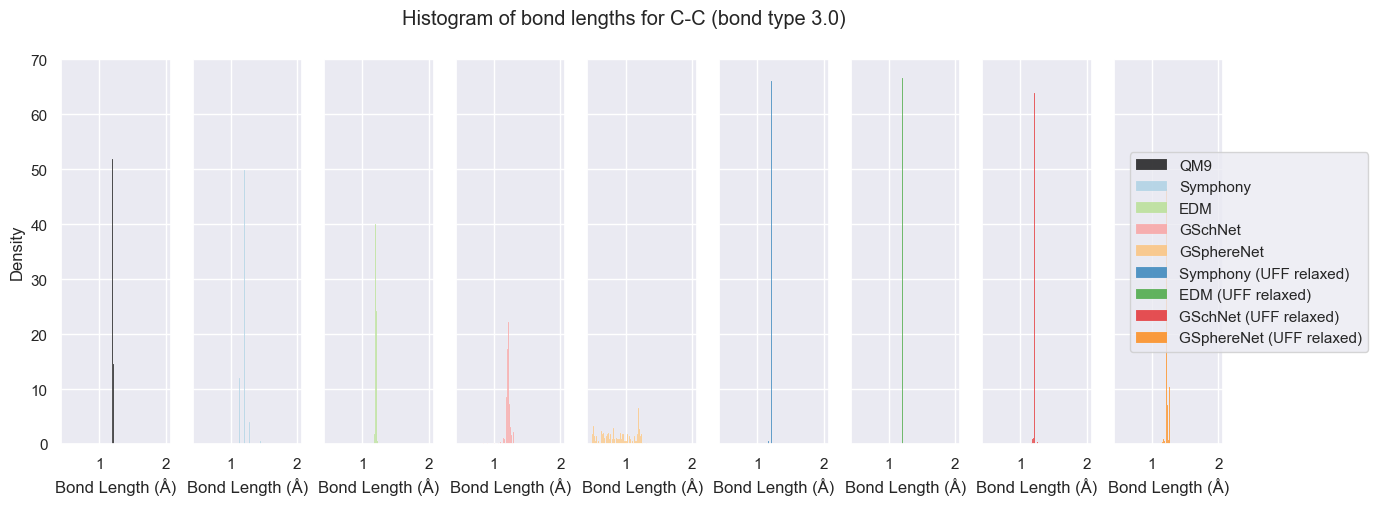

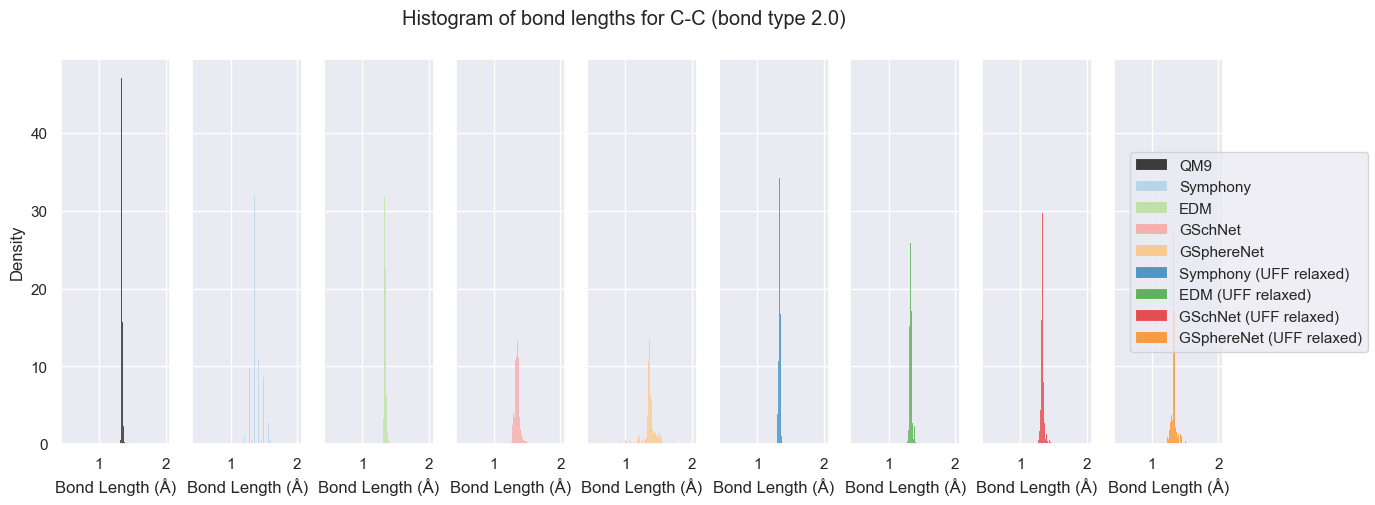

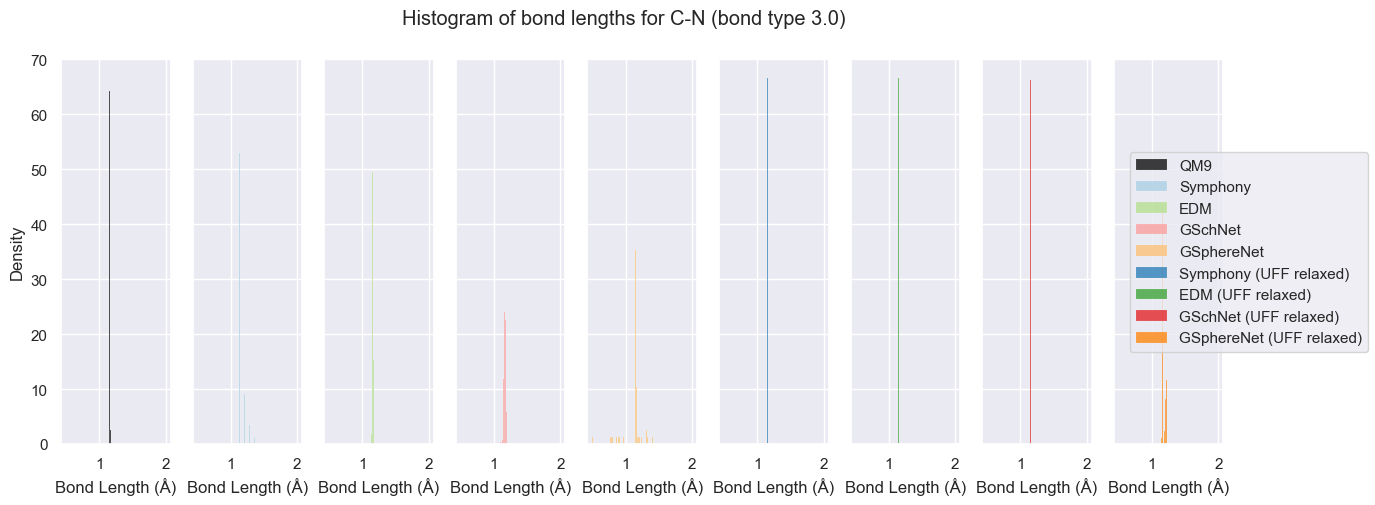

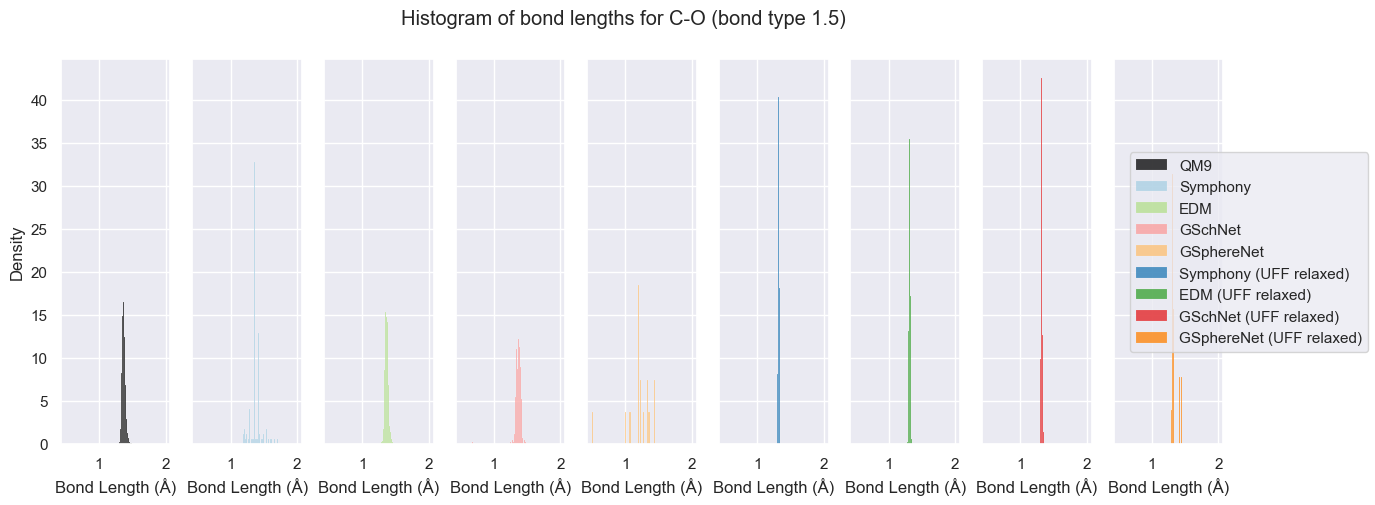

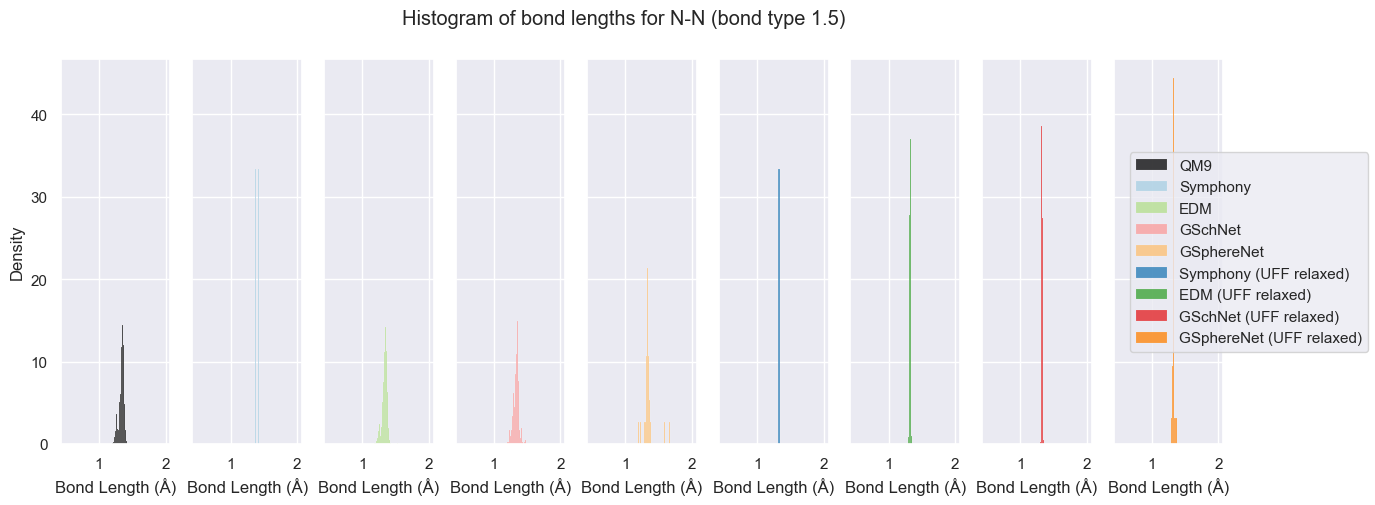

KeyError: ('N', 'O', 1.5)

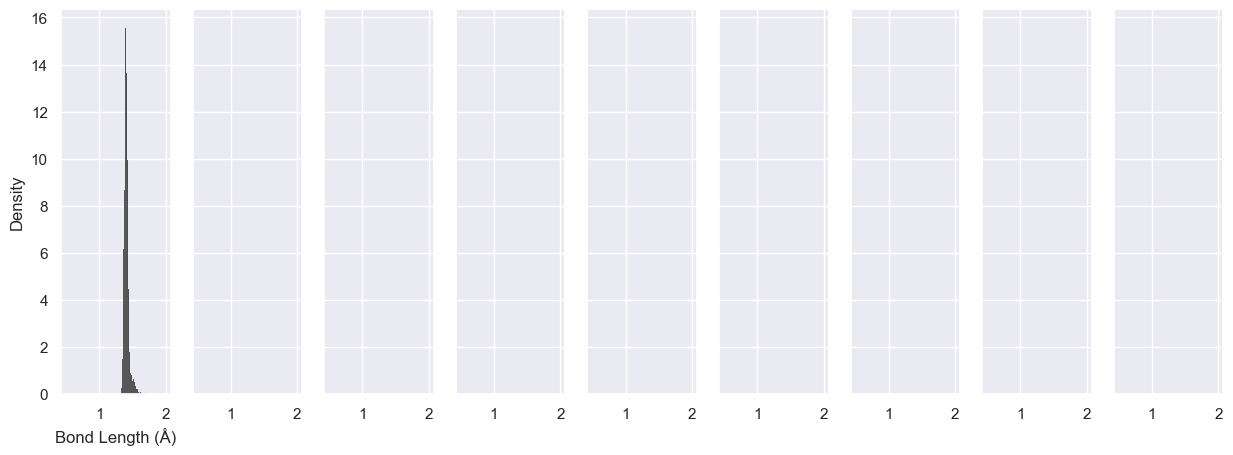

In [53]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_bond_length_counts:
    num_models = len(bond_dists)
    fig, axs = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 5), sharex=True, sharey=True)
    for index, model in enumerate(bond_dists):
        sns.histplot(
            bond_dists[model][bond_key],
            label=model,
            stat="density",
            color=model_palette[model],
            bins=100,
            binrange=(0.5, 2.0),
            ax=axs[index],
        )
        axs[index].set_xlabel("Bond Length (Å)")

    atom_type_1, atom_type_2, bond_type = bond_key
    fig.suptitle(
        f"Histogram of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    fig.legend(loc="center right")
    plt.show()

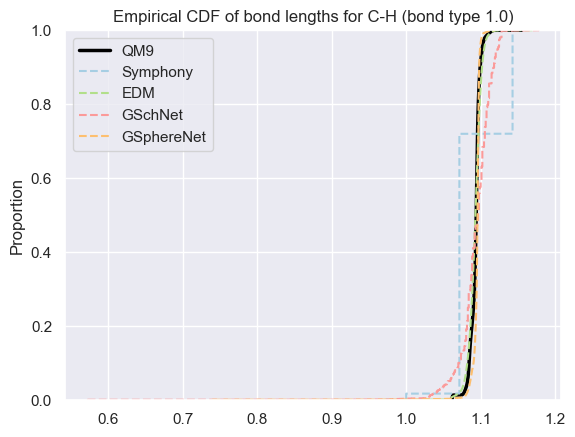

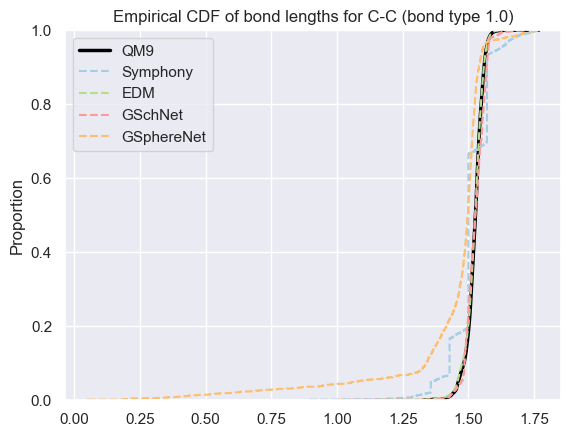

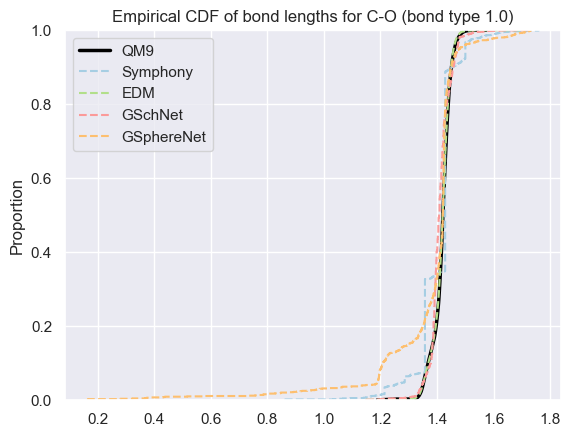

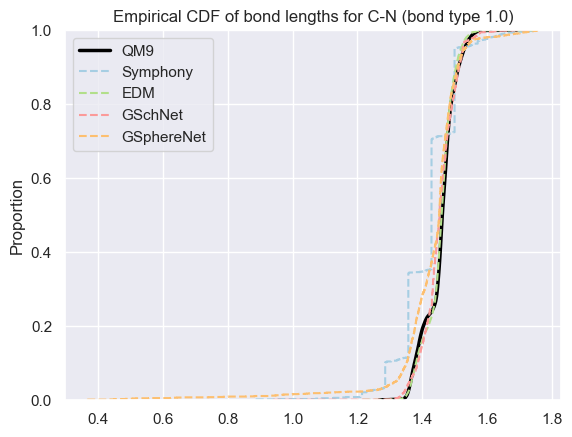

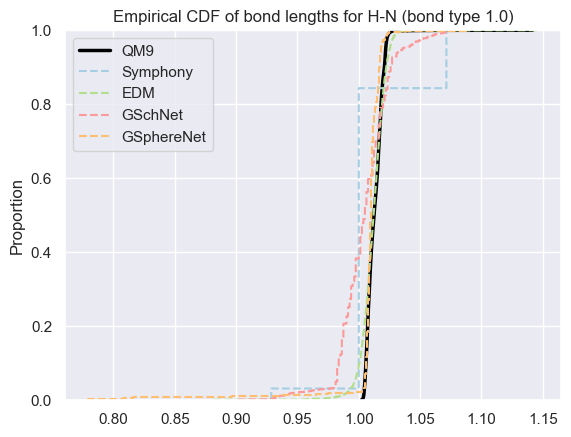

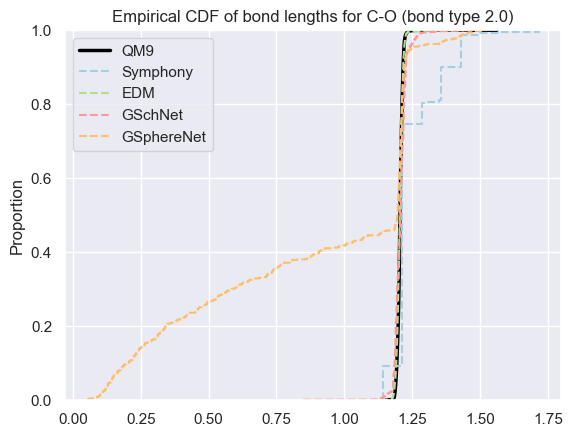

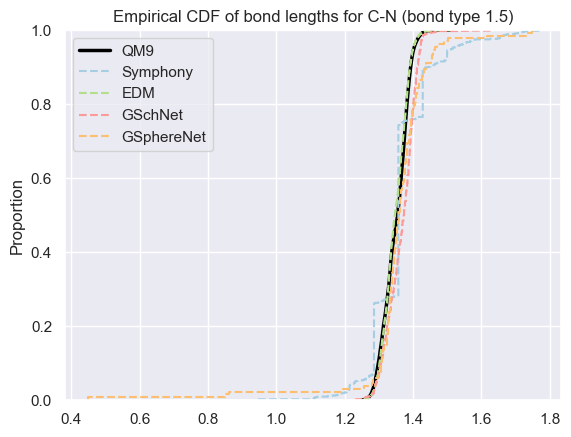

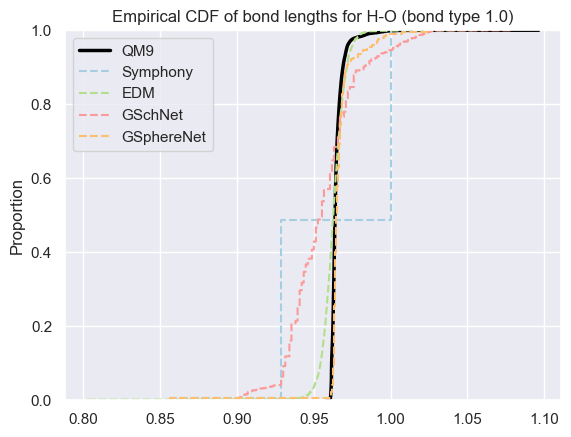

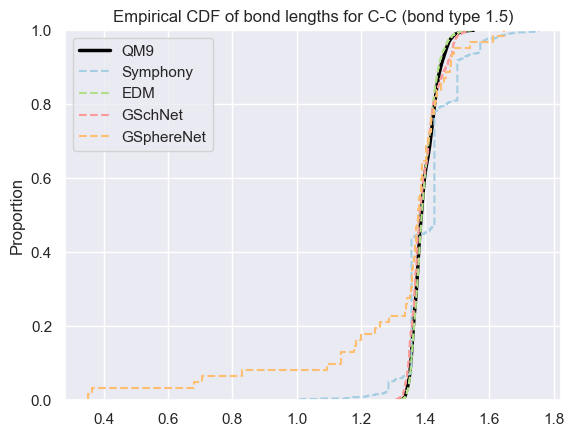

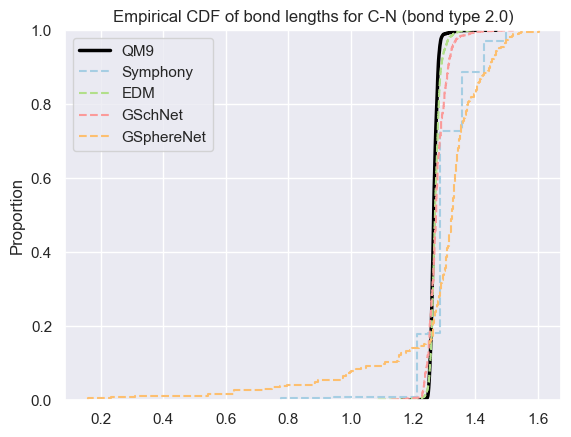

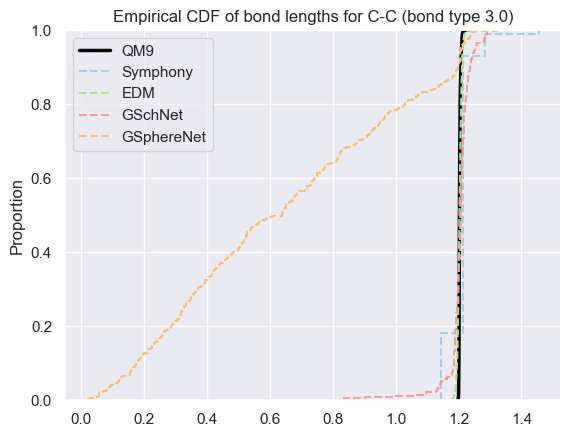

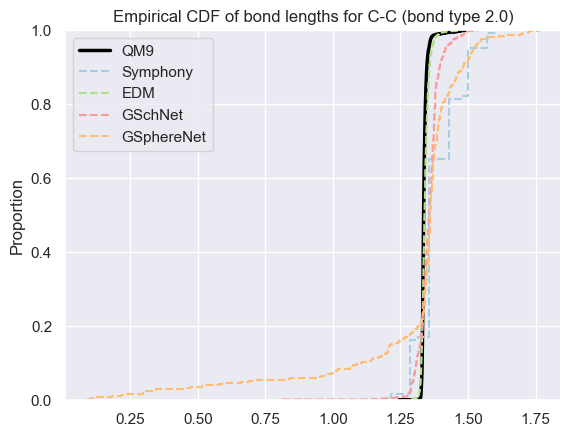

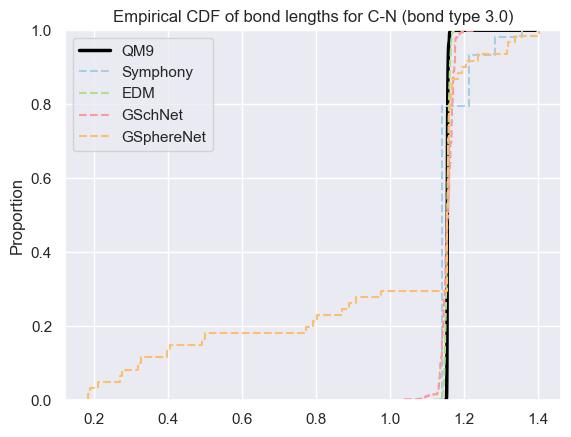

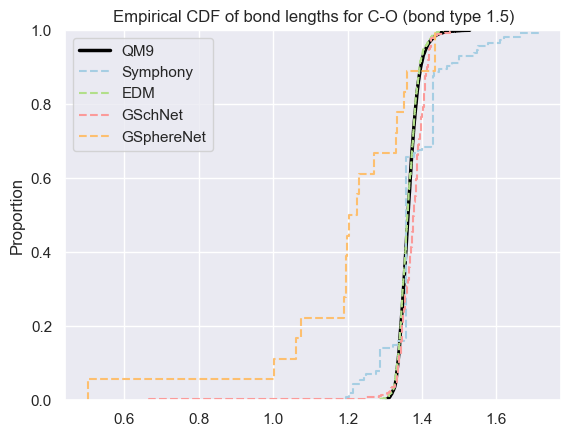

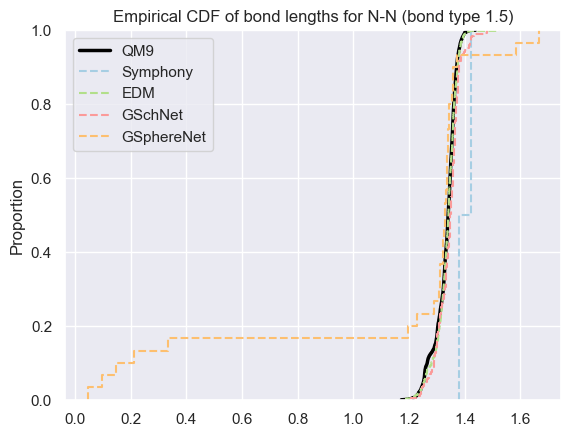

KeyError: ('N', 'O', 1.5)

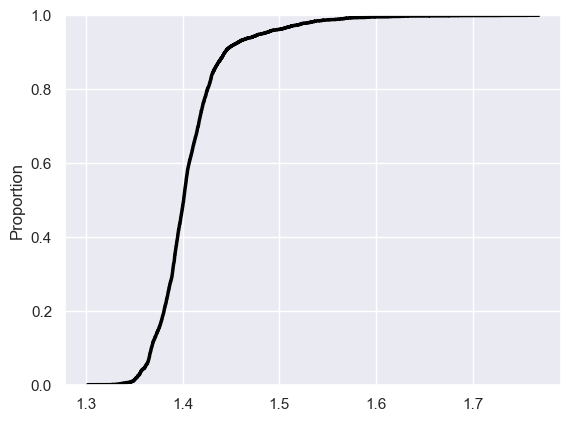

In [55]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_bond_length_counts:
    num_models = len(bond_dists)
    for model in generated_paths:
        if model == "QM9":
            sns.ecdfplot(bond_dists["QM9"][bond_key], label="QM9", color=model_palette[model], linewidth=2.5)
            continue

        sns.ecdfplot(
            bond_dists[model][bond_key],
            label=model,
            linestyle="--",
            color=model_palette[model],
        )

    atom_type_1, atom_type_2, bond_type = bond_key
    plt.title(
        f"Empirical CDF of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    plt.legend()
    plt.show()

Validity:

QM9: 99.99
Symphony: 88.00
EDM: 87.72
GSchNet: 80.36
GSphereNet: 26.92


<AxesSubplot: xlabel='model', ylabel='validity'>

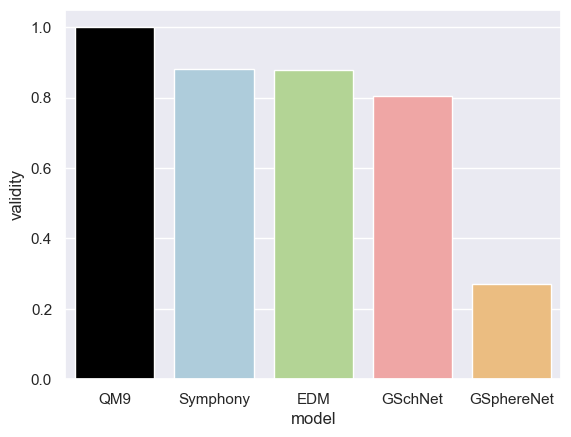

In [58]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["model", "validity"])

for model, molecules_dir in generated_paths.items():
    validity_fraction = compute_validity(molecules_dir)
    print(f"{model}: {100 * validity_fraction:0.2f}")
    
    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                {"model": model, "validity": [validity_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=validity_df, x="model", y="validity", palette=model_palette)


In [20]:
print("Symphony:")
for step in [100000, 200000, 500000, 1000000, 2000000, 5000000, "best"]:
    symphony_molecules_dir_step = generated_paths["Symphony"].replace(
        "step=best", f"step={step}"
    )
    validity_fraction = compute_validity(symphony_molecules_dir_step)
    print(f" Step {step}: {100 * validity_fraction:0.2f}")

Symphony:
 Step 100000: 74.00
 Step 200000: 75.80
 Step 500000: 74.50
 Step 1000000: 87.60
 Step 2000000: 85.40
 Step 5000000: 87.80
 Step best: 88.00
QM9: 99.99
Symphony: 88.00
EDM: 87.72
GSchNet: 80.36
GSphereNet: 26.92
Symphony (UFF relaxed): 94.79
EDM (UFF relaxed): 90.01
GSchNet (UFF relaxed): 87.46
GSphereNet (UFF relaxed): 80.13


Posebusters!

In [31]:
posebuster_results = {
    model: get_posebusters_results(bonded_molecules_dir)
    for model, bonded_molecules_dir in bonded_paths.items()
}

Failed to calculate ensemble conformation energy for InChI=1S/C7H13NO/c1-4-6(2)7(8-3)5-9(6)7/h4-5H2,1-3H3/t6-,7+/m1/s1: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C7H11NO/c1-2-4-5-3-6(4)7(5)8-9/h4-6,9H,2-3H2,1H3/t4-,5-,6+: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C6H10O/c1-6(7)4-2-5(6)3-4/h4-5,7H,2-3H2,1H3/t4-,5+,6-: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C6H9NO/c1-2-4-6(8)5-3-7(4)5/h4-5H,2-3H2,1H3/t4-,5+,7-/m1/s1: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C7H9NO/c8-5-7-2-1-6(7,3-7)4-9-5/h8H,1-4H2/t6-,7+/m0/s1: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C6H10O3/c1-9-6-2-5(8,3-6)4(6)7/h4,7-8H,2-3H2,1H3/t4-,5-,6+/m0/s1: Failed to generate conformations.
Failed to calculate ensemble conformation energy for InChI=1S/C8H12O

In [42]:
posebuster_results_df = pd.DataFrame(columns=["model", "test", "fraction_passed"])
for model in posebuster_results:
    model_results_df = posebuster_results[model].mean()

    # Add a column for the model.
    posebuster_results_df = pd.concat(
        [
            posebuster_results_df,
            pd.DataFrame.from_records(
                {"model": model, "test": model_results_df.index, "fraction_passed": model_results_df.values}
            ),
        ],
        ignore_index=True,
    )

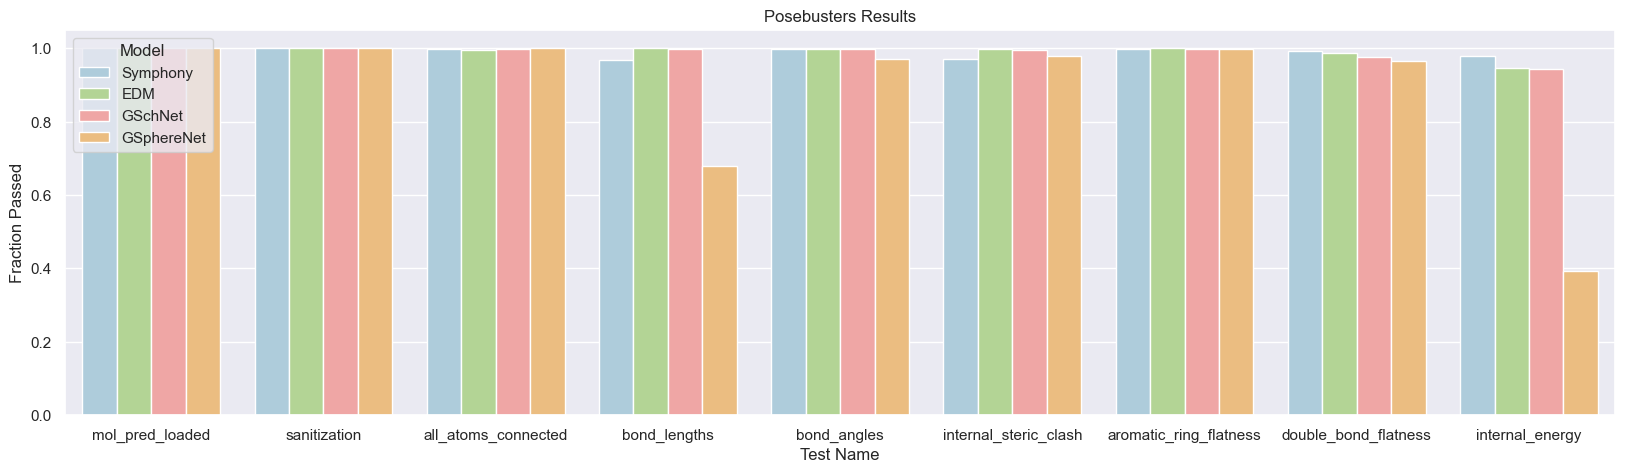

In [56]:
# Plot each row.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="test", y="fraction_passed", hue="model", data=posebuster_results_df, palette=model_palette, ax=ax)
plt.xlabel("Test Name")
plt.ylabel("Fraction Passed")
plt.legend(title="Model", loc="upper left")
plt.title("Posebusters Results")
plt.show()

In [1]:
# Print out the best models for each test.
for test in posebuster_results_df["test"].unique():
    print(f"{test}:")
    print(posebuster_results_df[posebuster_results_df["test"] == test].sort_values(by="fraction_passed", ascending=False).head(3))
    print("")

NameError: name 'posebuster_results_df' is not defined

Some other stuff...

In [326]:
molecule_dir1 = symphony_molecules_dir
molecule_dir2 = symphony_relaxed_molecules_dir
print(compute_validity(molecule_dir1))
print(compute_validity(molecule_dir2))

validity_sum_1 = 0
for molecule_file in os.listdir(molecule_dir1):
    if not molecule_file.endswith(".xyz"):
        continue
    if check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
        validity_sum_1 += 1
        if not check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir1} but not in {molecule_dir2}")

print("done")
validity_sum_2 = 0
for molecule_file in os.listdir(molecule_dir2):
    if not molecule_file.endswith(".xyz"):
        continue
    # print(molecule_file, check_molecule_validity(os.path.join(molecule_dir2, molecule_file)), check_molecule_validity(os.path.join(molecule_dir1, molecule_file)))
    if check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
        validity_sum_2 += 1
        if not check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir2} but not in {molecule_dir1}")

validity_sum_1, validity_sum_2

0.88
0.9479392624728851
H_seed=166.xyz is valid in /Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/molecules but not in /Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/relaxed_molecules
H_seed=895.xyz is valid in /Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/molecules but not in /Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding/nequip/interactions=3/l=5/position_channels=2/channels=64/global_embed=False/fait=1.0/pit=1.0/step=best/relaxed_molecules
H_seed=445.xyz is valid in /Users/ameyad/Documen

(880, 874)

Seeing invalid molecules in QM9:

In [27]:
import ase
import ase.io
import ase.visualize

invalid_mols = []
for molecules_file in os.listdir(qm9_molecules_dir):
    if not molecules_file.endswith(".xyz"):
        continue

    
    molecules_file = os.path.join(qm9_molecules_dir, molecules_file)
    if check_molecule_validity(molecules_file):
        continue

    print(f"{molecules_file} is invalid")
    mol = xyz_to_rdkit_molecule(molecules_file)

    mol = ase.Atoms(
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
        positions=mol.GetConformer().GetPositions(),
    )
    invalid_mols.append(mol)
        

/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_073323.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_042676.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_067109.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_090191.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_090838.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_038230.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_133831.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_044322.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_048903.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xyz/dsgdb9nsd_037494.xyz is invalid
/Users/ameyad/Documents/spherical-harmonic-net/others/qm9_xy

In [35]:
import nglview as nv
v = nv.show_asetraj(invalid_mols, gui=True)
v.add_representation("ball+stick")
v

NGLWidget(max_frame=16)

In [2]:
suppl = Chem.SDMolSupplier('/Users/ameyad/Documents/spherical-harmonic-net/symphony/data/qm9_data/gdb9.sdf', sanitize=False, removeHs=False)
invalid_sdf_mols = []
for mol in suppl:
    if mol is None:
        continue

    # Try to sanitize molecule.
    # If we could not sanitize, then save the molecules as an ase.Atoms object.
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        mol = ase.Atoms(
            symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
            positions=mol.GetConformer().GetPositions(),
        )
        invalid_sdf_mols.append(mol)
        continue

[13:06:03] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:06:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:06:03] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:06:03] Explicit valence for atom # 2 C, 5, is gre

1405


In [3]:
v = nv.show_asetraj(invalid_sdf_mols[:50], gui=True)
v.add_representation("ball+stick")
v

NGLWidget(max_frame=49)

# OpenBabel

In [55]:

def check_molecule_validity_with_openbabel(
    mol: openbabel.OBMol,
) -> bool:
    # Table of valences for each atom type.
    expected_valences = {
        "H": 1,
        "C": 4,
        "N": 3,
        "O": 2,
        "F": 1,
    }

    invalid = False
    for atom in openbabel.OBMolAtomIter(mol):
        atomic_num = atom.GetAtomicNum()
        atomic_symbol = openbabel.GetSymbol(atomic_num)
        atom_valency = atom.GetExplicitValence()
        if atom_valency != expected_valences[atomic_symbol]:
            invalid = True
            break

    return not invalid


def compute_validity_with_openbabel(molecules_dir: str) -> float:
    """Computes the fraction of molecules in a directory that are valid using OpenBabel."""

    obConversion = openbabel.OBConversion()
    obConversion.SetInFormat("xyz")

    valid = total = 0
    for molecules_file in os.listdir(molecules_dir):
        if not molecules_file.endswith(".xyz"):
            continue

        total += 1
        molecules_file = os.path.join(molecules_dir, molecules_file)

        mol = openbabel.OBMol()
        obConversion.ReadFile(mol, molecules_file)

        valid += check_molecule_validity_with_openbabel(mol)

    return valid / total

compute_validity_with_openbabel(generated_paths["QM9"])

N 2 3
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
C 5 4
C 5 4
C 5 4
N 2 3
C 5 4
C 3 4
C 3 4
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
C 3 4
O 1 2
C 5 4
C 3 4
N 2 3
N 2 3
C 3 4
N 2 3
C 3 4
C 5 4
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
N 4 3
C 5 4
C 3 4
C 3 4
N 2 3
C 3 4
N 4 3
N 2 3
N 2 3
C 3 4
C 3 4
N 2 3
N 2 3
C 3 4
C 3 4
N 4 3
C 3 4
N 2 3
C 3 4
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
N 2 3
C 3 4
N 4 3
N 2 3
C 3 4
N 4 3
C 3 4
C 3 4
C 3 4
N 2 3
N 2 3
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 5 4
N 2 3
C 3 4
C 3 4
C 3 4
N 5 3
C 3 4
N 4 3
N 2 3
C 3 4
N 5 3
N 2 3
C 3 4
N 2 3
N 4 3
C 3 4
C 3 4
C 3 4
N 2 3
N 4 3
C 3 4
C 5 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
N 4 3
C 3 4
C 3 4
C 5 4
N 2 3
C 3 4
C 3 4
C 3 4
N 2 3
C 3 4
N 4 3
C 3 4
C 3 4
N 2 3
N 2 3
C 3 4
C 3 4
C 3 4
C 5 4
C 3 4
C 3 4
N 2 3
C 3 4
C 3 4
C 3 4
C 3 4
N 2 3
C 3 4
N 4 3
C 3 4
N 2 3
C 3 4
N 2 3
C 3 4
N 4 3
N 2 3
N 2 3
N 4 3
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
C 3 4
N 2 3
N 2 3
N 2 3
O 1 2
C 3 4
N 2 3
C 3 4
C 3 4
C 3 4
N 2 

0.9459930704701753